### Noise Up and Send Waveforms Over

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os

In [2]:
#equation for the velocity-amplitude curve based on main sequence
a_fs=412.256
b_fs=49.036
c_fs=5.000
popt_fs = tuple([a_fs,b_fs,c_fs])

#equation for vel-amp curve for amplitude <6 degrees
a_exp = 368.93816447
b_exp =0.49166436
c_exp = 1.48726886
popt_exp = tuple([a_exp,b_exp,c_exp])

In [3]:
def func_exp(x, a = a_exp, b = b_exp, c = c_exp):
  return a * (1 - np.exp(-(x-b)/c))
def func_sigmoid(x,a,b,c):
  return a/(1+(b/x)**c)
def func_fixsqrt(x,a = a_fs,b = b_fs,c = c_fs):
  return a + b*(x-c)**0.5

In [4]:
#equation for the velocity-amplitude curve based on main sequence
a_fs=412.256
b_fs=49.036
c_fs=5.000
popt_fs = tuple([a_fs,b_fs,c_fs])

#equation for vel-amp curve for amplitude <6 degrees
a_exp = 368.93816447
b_exp =0.49166436
c_exp = 1.48726886
popt_exp = tuple([a_exp,b_exp,c_exp])

### Laser

In [5]:
left = [-15, -7.5, -10, -2.5]
right = [15, 7.5, 10, 2.5]
stim_time = [0,1.259, 2.513, 3.761, 5.009, 6.263, 7.511, 8.759, 9.999,10.5]

In [6]:
#num = 1 or 2 to decide if the test starts from left side or right side
def gen_target(left,right,num):
  l2 = left
  r2 = right
  random.shuffle(l2)
  random.shuffle(r2)
  stimulus = [0]
# stimulus starts on the left side
  if num == 1:
    for i in range(len(l2)):
      stimulus.append(l2[i])
      stimulus.append(r2[i])
    stimulus.append(r2[i])
# stimulus starts on the right side
  else:
    for i in range(len(r2)):
      stimulus.append(r2[i])
      stimulus.append(l2[i])
    stimulus.append(l2[i])
  return stimulus

In [7]:
def gen_reconstructed_laser(stimulus):
  stim = stimulus[:-1]
  reconstructed_laser = [val for val in stim for _ in (0, 1)]
  return reconstructed_laser

## Generating the saccades


### Functions to produce latency, velocity and amplitude

In [8]:
#generate the velocity for every saccade
def gen_velocity(amplitude):
  # print("input amp", amplitude)
  amplitude = np.abs(amplitude)
  if amplitude <= 6:
      vel = func_exp(amplitude,a_exp,b_exp,c_exp)
  else:
      vel = func_fixsqrt(amplitude,a_fs,b_fs,c_fs) + np.random.uniform(0,15)*(-1)**np.random.randint(2)
  return vel

#generate the latency for a saccade for each subject
def gen_latency(subject):
    # normal subject latency parameters
    if subject == "N":
      return np.random.normal(0.3,.025)
    # abnormal subject latency range
    else:
      return np.random.normal(0.55,.05) #for a first pass we are only modeling changes in accuracy


#generate the latency for the correcting saccade
def gen_latency_correcting(subject, prev_lat):
    if subject == "N":
      return np.random.uniform(0.050,0.15)
    else:
      return np.random.uniform(0.050,0.15) #for a first pass we are only modeling changes in accuracy

#generate accuracy for the saccade
def gen_accuracy(subject, condition, sac_seq):
# normal subject accuracy range
  if subject == "N":
    if sac_seq == "P":
      return np.random.normal(.95,.1)
      # return 1
    else: #correcting saccade
      return 1
# abnormal subject accuracy range
  else: #abnormal saccade
    if condition == "hyper":
    # initial shift
      if sac_seq == "P":
        return np.random.normal(1.35,.05) #what's the upper limit?
      else: #corrective saccade
        return np.random.uniform(1.00,1.1)
    else: #hypometria
    # initial shift
      if sac_seq == "P":
        return np.random.normal(.40,.10)
      else: #corrective saccade
        return np.random.uniform(0.90,1)

### Normal Waveform - Accuracy Only

In [9]:
def gen_waveform(stimulus, subject, condition, num):
  wave = [0, 0]
  time = [0, 1.259]
  main_seq = []
  for idx in range(len(stimulus)-1):# Avoids out-of-range issues with stimulus[idx+1]
      # First time point: Start of the saccade (stim start + latency)
      lat = gen_latency("N")
      time.append(time[-1] + lat)  # Appends new latency time
      wave.append(wave[-1])   # Appends current stimulus level
    
      # print("Step 1:", time[-4:], wave[-4:])

      # Second point: First saccade amplitude
      # amplitude change
      amp = gen_accuracy(subject, condition, "P") * stimulus[idx + 1] - wave[-1]
      print(gen_accuracy(subject, condition, "P") * stimulus[idx + 1])
      wave.append(amp + wave[-1])  # Amplitude added to last wave point
      # generate velocity
      vel = gen_velocity(amp)
      time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
      main_seq.append([vel,amp])
      # print("Step 2:", amp, vel, time[-4:], wave[-4:])

      # Hold the saccade
      lat2 = gen_latency_correcting(subject, lat)
      time.append(time[-1] + lat2)  # Time after latency correction
      wave.append(wave[-1])  # Holds at current amplitude
      # print("Step 3:", lat2, time[-4:], wave[-4:])

      # Third point: Corrective saccade
      amp_c = gen_accuracy(subject, condition, "C") * stimulus[idx + 1] - amp
      vel_c = gen_velocity(amp_c)
      time.append(time[-1] + np.abs(amp_c / vel_c))  # Time for corrective saccade
      wave.append(amp_c + amp)  # New amplitude after corrective saccade
      main_seq.append([vel_c,amp_c])
      # print("Step 4:", amp_c, amp, vel_c, time[-1], time[-4:], wave[-4:])

      # Hold the corrective saccade
      if idx >= len(stimulus) - 3:  # Ensure we don’t exceed `stimulus` length
          break
      final_amp = wave[-1]  # Hold at current amplitude for final correction
      time.append(stim_time[idx + 2])  # Appends the next stimulation time
      wave.append(final_amp)  # Append final amplitude
    
  time.append(10.5)
  wave.append(wave[-1])
  # mean = 0
  # std_dev = 0.1
  # noise = np.random.normal(mean, std_dev, len(wave))
  # wave = wave + noise
      # print("Step 5:", final_amp, stim_time[idx + 2], time[-4:], wave[-4:])
  return time, wave, main_seq

### Waveform -> Different Hz

In [10]:
def make_df(time, waveform, samp_freq,i):
    max_t = int(10.5*samp_freq)
    timesteps = np.arange(0,max_t,1)
    wave_1000 = pd.DataFrame(data=timesteps, columns=["timesteps"]).set_index("timesteps")
    wave_df = pd.DataFrame({"timesteps": (np.array(time) * samp_freq).astype(int), f"amplitude_{i}": waveform})
    wave_df.set_index("timesteps", inplace=True)
    wave_1000 = wave_1000.join(wave_df, rsuffix=f"_{i}").interpolate(method='linear', limit_direction='both')
    wave_1000 = wave_1000.join(wave_df,on = "timesteps", rsuffix=f"_{i}")
    return wave_1000

In [44]:
def make_df_2(time, waveform, samp_freq,i):
    max_t = int(10.5*samp_freq)
    timesteps = np.arange(0,max_t,1)
    wave_1000 = pd.DataFrame(data=timesteps, columns=["timesteps"]).set_index("timesteps")
    wave_df = pd.DataFrame({"timesteps": (np.array(time) * samp_freq).astype(int), f"amplitude_{i}": waveform})
    wave_df.set_index("timesteps", inplace=True)
    wave_1000 = wave_1000.join(wave_df, rsuffix=f"_{i}").interpolate(method='linear', limit_direction='both')
    wave_1000 = wave_1000.join(wave_df,on = "timesteps", rsuffix=f"_{i}")
    noise_scale = np.random.uniform(0, 0.5)
    wave_1000 += np.random.normal(loc=0, scale=noise_scale, size=wave_1000.shape)
    return wave_1000

### Generate Tuples Frome Dataset of Interest - Equal Class Sizes

In [12]:
def tuple_generation(data_size):
    
    g_size = int(data_size/6)
    class_size = g_size * 2
    
    # Create a tuple of tuples
    # normal class - vary start stimulus direction
    x_input_normal_1 = tuple(("N", "none",1) for _ in range(g_size))
    x_input_normal_2 = tuple(("N", "none",2) for _ in range(g_size))

    # bilateral hypometric class - vary start stimulus direction
    x_input_hypo_1 = tuple(("A", "hypo",1) for _ in range(g_size))
    x_input_hypo_2 = tuple(("A", "hypo",2) for _ in range(g_size))

    # bilateral hypermetric class - vary start stimulus direction
    x_input_hyper_1 = tuple(("A", "hyper",1) for _ in range(g_size))
    x_input_hyper_2 = tuple(("A", "hyper",2) for _ in range(g_size))
    
    x_input_list_one = [x_input_normal_1,x_input_normal_2,x_input_hypo_1,x_input_hypo_2,
    x_input_hyper_1,x_input_hyper_2]
    
    # hypos on right & hypers on left
    # 1: stimulus starts on the left
    # 1: hypers are first
    x_input_uni_1_1 = tuple(("A", "unilateral",1,1) for _ in range(g_size))
    # stimulus starts on right
    x_input_uni_2_2 = tuple(("A", "unilateral",2,2) for _ in range(g_size))

    # hypers on right & hypos on left
    # stimulus start on left
    x_input_uni_1_2 = tuple(("A", "unilateral",1,2) for _ in range(g_size))
    # stimulus starts on right
    x_input_uni_2_1 = tuple(("A", "unilateral",2,1) for _ in range(g_size))
    
    y_list = np.concatenate(([0]*class_size, [1]*class_size, 
    [2]*class_size,[3]*class_size, [4]*class_size))
    
    return x_input_normal_1, x_input_normal_2, x_input_hypo_1,x_input_hypo_2,x_input_hyper_1,x_input_hyper_2

In [53]:
x_input_normal_1, x_input_normal_2, x_input_hypo_1,x_input_hypo_2,x_input_hyper_1,x_input_hyper_2 = tuple_generation(30000)

### Data Generation

In [46]:
# Define folder name
folder_name = "Normal Waveforms"

# Ensure the folder exists
os.makedirs(folder_name, exist_ok=True)

# Define full file path
filename = os.path.join(folder_name, f"normal_1.csv")
filename

'Bilateral Hypermetric/normal_1.csv'

In [54]:
for i, row in enumerate(x_input_normal_1):
    target = []
    data = []
    
    # generate stimulus
    stimulus = gen_target(left,right,row[2])
    reconstructed_laser = gen_reconstructed_laser(stimulus)
    reconstructed_time=[0,1.259,1.260,2.513,2.514,3.761,3.762,5.009,5.010,6.263,6.264,7.511,7.512,8.759, 8.760, 9.999,10.000,10.5]
    # stimulus dataframe
    stimulus_df = make_df(reconstructed_time,reconstructed_laser,60,0)
    stimulus_df = stimulus_df.iloc[:630,:-1]
    target.append(stimulus_df.T.values[0])
    
    time, waveform, main_seq = gen_waveform(stimulus, *row)
    wave_df = make_df_2(time, waveform,60,i)
    wave_df = wave_df.iloc[:630,:]
    
    if(len(wave_df.T.values[0]) != 630):
        print("What the hell")
        # print(i)
        # print(len(wave_df.T.values[0]))
        
    data.append(wave_df.T.values[:-1])
    # if i % 1000 == 0:
        # print("we're going strong..")
    
    target = target[0]
    patient = data[0][0]
    timesteps = list(range(0,630))
    full_data = pd.DataFrame({'timesteps':timesteps,'target':target,'patient':patient})
    first_five_sec = full_data.iloc[:300,:]
    
    folder_name = "NormalClass"
    
    # Ensure the folder exists
    os.makedirs(folder_name, exist_ok=True)

    # Define full file path
    filename = os.path.join(folder_name, f"normal_1_{i}.csv")
    
    # add to folder
    first_five_sec.to_csv(filename,index = False)

-8.496139533092094
7.022984580532991
-13.20068320662945
17.73074770196016
-9.741710950045327
10.523970621508456
-2.261284820189315
2.795397266035974
-15.363439953918563
2.367692834215119
-10.232054303895886
10.752535088819023
-2.4869596102392553
13.107485562971743
-7.021723066266696
6.763306617327935
-6.622471711835452
2.3324079053713715
-15.395192932104942
14.125128585577121
-1.9109234946736673
9.492772694739003
-8.805569819223217
8.191291382735491
-6.242132328115289
2.5920621582286465
-7.291962516815684
11.7262036308794
-2.280062416539243
6.625147913117417
-14.762206854627522
13.249200672221297
-16.816852148171233
7.647475213951978
-7.966706894758639
15.626352703300114
-2.413092048169486
9.204190627657722
-9.5304891503892
2.661740828363366
-13.53335915088566
16.38311168503679
-10.922001858122687
2.4622054007942116
-2.5117325140721363
7.559790916972309
-6.553628084791838
7.752207998609625
-14.478410311890638
2.766549262484686
-8.262326252404671
13.942179444606904
-2.337632684109085
7.

-9.87454341627048
15.448255880354436
-6.032596185154157
2.3005651140317633
-16.190157179138488
8.97090034345718
-2.3069952227405004
7.268684834500955
-14.192895390087973
6.141673417629737
-10.089919750368264
2.7467621676445226
-7.965764896853459
14.797857402257813
-2.525486920184284
8.266313159746774
-15.262779075917866
12.279782865622572
-2.36078150546
2.4676634003680626
-10.865033979711837
10.00489657958395
-7.429254153374304
8.736377011963484
-16.32912819514573
12.273662308936368
-7.211339221851093
7.541851401026216
-2.0561770131887918
2.6755376492721976
-9.117430544149231
10.024402726074499
-6.81688265971654
12.958970232934213
-1.9712596051062592
6.343814616169588
-12.478748333092758
9.349125987353
-10.30443682045026
2.062008602745759
-2.4384325694338522
8.605840591620277
-8.253272506495819
15.07688856690222
-6.911650313853832
6.713454419809935
-15.542928387307288
2.3700154088072685
-2.4311617057518573
15.094602022715009
-8.664552277975062
7.9727025038138555
-14.668469651086676
2.7

-8.878684232016061
9.770491017424089
-2.5215841323417214
7.833710192623297
-14.695561718193332
14.006254951852753
-7.989708910347437
1.7268696325718231
-9.846429506371985
13.048195341718055
-2.312451630905031
2.5027164179252317
-6.071346417941903
7.1050423041703645
-14.286708970745917
10.86288634010516
-2.560264280057728
15.280865539578233
-8.838899683813029
7.769926182999265
-15.712509582748753
2.2559139895924467
-7.423584339495147
9.729129787640344
-2.1476299068129876
9.891820628710216
-14.735027610621609
1.9699206739782138
-6.18500750090171
15.34997880652958
-10.530444921708607
8.04060577482955
-7.851530947991724
9.540781394813276
-14.20742036169902
2.5315354921041333
-2.3235253634363287
11.289262759333187
-10.317816706361647
6.544354071602435
-9.653055292414926
6.354518154974631
-8.45590224075244
2.74407867789767
-14.18155005055172
15.15049736961412
-2.8324081044914995
9.273610615016839
-7.413203033593276
8.584799494656894
-2.617707297516963
13.663377796703392
-14.651790796276668
6

-8.660332659091273
6.5888036691156815
-2.9015592083558053
9.49735270285215
-6.163588370387226
2.3073878241346772
-14.965319239529261
14.851249116043387
-7.28482629493584
8.162968840471537
-8.856800664216323
7.780553969098045
-1.9313138620222103
13.008472585142988
-13.2755876827982
2.5395183441488083
-9.995548107921248
7.86095012661082
-6.728770200550198
9.679187794611824
-15.667244840089019
16.59697688014066
-2.390821268141908
2.2124368099044007
-15.872946410038825
8.677538136576171
-8.542778554565594
11.467211685130918
-2.3435160447080223
2.4596981138201333
-9.227071283504124
6.559265524055573
-2.463699607324841
6.680435843804374
-7.771928756915772
2.4160500769633653
-9.285075952063359
12.987654978009221
-13.869880464605995
8.952128745051093
-9.259671699596838
2.366360410822202
-6.136101564995109
17.598998872712684
-12.464394059968383
7.8326700522334765
-2.0992415102966095
9.699002027219958
-7.310743847974491
2.6566983235662534
-12.769385290407577
8.40424277899495
-7.488026879709469
1

-13.016961817287623
14.368652785976703
-9.283943281528682
2.0462654978326706
-7.498592882442579
11.580040298112937
-2.21509629810589
7.513000354810921
-4.821119848582836
9.885399927726775
-12.933317837906499
12.821806073001424
-7.580808359955682
7.505962921048583
-2.481186442865706
2.7798697210590797
-7.78712079363058
2.5109508438842356
-1.8803833611467813
6.205951204206852
-15.136710483620488
12.688513884260558
-9.470176126507802
9.404784620571817
-2.3222116359648175
12.027516989692522
-14.636016529992242
3.0228281877404966
-11.153377281042387
8.519864457557098
-6.787690550141874
7.186674756812443
-6.105122988304786
6.469730493768089
-15.378004923297192
10.508670103247265
-8.999431212621278
2.0242409842613256
-2.39232537744185
14.671255209318028
-10.703714043574735
8.661371708476238
-7.220960643804022
5.55477419463624
-13.979701123395378
14.699693044557373
-1.9885722456423092
1.9948274001431976
-6.894419760221545
14.398658397305068
-15.113680500487753
10.098417768065408
-10.7375513574

-2.40142561308398
7.457186321295531
-8.960943543877463
2.52096068958691
-7.936689518002726
10.22317418621322
-14.709701024079376
14.986895062008136
-6.74703703822192
13.061774700836333
-12.765196545255703
6.719554721880396
-2.760828751191709
8.788681982411138
-10.008345651036075
2.131115163427961
-7.6697822596278185
9.897356985894973
-14.891466286977606
2.4792225047849374
-2.1753210856367597
6.815437016089095
-9.007876820990568
12.89971762634007
-8.993356774302798
6.506180761134575
-2.368465116071073
10.426725045048075
-13.765844703905673
2.539418199472757
-6.866920332661696
14.854904362379713
-13.898045054404369
9.023896189439828
-1.8754318148411373
13.171119025116983
-5.955111056695912
2.4341742238801096
-10.220466526262783
7.743056696564325
-2.3387396192035133
14.258464172726034
-10.818823142226549
7.693149012202774
-6.950269768278988
8.864081876142777
-14.931090434776513
2.487409819405258
-14.396154148160813
2.0546267250560146
-12.184831687013983
5.361212991053232
-7.78310363542115

-17.031257493219634
13.554386194098464
-7.033852117316019
2.3272014783889845
-2.2210009486716644
10.239183747846962
-10.803821947513054
7.964949862899884
-13.645619329287339
5.813764311898505
-10.316410819373512
13.151019494189315
-2.1970771147732098
2.1760227680805007
-8.12695266678588
9.744835109756725
-13.753226998226825
2.517151869799874
-8.768399428769493
13.112621948442241
-2.1912930942944757
9.274595136315039
-6.618949417824134
6.201028099896588
-6.5529993700974
8.037303416211369
-10.428706401617605
2.1695319031669715
-14.685092412391938
9.036744306422346
-2.103887978858192
11.140926800576704
-2.11077633952834
9.254103411735866
-8.049735232007627
12.59236534070346
-9.721815308691278
2.4842255592260276
-15.296287525230358
8.131839304932226
-7.000638589164696
2.516427728819006
-8.665533856333354
8.46353406328394
-14.507431410112883
9.642571893336164
-2.407096079282487
9.377876708388692
-2.064715081692248
15.933433860893633
-9.703081021714485
9.31761921568389
-5.586344865046884
2.4

-6.305027931377738
7.170931546200162
-2.687225110614916
12.658943759687558
-14.051471219520039
2.4365069998523086
-10.014414445769651
10.123274723308494
-2.5109962488646835
2.0542898971172634
-9.286538004706305
8.012836211334017
-11.30749733662526
13.02358186049036
-8.008150262805454
10.638961748337268
-15.922602070121743
7.9513917061913535
-7.939735198792377
16.956570832292478
-7.741726974678586
9.0456772824109
-2.619445330688853
2.3342132278113352
-7.174815935776219
2.552454196575832
-2.0851780202064427
12.623666714129033
-9.565168883433918
10.799192905302384
-13.717198940913777
7.62793697652619
-2.1880650199390073
2.3770928908449003
-12.679707532355312
7.6864888718434194
-10.792127503338811
11.787726248474833
-6.313195269943263
10.053220198326294
-14.330914426115383
7.057423488692799
-10.830729844669541
2.6680454453465545
-5.798558312112226
9.864107707814888
-2.1445244224718705
13.617481833109505
-2.2813337061138803
9.438817567323007
-8.517112182094312
5.940490851397205
-12.49425384

-6.480912174736592
16.20972477217319
-15.625460570659392
10.299875249978802
-2.187046397624321
6.857141328906951
-10.534954857410114
2.202309698296305
-2.0040624799143774
15.410384001093115
-9.558627190059566
6.824954561947994
-16.132393756766117
9.019377022080043
-6.896540212563
1.9493803741302536
-7.700907202164671
9.745502921773395
-2.565415972555108
13.805288435679854
-7.283073919519681
7.068782528194114
-15.584932286761578
2.0415831205094372
-2.2617159410098164
2.6559998627023838
-8.334617424102449
15.832402661957099
-7.716985647384803
7.3964480660400875
-17.186374816205202
11.333041810153546
-12.47465210951263
2.45123933174076
-7.903402553673521
12.504119073972129
-2.695547189569657
8.444760055288414
-10.079374543473701
6.704878817749844
-13.895490767160618
2.5008328054186197
-2.4412472774328844
9.270734382856059
-8.442007910198642
7.732193547342997
-6.928519539707246
13.282003554728826
-5.960793369840386
11.793460670653525
-9.485787954527058
6.720672893446777
-2.3663707590617027

-5.628251308881503
16.580215199671088
-1.825999058511466
9.405973944899365
-14.485237380921259
2.0316952959131953
-9.41878185562797
6.1261208143266845
-2.199434232182435
9.78538810755489
-8.987492905300808
8.226895951229778
-7.132177230185541
13.058803004564405
-15.282315830994357
2.43077701262398
-2.2047806687273157
8.39998635613924
-6.320866107843756
9.143190900761125
-10.683132592653283
2.119853125500356
-15.478978179754973
13.794675701492704
-7.6834185702820745
13.172247378428
-12.981336570314241
6.378173803181816
-2.450115371363783
2.071605277512999
-10.005973156150702
9.512667761182325
-2.435395243780482
7.9975779367479465
-5.7307701435133405
13.761629263640366
-9.196495064005399
2.2015669074550974
-12.138131426041593
7.5817647846198195
-6.189266267171148
14.79005171832831
-13.467086015168947
7.57411282200133
-9.974275461950455
10.637015758686994
-2.4613119684602296
2.5429585287804004
-7.218413278877044
9.147582738193202
-2.197365833599462
2.7327370300104765
-10.304478172114473
7

-7.461947776336821
6.72982807390898
-2.633478920936919
16.103936593101395
-11.807366734852517
8.959935888131804
-9.21558353166721
2.52992724217394
-2.321670369670766
8.528061124827842
-6.6497455439401145
2.734542920295133
-16.19185560618459
10.511440803686439
-10.06709111298571
13.024700588385976
-7.920133418907746
2.6356608085721556
-2.3850280045115015
14.778087521504359
-7.395801374315315
7.48498281483636
-14.1331697345881
10.188985578497768
-14.85063964827505
10.34298344376352
-6.982591851528997
6.551928596281259
-8.273773103508745
2.476298123614355
-2.3498825885032653
9.469510037937393
-8.946871020632972
15.216852686484795
-2.404391839543826
2.699577599754994
-15.427559570106837
10.173091028507447
-6.397465069704999
7.4048692214066145
-2.3450231945356443
17.54010444949561
-8.721012158116835
11.079172901432967
-6.767211928941092
7.784101442868801
-12.87358083105487
2.3384629501108414
-15.301794362897487
8.179699350266471
-7.861905952171747
11.098571111892795
-2.50952171085383
2.4016

-14.05295416283758
12.761504440044513
-6.913993284740326
2.0570372079520842
-9.254546630164066
7.4260322754200425
-2.257263788461014
8.435728999346416
-14.136081578357174
13.99278383457587
-2.18134677770059
2.3073199379389786
-6.473614162806649
7.200095891174695
-10.300707263961812
8.184423158880389
-10.446180977274388
13.670543476077352
-2.167202696961176
8.315410471799964
-17.720641118144325
2.3358503713044603
-7.238373743442559
6.628355163076504
-12.598572428028541
13.666683021394585
-2.5296292150865747
7.549454468173197
-9.025943054514858
2.6147537518911372
-8.368508339051203
10.496650358652158
-8.08324563555398
9.74419257458101
-2.3361137126525837
13.625533676845894
-9.775066623864028
7.811865053284993
-13.594848670796779
2.792679530830248
-9.01326411189956
10.195694297303667
-10.066053287178377
6.48228727926629
-2.4752764351267684
14.113137006844893
-14.421568323166053
2.168911120125509
-1.8676935245667199
7.791001932067001
-10.486693153605412
9.130248839019968
-10.13947674814690

-6.958850721309945
6.8682595337199555
-8.973647422117343
15.130792265571074
-2.8273835005542205
10.142313575040067
-13.42698284353122
2.212960563383989
-2.0923987165654276
6.397851857330396
-13.327107453756323
12.990863670515397
-10.153390340614871
2.3208327680038336
-7.570661752254594
9.131468459015018
-6.928389103317251
7.387954658100929
-2.261910366294605
7.880916807899681
-9.969063331071153
2.382008389550654
-15.331132217122237
14.391262732966347
-6.893079906364914
13.014923411577275
-2.539315417385038
10.324394464068035
-15.631227622355993
2.507992933314723
-11.04013372169901
5.41259845534507
-6.894038763685393
16.84574684574596
-2.12161774036103
7.062417160391325
-13.621519023841916
8.422979082768496
-8.66453029054868
2.460684481228763
-2.2666827721653697
7.456366328964839
-13.368093182408792
2.281048711513534
-6.315027139922575
8.863818294053248
-9.75929699756066
15.593181998000599
-9.687230662970261
8.797451048605517
-14.459967931729002
6.5439781723844845
-2.749575003624769
12.

-8.429062694504895
13.998493380722135
-2.4339848641088917
2.5893259605824874
-6.925546956972736
11.153266711681196
-15.024806104814726
7.127862279180869
-9.255634328651974
2.2003648661212685
-2.3051565744482625
15.303371638161721
-8.848764472756248
7.054048905704693
-16.188481768809392
9.17500978997081
-10.561080631079724
2.436814580940587
-10.32482473320302
7.0128010241685566
-2.2579837445026145
10.419429215084959
-6.2294741991568445
15.203749142366904
-6.065227392213059
8.229279992450452
-13.34203468506303
2.1500123258342403
-2.876631553372037
9.677396698817022
-11.989212254741359
13.78344347013088
-2.7822504658576848
11.057606957387948
-9.473126273920037
13.577883744280976
-7.234856268387807
6.756375840147422
-14.451999144540583
2.368594715623643
-7.975749589595669
13.921755802759007
-15.61348774668608
10.242417523107129
-8.450986684740668
6.519240347544076
-2.5305584446409233
2.4776561516231803
-8.24706048059818
12.311690850180154
-2.17380852391353
7.925894156693868
-10.72882323289

-2.2885887303551318
16.03715533620375
-8.523789680958592
2.226981412279012
-12.450122463916749
6.7284199827669084
-6.928456902735949
8.80366909170452
-6.962688519257473
6.697640062971499
-8.528020555377779
2.53135829974347
-13.830037765695508
14.725223362301387
-2.2801244452177483
8.886677361372172
-15.255990971368274
8.784091424759232
-7.388438079293966
5.865273474084385
-8.47518402193815
2.550332145882004
-2.448276185023965
12.87413449822928
-8.066589668372714
2.418329992802773
-6.994805398974457
15.503398439592683
-14.261522384624767
6.778469781281674
-2.354630456085274
10.656396893395941
-16.3655481207443
5.97915207383496
-10.180699148318759
9.380890198339724
-8.184901092448507
10.862897626157656
-2.4997599899552005
2.4028858774247066
-16.340120502924247
15.436306464647195
-2.2407301125079115
10.531160457399585
-6.669401681146328
2.6570125123548753
-10.761667765895059
6.268799591280522
-2.38474837777288
6.626264968337437
-14.139063550417067
14.212977476220171
-7.443121747597194
8.5

-9.134279758026429
10.560105780187307
-2.144240483803287
6.469165374062577
-7.407396285322777
12.348896950125775
-13.738362894407441
1.7328128261662719
-5.831152416729189
7.056005190021309
-8.237192027503987
2.22879429215775
-2.6328335532263414
8.145733421318917
-13.511441251028653
13.040185827135254
-7.507945540958662
11.075966497054521
-10.64524257474538
9.865463114081624
-10.229139259464272
2.4954356602180585
-2.683526305981557
6.911958124570446
-10.178273343226493
7.996057784218154
-11.875231772606584
2.5033908229393593
-6.379491956957062
13.118911291903466
-2.641953217417991
10.862148749312105
-15.608778514335274
6.458293533271727
-8.135275712121803
2.3898023402036355
-7.101128323955667
8.064409768860328
-2.3305449433627805
12.989708896921403
-2.2125234508066587
17.748960232061897
-9.664992072051202
8.79341145297238
-15.291514446182061
2.178932439182688
-7.540704607294019
7.588112268951027
-8.06195770267957
13.71161102423255
-15.468906976972388
2.2886918755487424
-7.37678795270414

-9.260456081252425
2.165954692236889
-6.442350406395796
6.658867696866901
-12.546204874988364
14.835703915218943
-2.8875274487936724
11.129225973986795
-10.080383141712662
9.212945395802475
-5.910869696394117
13.403556683940398
-15.005523260460041
2.034577966411912
-2.248980919854405
7.38970031274251
-10.654053935693096
14.213055016967202
-2.395495424515766
8.533824245775897
-8.647359455994687
2.0819216336518713
-13.986000903031835
6.847529077471546
-10.152287518483533
7.250530700218368
-8.30721866333386
9.232614887105752
-14.80182605054682
2.676545404157066
-2.436113992167144
13.15445271161696
-15.910428747048638
9.520147846501105
-9.735125750799474
14.211891415873712
-6.714052248637624
7.240812159679567
-2.2230432767834847
2.2608012321666764
-5.3576072580803356
14.087923830157445
-2.5729681313164128
7.077485636412091
-8.635714000178755
2.7832526041507832
-16.074000389486155
8.991600835877597
-5.297874231979281
10.70294100336705
-13.487118580592025
15.715116185359681
-2.73197656555408

-2.762180931069198
1.7968337535224816
-10.734458787211052
15.05643876692808
-8.979090898202871
9.739443330206857
-17.062180195604444
6.198989337020499
-11.148680374807391
6.7116899244415045
-2.7672230839653187
2.3140493738907995
-15.189246856834929
14.494950831066562
-8.264666612972384
9.649398567967207
-13.813272253472839
14.068923424689608
-7.549218259835636
9.342188877511068
-2.2807843482436416
2.2979555571287564
-8.756505793945667
6.956386782303674
-7.978534764167396
6.672918145273185
-2.0574165248708827
2.3974195892807613
-13.183347425859626
9.661125006227946
-9.661833081062369
12.315193257274593
-2.208089561167884
2.236075110644857
-7.4297762101623155
13.032438982959851
-8.131331304361865
7.731382401915982
-14.412338734800727
12.813548720716653
-2.3272447003874177
7.0313965928722615
-12.19232243510989
15.557866236340942
-10.215105833737894
2.414944690402278
-8.45242199845742
9.647878139296655
-7.7518881526885215
5.455992555003218
-13.908676742158223
2.353551829439642
-10.89431806

-7.243839216082121
8.96894373439634
-1.9828477162565594
2.6545256074801142
-13.901793921494027
9.180305725306642
-8.21524930165277
12.444510099213232
-2.7158532563659508
2.426082043991615
-14.920450758228597
9.033512469275857
-7.0523220339239625
13.827737714328888
-8.886606445535199
7.079356163483249
-6.774537652989963
2.1973417137012463
-9.976504228941131
9.811731851843811
-14.063913962159189
13.579508079107011
-2.5374799566400172
8.391104482025295
-2.7829243138464195
7.742364180295434
-7.30819325489014
10.578188883809487
-12.907761262714606
15.043492119226318
-8.497696919604234
2.537072979921092
-10.383725755041048
7.4361252363535115
-2.089788848347759
15.29936005178138
-13.939053563091862
2.756506211669886
-8.622428681828675
8.1434253479571
-17.08857505852684
14.307294250255868
-8.88814401038205
2.558182358611413
-2.2974776650711575
7.220886511619594
-7.1988388656201
9.20287193192422
-8.11198976934101
2.4660721835752724
-16.30912547623217
8.4152269422474
-2.0818665600198365
7.106577

-14.906731256338706
13.539724913191312
-7.019149254829325
7.641462913331346
-2.3662647334236944
10.571745812502689
-9.012863134713967
2.1743288972089845
-6.835496089127958
10.044253415310518
-9.600616386034527
7.396941240822439
-11.363594594793598
2.210322007433489
-2.3464523282506207
14.49094659321469
-9.045037199136013
6.4529039378653605
-2.1559537776311104
15.920660670082313
-8.454370975165372
2.2099188479129572
-5.739292181313476
10.192949609445938
-12.621853136144606
10.36948522535891
-2.413499546078342
6.079098646463583
-8.694794099273206
2.3059090608674375
-6.476040515263717
15.491370084496523
-7.357313418863331
12.907799549488761
-9.668983507665072
9.985489296213027
-2.3501591510231985
2.5861335409311548
-11.2908829910873
7.756099413576544
-14.310732854569148
7.648244560910541
-6.96447461176762
2.7793068971115193
-2.403779433117085
11.508516590732519
-8.391261609609392
16.602248912054876
-15.19733318497121
10.328889881410204
-9.65592952206962
14.396929112055329
-7.3829667040192

-6.421661474409934
6.073786636018213
-14.812414363556474
9.703349815936352
-2.2258835440827895
12.713451471915931
-9.907069139870407
2.2813513876867657
-10.793799927106388
10.703295795574464
-2.500062074554344
7.54145868855409
-7.790175039111303
2.5500026145251766
-15.922345555065046
13.448391127055444
-10.022168053605062
9.192943624450292
-16.013360667390277
14.29087224121587
-2.2105605978962433
6.952616447354213
-7.507231803792199
1.9802956781041925
-6.515096649874438
2.0540178239526323
-13.66809208487256
8.857068800252264
-10.361437680264478
7.972032051082922
-2.106440696165373
14.425644949103699
-15.967531171054821
6.11019231798631
-10.990430796902565
2.186308665826709
-6.020913670231366
14.21767832310811
-2.3318490834358756
11.001498011638855
-13.115444649109836
9.18115654031164
-6.802265372765241
2.323121911854633
-9.531962775460455
8.269537911044932
-1.9555414196004444
12.684396961541486
-7.666372774306423
7.182473037386013
-2.1870473020880916
8.4638696077778
-8.92755833066802
2

-10.662881288558719
6.785566365034648
-6.235042890969084
2.3973680988607757
-2.491086426532056
11.795562805143195
-12.254596540650587
9.59252721713963
-13.64569302507879
7.7618034576454695
-2.546283271352781
2.4783614119382373
-6.686368078044576
7.040106531070394
-9.9616700579822
14.227403414929995
-7.608610894652336
7.417396391616766
-13.123157967822516
9.51531095480108
-2.5670371880903007
13.820694631734872
-8.398573220091286
2.503554016418237
-14.086378324433225
13.539333710499191
-7.819923192996088
2.6312244392163815
-8.140526040149222
7.90324290544938
-2.2698901933470337
10.7119934123361
-12.746187549517508
12.875841380929431
-9.751233832518519
10.354800552615743
-6.997638179725374
8.526671613855166
-2.334699589994899
2.3361025891892764
-2.5135625328719624
15.591291268872416
-11.61017222579992
8.769045099329501
-15.280549016143066
2.4350920068828454
-7.798835516705189
7.788511381160983
-4.935969007995374
1.992964537316086
-8.067932245445313
13.80536085059411
-14.599847089151064
6.

-6.5713820232828155
10.009179962377473
-2.064965842362997
7.243441146082939
-13.138570724425714
2.4986780368548516
-9.141748065842986
15.308557276924393
-2.2241040508851984
13.423238501400354
-9.825349600525563
10.287436136101524
-15.57441427060567
2.6282635269186194
-7.038163516861703
7.2805605635256585
-14.616049593604943
2.20105063261789
-2.226481736325204
9.72097981133391
-6.671271520119187
10.513010442092233
-8.354351877738598
7.322209284128816
-2.567698573204191
14.929253790252591
-14.98340953223989
10.547609430167242
-9.75181609620696
6.643618771412071
-6.146438213896445
2.5384857123598463
-6.705215251944003
8.21855261168803
-2.314376601410631
7.368725365777923
-10.895593482646275
2.972882228531794
-14.993215522134049
11.708744160006393
-2.7117584100637053
9.922434509242446
-9.792587074857352
7.205885919215352
-13.744573477985286
14.858038353607409
-6.78617913148154
2.647145196964532
-8.419516705572397
6.058452295418139
-2.212834362724009
8.79575520529096
-6.905074053637742
12.9

-12.84266223910302
14.275677106882352
-8.980144986879743
5.798356096177198
-2.4022363780161635
2.1656719132078734
-8.087830963021366
8.602591627365307
-10.614490677139948
2.5392702980899
-6.861040644385426
13.26486971384433
-8.125844961178926
11.077966658980207
-2.3118778124408963
7.361727932694551
-10.147945506654528
16.74487845652468
-7.089609214077538
10.902237335512952
-13.601776851844244
2.572376255804747
-2.9830988182478975
6.99351659662603
-2.0764095309002295
9.616631381326414
-15.312749650869918
7.945190051538335
-9.600642966746241
2.4527643454485064
-6.731465402460084
14.54243635565558
-11.196940530855192
15.919356801614539
-1.972251896296425
7.496562677780667
-9.070862317159543
6.498316584986165
-6.146685666845966
2.652224463025976
-14.12157687223156
6.571884782116758
-8.295225815898918
2.6219678879360697
-9.17374281473007
13.319438657552087
-2.3810591394643223
8.839037278392505
-4.641136629421603
2.1586862311455497
-9.883373229345313
7.520853592653408
-15.128564462219328
12.

-16.27041785041855
2.135794603073319
-2.6683403638169234
13.910800738094625
-7.15045065026068
7.560763016896114
-8.99506261703326
10.161916145389402
-12.111281665773843
9.839484273914724
-2.625839443054259
2.4436992968289135
-6.483279920595589
14.64884712407042
-10.323546543801319
7.722139195350675
-2.709019784856183
2.65499609572648
-7.59859887933445
11.992144505381546
-8.779097688036885
8.817362538691636
-13.78703270915288
6.705078693441417
-7.0934225609035195
10.76752099624863
-15.124926999744439
13.216793915396519
-8.833919538638408
2.3428754610118023
-2.422343472727211
6.5177052977895364
-14.851833302621936
9.144807908715912
-9.715862190203808
2.4449955536361982
-7.637026069523255
15.948483011528516
-2.4622997784935357
6.960932035059734
-8.595630441877761
5.4963416431750955
-14.752554919510512
12.530385391409906
-1.912369392124128
2.126377475019026
-7.362409665591959
10.16615185961609
-10.665892303754152
14.302184305607778
-13.213558275214389
7.266001660410431
-2.7513938091031642


-12.718057415633549
10.254293474234712
-8.736630511551843
2.5567434549728887
-2.623343835945401
8.762138035960097
-6.428704143998441
13.552426756411332
-9.450594848833461
9.466846864269701
-2.337426687453095
7.213690897934032
-14.413148664199781
2.542068781684081
-7.365929096105882
13.916614570591724
-12.79362325380342
7.9495597275353695
-7.039140090697072
1.9188811617196029
-7.815917961667989
6.823394697019332
-2.503918731720013
13.76511774797103
-11.812931147165676
14.460104206116984
-2.6976093415659896
9.717157564284864
-7.722901394449181
2.6292741435039026
-9.634501410128127
6.638752822095444
-17.34695728097705
7.546750839876238
-2.377835076175271
2.9494470428997706
-7.615605718149569
9.01599594649942
-9.589609265839925
15.678088501166094
-15.135913173286783
15.645458561841417
-2.27182837707801
3.1576387386375107
-9.178374830245525
8.459055325519643
-7.646930551394159
6.770678926741985
-2.2023097717005538
9.472311109172916
-9.559948278822059
12.471322274471833
-8.606164491910222
2.

-2.510109833435656
9.5325375884055
-12.475543232174122
12.610312417234585
-9.610739557770303
8.164187716611778
-7.315828468467477
2.719256973403548
-2.371127735941207
2.7306802609122043
-16.120688412801098
7.191672731394103
-10.109570118969
14.182469351221688
-7.480007080933507
9.891378379934162
-7.603366370219491
9.201332337110578
-2.1957875463377903
16.327697332212413
-8.649405741055997
7.517108735612281
-16.54340323493305
2.7180883671666862
-2.70680936471111
9.372420101089048
-10.254170074728371
13.140149943603058
-15.756291874874833
2.24378375414894
-7.411766334599122
7.091084160499765
-15.308094208552273
9.792050189861673
-6.017733618636534
14.114317294947424
-11.812582093106654
6.276078809078111
-2.3987829948892667
2.7133271084136674
-8.228533461540497
9.036277772911356
-13.697965981531885
6.663957363609524
-8.115748149801508
2.7404953335481395
-2.382851643134414
16.015443548304955
-9.742087579859797
10.294258816060328
-14.73237763089005
6.063301804096445
-2.1770589330326793
2.39

-9.37349966886208
10.712732134074194
-7.174328184918818
7.746127741967995
-2.119705543089964
2.4831201701401366
-14.739507792784432
13.749190567515324
-2.4601972884553507
1.945677058689056
-13.316677205632127
13.460964212421882
-9.055549546978028
8.689121491641972
-7.894176250663562
6.598719438969759
-14.234074724220712
5.786326616345605
-7.029054520128367
15.062064332962787
-8.234173593791533
10.010276127804147
-1.972130084565932
2.367991924285447
-7.558302978931096
1.9914041703023833
-2.3057050622711017
9.63602308309549
-9.896945859476716
7.034642647265545
-14.68674436244476
14.311301901087225
-9.118291059069156
2.6374117714296315
-16.356138914258686
7.937307395429799
-2.1736021580690728
8.4651737295079
-10.611107977314001
14.517361677534701
-2.4120287286073054
7.3753203402920375
-7.427351176651503
12.95651889696956
-8.696699428334817
2.3305031796424056
-14.087643980687577
9.531224510959294
-13.462806213004306
2.391221777801467
-8.116973794887878
14.655363499734946
-10.20196065344477

-10.593881413910097
10.499765645972467
-2.424153673344539
8.355082419231007
-11.928198348657618
14.262162517114698
-6.844158368314298
2.5224893361061955
-8.863964291474646
14.160513529224524
-12.763037767968193
9.986632077284122
-10.922072230907862
2.442477075367166
-2.1953562943400007
7.889918488676038
-9.85263809651589
16.116257882511647
-14.566261566574067
7.450939180725188
-2.3204666060222046
9.742210371448914
-6.08459080289598
2.2956869470897194
-9.507316485815634
9.500304079087357
-5.855067507675172
2.312834533642655
-15.372812724664973
15.085032676344628
-2.23899943705808
7.741011538928838
-14.463453345507734
7.982948518477284
-2.4448195699416515
8.073241902073399
-8.007747210043922
2.2551611442659163
-11.040177268410183
13.545843526444209
-7.749174130771655
16.307551250733162
-15.54746891202772
7.507376652308783
-10.6192994709148
10.714109596629305
-2.0835608706579443
2.0816048504207862
-6.851951090612903
13.819168993519563
-10.250109443049231
7.224204688554854
-2.4744442653800

-2.6744788021112784
14.291710916813763
-15.93822000989658
2.2391336645451414
-9.248289631012401
9.469259330733706
-6.835377308080752
7.4418805631108995
-15.116212140337794
6.877495070191516
-7.195819490323632
8.763049454176326
-2.4237339586411295
2.12230293717602
-10.667426182547942
11.103305644401548
-2.297220850283767
2.2863014173748177
-14.39529076150567
9.668652145637317
-8.62605615795891
15.782019116794302
-4.984210364770462
8.238734005325549
-7.431846336971013
13.093346453435705
-14.150584785965712
8.26568098379173
-2.4728641332022163
9.176303640648186
-10.828990873621605
2.2371481161030053
-7.21215649766934
14.42014049817731
-14.533751310561122
6.6796174202010965
-9.322114632520687
2.560014320287407
-2.512804874596712
9.562964194177482
-2.3109944236182036
7.706529469792543
-15.139641398545644
10.025445348287159
-6.626855433645648
3.0655987195081824
-11.760716009822811
13.742944639964499
-8.530630116864785
13.791779802624967
-2.0595772369531673
2.169229319827793
-7.06665997439413

-6.830242634095558
8.826083591102785
-13.323119015619312
8.44521383532488
-2.0855006756873675
14.457407807815045
-10.59270191744053
2.597847196281076
-10.677363046060036
15.286388613911656
-7.576613195051253
2.330629625467229
-14.888696688848603
9.822376257943048
-2.8697645435102204
6.867957731814428
-6.686694987621398
13.048186935571009
-16.30893084356674
8.93312513387242
-1.9851067338257053
7.438067732075327
-10.710101783578153
2.4200064469962976
-5.520792590601606
2.5213942182480986
-2.213472289443666
10.537046142897953
-9.84503750467866
8.116689446403324
-14.858642854684485
10.368760474869653
-6.635822230845693
6.324098103004
-17.077397783688276
14.804175708109167
-2.6174434898254173
1.981435595444414
-10.912012524390258
10.56098872482955
-15.077336333213506
9.264873544302473
-8.60622831499193
7.167764800246287
-2.63280130908077
15.371724853746795
-6.936030765834385
2.0698542397871518
-2.7062840217861517
2.6396722183571253
-10.13033784316238
8.408042527662987
-7.150619493100117
7.1

-7.0358156235737495
2.475374005509938
-15.58971966010118
15.257284712263896
-2.07517486390713
8.746158641388915
-9.038866412799187
7.334146814526788
-6.907146186165625
9.160215242095775
-8.875496309042813
13.784360618383117
-14.953199239970804
7.674526211173459
-1.9369664749796212
2.0880826708282267
-10.021488658732958
6.1970531641656335
-16.25244923774468
10.151388317093888
-2.595666883472629
13.305335137379068
-7.4649109709622286
2.5485040948186333
-17.2242984464058
14.114493979743871
-7.548382563475948
7.269238387212134
-9.52433829918166
7.027321953950942
-2.289868844324215
2.3767588979172642
-2.876008757049791
14.857200519614922
-6.580955127214054
2.367944429710253
-13.045700140074713
6.620206173232367
-11.633746936165327
7.738716868630631
-14.062095133407123
14.828041633146915
-2.9060831525386814
9.013308786375942
-9.679284991054828
1.8942814246248318
-7.52515398032622
7.231881886713775
-2.1237714027839982
2.2654888443379626
-14.402890296416379
9.876432731441554
-7.728849610760118

-2.199395892733834
7.247836435943908
-9.827758821260371
2.454147564873156
-12.874748713765989
8.684764672008477
-6.019765543189587
16.675234070748292
-8.768385857423905
1.9894981252526516
-15.540209035007045
9.321626763204872
-2.204253599864339
4.640830765134054
-7.232716764380741
14.904218165481511
-7.6090123553122115
1.9791154114334721
-2.2381246303196325
15.771481523933382
-7.783169469502953
10.117276598672987
-16.38305464958074
7.950501885347105
-9.504594293218783
2.0846438596089047
-6.032782932351765
14.463037481678752
-15.650601862880794
9.713800018341606
-2.4832451449697364
7.670991996509095
-2.2805685986579287
7.775483496738752
-6.806218505105045
13.524217507235463
-12.686864741289115
11.311505177341509
-7.472000483761894
2.6864559487571937
-6.583251073208284
14.66121501771934
-10.27136346800241
10.70110868163482
-9.853954657813876
8.024099663745957
-2.2522642121321477
1.9229585934305506
-9.629428857809808
2.465923222632019
-11.19417580473655
6.868505429790867
-2.26985673263949

-7.203782150950151
13.766691041159849
-10.126472487788764
8.27780765357906
-2.4127247030040038
2.039106814213206
-16.02041033351812
9.764224289613182
-6.939339589631838
2.2275399991213147
-2.4850045040256448
6.939572026157102
-14.75022530880988
9.695035227153525
-8.254188461615328
14.944467779385482
-2.118135642111304
7.820052009436877
-14.838499897676513
15.427462711889117
-8.983240734676956
2.357535734607186
-6.963269229449762
5.964574940887404
-16.154576311998007
2.1814763630278775
-2.3690167744768713
10.470578071723953
-6.302617176308946
12.174457453599066
-10.759292008290176
7.351122970681783
-10.574118868178255
1.9955167197721113
-6.770552738841801
16.203940239909706
-2.2340645364564176
6.907686801966083
-14.902742253001406
8.864214217788952
-2.7112947536894634
2.0938276441651293
-7.141148266476704
8.790161764034503
-15.619459746572677
16.63983544713369
-9.807196357255929
7.947066338547057
-8.253930638438948
13.26425790557594
-11.462728330831448
2.711218849240875
-2.0624006471334

-10.851863297517326
7.004197114289364
-1.8414539889345454
14.002806613066785
-12.177266088599367
2.1432375242216644
-6.3239577193094805
10.291855237035637
-8.185144416100297
7.626466379785982
-2.539954435741926
2.1109279389480307
-15.17810233883806
12.98578723577358
-7.849148778030858
8.988760371006228
-15.192635879963087
6.73006843319768
-8.915407245577352
2.552836456860515
-6.554465326331656
13.656093552395749
-2.4182852094924834
9.915209822167458
-7.237662238689781
2.2208350582230736
-8.745268330076563
9.531245907837098
-2.39849129549094
14.581515461878396
-13.694279121387376
6.346772471651754
-9.467505167534368
1.9639184925346787
-7.383422520181708
11.762038930533311
-15.170487543576073
7.00150676485196
-2.6912117202981403
10.209919717184277
-9.335401164148267
9.356323829611126
-7.693433996788953
2.1456132374771513
-14.02194728047371
13.301791959952844
-2.4549997422529763
7.518775272649078
-8.302658716758978
12.543275285148022
-8.412583928768411
6.880231677101612
-2.502725953230382

-15.417298262846792
2.2536110491080263
-6.615357084917931
7.0858708356741005
-10.217839262152943
8.854512741278471
-2.16959470443127
14.217680899557637
-14.910261942656964
6.919252317758542
-8.073395103463467
9.552409534563772
-2.1572731813202957
15.748470013510893
-8.942947636739863
2.373787188160359
-7.198016258767273
2.2818104639938004
-14.154845061625737
8.895581917757768
-9.353314400506886
6.354406280605617
-2.9447390545236485
11.248385501981145
-9.172398172540358
14.653422140411235
-2.8411707948792078
10.286955415902689
-16.499413501481932
6.765682827366694
-6.877825651253522
2.6832148041751265
-12.54575182970142
2.2718225208005127
-9.510855517884556
9.373727274029214
-6.176136007262873
10.236730500144414
-2.72599258227113
15.15497048810605
-12.027762317894844
2.190838420562208
-11.605391696972498
6.790251712503605
-2.7069071632471458
16.256001774946327
-8.304284838899415
9.675270019004742
-13.879082196787627
14.389919278097077
-9.805394934791405
2.11180890645366
-2.1139301726880

-14.50772000160147
7.170497184945221
-2.58457931918488
14.19333521006585
-7.620138328262302
9.521097782906235
-11.172276637599374
2.0986716540928314
-16.31809716089518
6.982832452324414
-6.813824701574338
2.362991902472216
-7.836556985722854
9.663368974725516
-2.436536637244473
14.921391608594778
-7.253426698866377
10.312492762800662
-11.07151445923273
7.379556885901905
-16.549291352690997
11.439152727695546
-2.44490620154519
2.1835670615368166
-14.416846691761101
2.0435459356694734
-9.723578009258617
9.541677308935853
-2.048041392768935
6.922974267684411
-8.247273523758647
13.051477221981685
-12.49236833291349
6.924504071304258
-6.821809805633478
10.400684154640054
-10.702724378754365
2.224366438259962
-2.3100361476644413
12.320462085228172
-7.290142238432346
9.28063900456287
-13.711282564358966
6.454784448079324
-2.487283178183441
16.509328658815484
-10.611635286325447
2.3754378036267516
-13.384828291492791
6.563654276808933
-10.248979117748886
13.877564912113836
-6.620900599249511
9

-2.2179989033554155
15.542275328558002
-6.3817535711915125
10.488551779751798
-12.386564675686614
6.869742036254411
-8.113775383161629
2.682781840158711
-8.7412898888728
6.047900156662484
-2.2553774053119113
13.827416647781916
-14.57665921021985
2.181999405634361
-6.271248593018666
8.48759842682013
-2.462248291762065
12.600428069865625
-7.543873200218315
6.663024877789433
-12.78227279125772
2.4558222143738244
-11.145739486331514
8.80052258087671
-2.4248816742654773
13.756084085724243
-13.971385179109557
8.466089642472546
-8.168409207421945
2.509094035042485
-8.251366590619737
8.39643263455277
-10.008125581662537
6.9023849831060655
-13.091293799827005
9.225317776721484
-7.02142750326357
2.0506874678033347
-2.4035444517105504
15.998368580403724
-8.796554387006765
16.060726039649055
-15.886817689300829
1.8770547900735894
-2.2049146799596198
6.485481040867836
-7.197120707425301
11.103480637460251
-7.342581104199688
8.326330163032619
-2.315977072055386
7.802887809387693
-7.397101775474992
1

-8.133139865416707
12.219868579480659
-12.639659696310426
2.263811933466655
-9.491579601485675
6.565175067670904
-2.6136337882156866
9.85620872691469
-17.27060427893106
12.379403210243519
-2.39863245369633
9.409703133496748
-8.58901906591777
2.2329917349051676
-5.878516577778058
6.126543904628246
-11.216448264719613
6.989862212296516
-13.071816394178606
10.85717285192618
-6.183477451859881
12.095540993460732
-2.9051008025820235
2.0545827672621524
-12.572176456350682
10.638533490056407
-2.6117145722770645
2.290237494486732
-6.10672444841804
7.400012881580758
-10.32524374400537
12.754988578857212
-6.408849489595431
13.217555980964228
-14.914631124512692
6.951010560575412
-9.544317810268641
2.52713453859732
-2.412921320968902
10.425789233311136
-10.192019233814335
7.285354788294882
-2.443677413410425
12.120834567387549
-12.86910722438192
9.248202359700135
-6.813602907776694
2.0197190566804384
-6.788391957077735
13.488283268533428
-15.335568459885767
8.856055750812905
-2.3675587149613584
9

-2.3677419118989853
13.578425654381796
-6.655636300384838
7.4835679443537915
-7.592582667200402
8.890533514907293
-14.672096494117053
2.5420717478477717
-13.013449928395332
2.3539958634213054
-10.117190282164188
15.148912101531536
-6.899586108737776
7.660251041543574
-2.630454713611932
10.645012860071075
-7.694883965583247
2.0078312884494816
-15.814538057979098
6.1023326532772515
-2.676108864902407
10.471794189265612
-8.865776956231729
14.818458776983563
-14.398694305351526
13.234268294587753
-2.4580218378553735
2.238254951816305
-6.523767122893473
9.03534130743453
-9.163159387270579
7.876726107246794
-9.426549871176341
2.378914146668298
-2.6637960816837314
12.393214271412075
-7.028250548986625
7.604168740864904
-14.759538596264157
8.175029346701203
-2.6947377887076978
2.458148835967469
-8.684444396492662
6.725990654978302
-8.332545911870069
14.606827854765587
-14.611160865025216
8.899183797580935
-11.15634928383454
8.623555124776004
-14.188984598055898
13.871331964574711
-2.7033559747

-9.68453201260451
13.592593001366236
-7.401493169560049
1.9716996346506415
-13.991152470073233
6.651580854369047
-2.082693325857076
10.272479994968982
-2.503932040117788
8.642988566061538
-8.653774524676853
17.89256646896129
-16.073832202875924
8.065769743418265
-6.761451243419608
2.2751349910635414
-10.865284530429749
2.1682539976924167
-2.0379162726825086
8.862714590131445
-6.950740197632664
16.15877704827404
-6.871805448497468
8.956045887315856
-6.161077563588526
5.4815954426622975
-8.404112778203807
11.325527706335958
-2.538360515631826
2.2387506475089656
-14.804003395259318
17.775930090183724
-6.418090235317701
2.4640221046171344
-2.588815880687492
8.522331108607359
-11.022109121653243
14.10774961747753
-10.861522386155096
7.671568542836413
-14.422931785587332
2.173114501251206
-6.083432436291724
11.58046070882982
-9.102587472558962
7.217622517245749
-1.8722336951733332
9.596827807644036
-2.5189690183916147
9.212044033888432
-13.38694762815899
6.920209176638478
-9.540262274043291


-2.7453000256965754
7.691831959150454
-9.727889429316239
10.639627354029331
-14.124250976817944
2.571313703132894
-6.926245183958077
14.47730991266131
-2.320731421677304
8.393850702474925
-14.580350844795998
2.5982466676028504
-6.441495695968456
9.624570533039488
-8.608703594684288
15.109837042112664
-7.50040014761903
5.939269821707103
-2.4201073895795506
2.2442990243663123
-16.139838516334315
10.50521264493047
-9.942198175034111
14.846039499939344
-5.3379809596361945
2.162761712733549
-2.3768978156429856
14.955825108782333
-9.44070023194321
7.89741604502605
-14.659463571718877
10.427578156621129
-8.868705683733282
12.46962485403811
-6.4657299091438025
9.701220700316487
-9.731456862736088
7.582245355627667
-2.6404173102392345
2.4379698242290986
-2.4703570406363102
8.827275579009203
-8.207220063429276
7.0705444264367046
-14.174951022843949
2.5509334152540686
-10.134427284400985
11.924684840263087
-9.777797236929695
12.735722452343296
-12.604790849115819
7.466789432989271
-7.075721350213

-2.5465523021130188
1.945166942698679
-6.593567576925877
9.068620396217295
-17.02124800112929
16.130449579811195
-7.979147869080478
6.170704104944117
-6.944334986334175
13.11809469760673
-2.320678533533107
9.390630545249484
-9.99637127133682
7.985396491997494
-14.823723362619939
2.581599379581818
-8.152855735126687
7.222616475095595
-6.849728537528506
13.870709928584363
-2.116922739354904
9.255848586292014
-14.671412421824726
2.5643553604170033
-15.721577079615797
10.710949505478215
-7.990263576791984
15.165275837094354
-1.831115635291323
2.1806253514110026
-10.603957477035655
7.075589637782142
-7.96626717068165
12.032506113471014
-2.741489363653542
2.7251880644593776
-9.959242143412123
7.3087026775107855
-16.086667775642567
10.988432072824555
-8.681832810641112
15.216124904940486
-10.613248352761397
6.899176720776225
-2.2153029640615056
8.062061279806647
-16.349611474405503
2.014790297880513
-6.547622624617218
2.2076114777218687
-2.8026467260443684
15.337918228916879
-12.9579685127935

-10.168075366348674
7.923838439729241
-14.551835150859594
2.606643317430378
-2.675489806023993
8.707188096281659
-8.063969746574507
15.764665239976054
-8.989230159224537
11.054346120684478
-8.594755742039252
2.0395854308333217
-11.887079417267753
7.625707384688883
-1.9630814522670854
13.688509025725555
-13.021341097013936
2.6515821913116917
-10.054772271486074
10.258410544167237
-2.4254511652003146
8.124743076102837
-7.801165582006221
14.566444252776192
-14.648110504023725
16.39453615803648
-2.5577918852256456
6.394487180283294
-7.124411247489447
10.968334349680383
-8.969149145042492
2.249895785132328
-6.870321627550683
1.572925926372486
-2.3382088835791324
7.3201610040829515
-9.54217132610349
11.46207441576079
-11.356057548979747
10.072884091576636
-10.285331013446157
9.692803918800248
-2.17914188667383
13.15668325156938
-7.183880615747322
2.1240798898699214
-14.659156056237821
8.37646698470763
-9.904075814163695
11.324995256341817
-6.635455010682881
7.354924762094724
-2.3463149609406

-7.288090207734622
10.756436934275303
-9.376306000448782
2.336663979173063
-2.4719447124399068
13.064584605600428
-10.904308804684117
8.036203624149303
-13.943221835700138
2.5455367691209725
-7.460346369720155
9.522244255537682
-8.968547692911027
14.931684957357275
-2.639286829357992
5.977164075148357
-6.308760981924353
2.760263615899939
-14.65062508907989
8.837802866590707
-8.643808471463709
7.677204334086969
-2.4399214000935605
16.780475504072122
-6.193474091545511
8.865813257889736
-14.884091944799849
2.470279877644331
-2.5817452571817743
10.624035165924266
-10.042628205189883
6.675771491664954
-14.64110574192201
2.3344796841426945
-2.2994465989223474
14.199566388982232
-10.029523165505658
5.982863518216295
-6.904429006875954
9.107066962346002
-7.570919220232267
14.76679507776024
-10.482198295175257
7.785108756532302
-8.99186258438897
6.822007378228696
-2.413692252764956
2.438721725829577
-13.931048402348482
2.480098346760252
-7.391392305200952
15.755264178415123
-2.385723771378428


-1.9748800081363678
10.813754119793721
-7.572847503187476
10.433940186136601
-10.371588207395977
6.126258783764431
-14.625243104423657
2.2054206029379184
-2.426705955204597
15.664758905572022
-15.598344427069543
8.35424779663917
-7.556040355018043
2.2528497942436667
-9.572122558273438
7.236943239162638
-2.3745420559476074
17.281970225582388
-13.088560210082901
11.835597595000248
-5.785433432300826
2.2384150759749195
-8.617035255614727
7.092211678362876
-14.640881953253889
9.423271302958604
-8.772759820709174
6.66949597270643
-7.026719866265283
11.666088411302352
-2.5035555287363405
2.0837723887080117
-9.100803309590038
8.097847889290716
-15.927427298595578
13.32456245368945
-7.724425005008507
2.586998340714739
-2.3616116024319993
6.911610436285116
-10.468802663120487
10.006124536588139
-6.730980203577803
2.367316631374056
-2.5902394335197165
7.639463849218933
-15.13279237069869
14.955696846653804
-6.55033341746181
15.235994848475727
-7.492790919278724
2.442003588494552
-2.0596051488379

-9.81616745192592
8.06433845363335
-2.621844325655516
9.476170056005785
-6.430642824299137
13.254186771215
-11.872587503852413
2.628587339611415
-15.51197189026109
11.208198093268917
-7.632457737146911
7.44930255839714
-9.154356367282148
10.840671679556465
-2.5638178254544295
2.3699417224585924
-8.460052140861617
7.100644273117645
-14.575194492118657
2.702918249479006
-2.639222853451
14.124484133845371
-10.23539451072877
7.443004112263413
-2.231158114652907
14.679063476555639
-14.478519922269733
6.435157237066202
-8.002511036993868
9.292254549819486
-9.021040325987622
2.49787647298699
-10.55440910461013
10.034738410259065
-15.67701172730874
7.1399717999652665
-8.836124002899975
2.623925646839157
-2.3980036856526574
13.992958367881997
-7.552734135292493
2.1597049430983035
-11.889438998287751
15.817501955660564
-2.37745207019341
8.718415929300757
-11.633310499384924
5.108241715642359
-11.648520290895245
7.044300501869867
-1.957034311864798
17.870484308030242
-8.527442137112718
9.12342207

-12.571916231098422
13.748540798707618
-2.671430312482141
2.4617594631182365
-7.1144007469669255
7.311392272266131
-9.250788314837305
11.479733973612682
-10.430353349108541
6.543349709043854
-1.762190666590127
2.310049187657194
-6.881966987973208
9.39746679797578
-15.992562522326217
16.166082591792104
-15.05919570463753
13.511499728970174
-2.1949087147781348
7.214408740528674
-6.912033010336142
7.068219828455632
-9.396434371784755
2.010493329161638
-15.813968920183983
8.701196713828887
-9.574257229537613
1.9698485434993822
-2.2408288511373264
12.87874540354022
-6.561206434561883
9.776738084569374
-6.707073013632913
8.452966260084317
-2.0721471447483
7.566357292067456
-12.696226105921879
2.4269873805508677
-9.725375228634306
19.00530423007318
-8.103793596009297
2.4595605707162003
-11.565874784796558
17.252434990525646
-12.544308430878857
7.5911006454322845
-2.409922385559417
11.519251928947337
-9.771067559059443
8.977919342669159
-16.943559756019333
1.9899952345658
-6.844174266862146
9.

-8.921974261022022
8.766564431452114
-7.835219561611964
9.002169336736882
-2.55327385727323
2.588484019348332
-12.622730428109367
13.727163696376094
-12.367245846551317
7.011047913723625
-9.801835609266522
2.7286948488851066
-6.374228401708024
10.70637055099412
-2.0991932147581185
14.352210475218072
-7.050461801704031
14.16411815502028
-12.584288191028683
9.371936586316647
-8.648034780830834
6.239728986405919
-2.9927770676508283
2.813120277859056
-2.2630848565362376
10.326147105011216
-14.678457499608536
2.2519365433693133
-6.118520554457798
14.760609448067331
-10.340883760409142
5.224816641484027
-15.41740147182493
2.42018587025684
-1.9044499928211778
15.30931687227315
-7.129134248296083
8.848530326559121
-6.409900941041505
6.7269770041125
-15.640347889927952
1.864859222766074
-7.781996242005685
12.634472748403006
-10.135075625279546
8.482279449422037
-1.8250312963139064
7.175614243767435
-9.86231214302008
2.363844242472392
-2.6268866960641257
16.27156922153935
-14.923199193795028
7.4

-9.689278947946207
2.1968185993611815
-6.278234910964267
8.279477344512964
-2.79274449633495
14.814685141281089
-15.670527539195573
9.194000406303465
-2.2189820225840267
2.533285249868464
-9.088195623462912
9.618188760907236
-14.351640006502977
6.543822092498917
-5.777658342177085
14.561655085385372
-2.6266728321266415
12.260280731215053
-11.042456226275526
8.906846128085594
-13.154055732601254
7.9756411584575035
-6.839065973451199
2.0227460512494253
-2.4160944732580782
7.077533484537656
-5.845144813316401
8.76849769463256
-14.27529719895476
11.201952530236609
-9.237740629550336
2.4637393242236993
-10.515519183643407
13.637308476549167
-12.652690954875796
11.094630261651446
-2.2755912730510577
2.04093613342651
-8.19677965437182
5.049957949316472
-7.9784235851419325
9.55961950795067
-9.215342888521526
15.27101997947858
-2.3693728998682584
2.2663503760906325
-15.60732103459927
5.957937452834442
-7.641279622528822
14.289858035031976
-9.49388031017625
2.5836381314691783
-15.336999154101598

-7.268563113347303
7.611490779869427
-10.97634057915714
7.09687284055968
-2.15190926653319
14.26325821447896
-12.450111060210785
2.325743382441168
-6.3121271406529695
14.40508260577837
-16.348408910367343
10.319673935082477
-2.64116885271984
6.915029266764975
-10.18220138500535
2.166475963027621
-14.635734400074561
15.37955584424519
-10.323677512779483
9.560460702945864
-1.8219191479766366
7.244916058436197
-8.485454650779703
2.4363636527915826
-14.152025835615094
14.59488987751395
-6.1451692816366545
7.861684452148836
-2.045190884237834
7.743642538796473
-8.556324062205332
2.360619774316951
-2.882382882891636
12.534374146007382
-13.748613080635959
2.299503218677172
-7.9425334524037785
8.638262044814676
-7.505183848915874
7.778147501434036
-6.36567913966714
15.328619899553512
-14.366651532392472
2.1982889243712447
-7.889351065809462
6.885129492638008
-2.7307771463944674
9.987614054164911
-15.44693307620686
2.2964592753052244
-9.30215138101698
10.879229706915156
-7.549629252062035
6.412

-14.109683788714152
10.124019948583438
-9.981656698259506
10.874446142309065
-2.357159072890382
2.4074760256859618
-7.128527590929533
6.587141146503692
-15.049389384436306
2.4905665957450824
-8.003144293839405
16.03841370402006
-2.4249683689758386
10.003148448404207
-10.318970488335673
7.829401666393493
-2.073048680447029
2.232579440318501
-5.998418901852659
15.904985407102764
-14.267299273031263
5.953915322697048
-8.664546654034197
7.883377768004419
-2.708750073776395
7.3298245132467255
-14.006247519811398
2.8820584098673745
-7.177159926920494
10.055086650519005
-9.419326330059413
15.502311612192974
-7.948417120696607
1.9191999646059832
-10.423414326567311
8.673033328293876
-16.156053907626415
7.86146591212508
-1.8972550551129768
12.687702683091683
-6.814664624995924
10.084003666961188
-9.398550456573995
11.05371476098184
-2.526683143856498
6.351398043505856
-16.83765413676665
2.436853266641183
-8.046715123899654
6.649379475872795
-2.2348579155609567
2.433410076094569
-11.048073496843

-2.3485054541282437
7.678002476891227
-7.977043410197908
2.5831861556497597
-11.6072233208028
14.335384875751508
-6.355419308499962
7.42815114458957
-13.728094518845387
6.48632062206202
-9.12664331043402
8.517781777467984
-2.646776706144805
2.212642937513152
-7.3249236844450305
14.059446554754212
-7.699265152097208
2.3669924611149704
-2.5652908161552688
15.928846625399348
-9.301462082544928
7.639787971954487
-14.67518627329919
10.649478488160884
-12.54099388501649
7.789471691187779
-5.374020686441034
8.560727067589928
-2.3717154332466843
16.418116265528017
-9.213120941614186
2.6357516325163695
-10.657861684555883
2.6508895195558804
-2.335783913183519
12.370043807396943
-19.101290100893227
7.095255121089707
-7.758480836224465
8.495239606342377
-7.234240746563785
8.389068698993832
-9.505052120857195
2.18027146486088
-2.0711930349952947
12.576140595104759
-13.871044823703524
7.192306977404809
-2.6464642603749637
7.325416254457347
-8.416708530624467
2.3195873757279246
-7.106750482482214
14

-10.350570580905563
6.512105282863692
-2.3518272966479685
10.151102115239167
-12.220470635606956
2.450005358180593
-8.069599030989956
13.732801834625718
-9.347300992020124
14.084452878957428
-14.966920443947593
2.5443232619884526
-6.943093556199985
7.206392035257098
-2.824270477884929
8.95613995582485
-8.828671648897677
15.250748541465724
-2.622691819270797
6.124075269681196
-16.971005105489112
2.8593458723356524
-7.569754836501012
8.008478367307116
-9.317925712458047
8.574465456308856
-5.587398210332878
5.442119043074983
-2.4975236411401887
2.583257010670833
-15.329099960350614
14.814786812001277
-2.837878749848998
9.158611614041302
-6.878836984062872
7.025419456957483
-10.6015453940046
2.4374106118775773
-9.040608660356025
16.620111349186924
-9.739983412436676
1.966828425275603
-2.2676237820241276
10.210875259988947
-15.79305707602796
12.764655176197714
-7.355886164316422
6.579505291923296
-8.587968459376114
9.85844132567752
-14.768773701517643
13.732511520967273
-6.698138929883013
2

-11.293734233642008
11.451387796239603
-7.123358972064429
6.4803338543088
-2.0069639642689845
2.023108670993307
-12.940513742717554
9.788470330518939
-7.606859336771842
6.5939976502899915
-6.685908039521675
2.2054925541482087
-14.612454045080861
12.025798091070458
-2.47963416015038
9.625899316851008
-15.270814556588338
2.4890844231222324
-2.1377709128533207
7.038982783895185
-9.379946663332763
8.819414825932858
-7.314138720943266
12.08033519128443
-2.523582356260215
8.153432876687495
-12.997952737055213
7.300457771085015
-7.8024455380765625
1.807040767966019
-8.024503397187521
16.533378062987246
-16.444263256709128
14.154870945086605
-11.294115321483284
10.275630634806301
-6.7929239741755465
7.2999984996204965
-2.6837393430332286
2.554636600593147
-6.612931813066154
13.647734440476384
-9.624164134845719
9.515870115540649
-2.4633907045403576
2.2865774559167775
-13.931143793118498
7.711635209031485
-5.657300908734085
14.246125232359669
-12.266253592047791
6.2183283113715895
-8.8118643268

-10.736042916761807
8.361561106652793
-6.650104612961109
10.285724789075783
-2.2764133177545993
16.99572505462071
-14.092298510388828
2.6025501465259215
-9.039584130855502
13.391440451383055
-7.336304733243679
2.5986015283901622
-2.4283559300504374
11.703128207406376
-13.846688070324724
6.5986466709190905
-6.768563528032565
7.616115256744568
-2.3535389718947695
9.98787612496106
-14.288460942704884
2.330387827022401
-9.659971879027434
12.749792796014594
-2.093344450931249
8.256420794493275
-9.327824210225806
2.3366745769661317
-16.26104432789429
7.840036084820331
-8.100357839777441
11.725190054497528
-2.327100893606083
2.048660704519282
-9.192652585757035
6.931597236284388
-13.988899987292225
12.845920306142904
-7.996282231277587
9.097336075161602
-17.45589411710501
7.637961033121714
-8.866138036057587
8.994211293747224
-8.309708604628057
2.002814647633463
-2.360560131174452
14.31365042234402
-2.4049754477023155
2.343785425713293
-7.988722259053665
7.464153851935833
-13.126096076919003


-12.280243862644948
7.297023216923368
-8.124047274821358
12.643660730988724
-8.655539085466701
7.698756991651954
-2.6060197590724457
2.420302734703952
-11.072874538730977
2.7353693570643727
-2.4808407938523938
10.403867598331324
-14.177831620193306
15.397316298887251
-6.695965199808194
6.722877668407441
-12.700724140040778
2.4514841791772426
-7.9097263659234605
8.297623619886828
-2.321729080225187
6.191403580985296
-10.74186662562494
12.362160089681378
-10.271033526484716
7.757847196047442
-2.97162421429938
13.193776430632116
-14.345269506803925
8.68423494510024
-8.036466108923797
2.3394525887720805
-9.39122118345194
11.199529273335873
-2.9159866306708797
2.55055140541183
-8.368134370087985
6.741548000226385
-13.4840792707148
11.85835433105963
-13.93517752131585
2.1118440144375503
-5.97492905282189
13.710071114739032
-2.8745535221581946
9.997265372174747
-9.003899794697329
6.696155864449849
-15.35784209000557
7.734419535873602
-2.388952057512618
2.2792443612538182
-5.968639016677614
8.

-14.747679831496107
13.712169714353355
-2.5614493614575395
9.872108524991525
-11.840835373661005
7.200884629234846
-7.359368738035337
2.220024618329321
-13.443031385534063
14.145518299939472
-4.900856551861339
2.395454930343902
-2.56311929522255
6.900533416948775
-10.600855175566368
10.228094392596365
-9.21779369876819
2.413784975693233
-2.1687715747623186
7.622579606657669
-8.481390820830123
9.693004038575348
-15.927002643903167
14.985639902972025
-15.182862586229374
2.29860720781219
-7.9456361557908215
15.340289078047885
-2.599641460694974
7.853971103515413
-9.95894812821483
7.847768559587036
-5.8108122677321
13.511493915686964
-9.375834456479254
2.4156434011040635
-13.555956091751995
7.7788726787748
-2.463523005535269
9.009507660739095
-13.69189517750341
11.603305381348084
-12.174946866568508
9.627571998435453
-6.442508234572039
2.446486011848686
-2.1602108599855843
7.854741273842198
-6.327061536228281
13.669169591841152
-2.322660752274836
7.604309488635091
-8.920359278694203
9.3721

-7.309723952914233
8.657359272311156
-2.4460068687604433
2.7334003110783978
-13.648580452576354
15.12119177167775
-7.313719665133466
7.6232992727919076
-9.631452149341586
2.560992980433572
-2.5040198990832137
16.034062792172733
-14.57414680575243
8.16311894187006
-6.33623505425243
8.481197046527068
-5.4003899351488585
9.918265503106811
-2.3240330236286515
1.8110246425640475
-13.282607654588249
7.374004476800567
-10.693333146231288
13.178452534831496
-8.906764417472234
2.222581394475296
-9.585476051985246
9.34085456899666
-2.259777390619547
6.063056858438214
-13.894158442571127
15.51085043600304
-13.945353590138538
2.5236482966430502
-2.292095260019195
9.908476596361513
-9.103414597308692
14.401133628286013
-6.437051454872745
8.159044669122979
-6.8232106968664485
1.9074177851282392
-13.187738674450658
11.919017702603307
-7.933011087919251
12.315942587637846
-2.6579965760409503
5.752832691463319
-10.450099689224153
2.6102787574909763
-2.4100488321872136
13.645892023576355
-7.427914142476

-7.310834999304846
14.730303988452508
-9.104265359220086
10.727199090314294
-2.5205348444791538
1.720145047961571
-15.781948618109325
8.2080538936137
-16.095679285539052
14.95232546397484
-6.522098849977062
6.201555632246756
-1.9729292985685274
9.171722481712969
-8.349460203550743
2.3699876509948052
-15.419378222889922
13.53486483642292
-2.311280337063257
9.351083997968026
-7.257248411678703
6.735937244841619
-10.767042573115775
2.3294024578832677
-14.583774939954818
2.1036728127731856
-9.54122808549331
9.219843776376184
-2.305467733772045
13.673265735414642
-7.003735264022989
6.749947884395218
-9.268260888769127
2.4915616369960496
-2.062216564101299
8.652200666037642
-8.297605080109864
6.087150277175675
-15.151160749736794
15.831737350772265
-2.328173101323425
6.278304359974986
-6.995676708856817
8.525063860510526
-15.67021661146969
13.608961078694492
-10.111618040174363
3.129284584348814
-2.4116579683589743
2.440048119728261
-7.7569214742605705
14.069773983600777
-14.59270052227055
1

-10.629476168597265
13.673637658301928
-7.340275086529106
7.360788425041802
-2.3347632193015166
2.3575388382197233
-13.42722414003927
8.772806057881663
-8.452260491774432
10.286347926570873
-14.342638478125775
2.1904207377264653
-9.515302517250374
11.951968727622353
-2.5840548695000622
6.831562885291836
-2.184490727439448
9.181291819013659
-7.3313543678877995
13.767861745791345
-15.9787697169843
2.1232085965112764
-9.586362533161717
6.558440347047436
-9.384541656231281
8.37009337087209
-7.363575518979525
7.7521241134444425
-16.563577186652076
2.2946591987008986
-2.269193121477588
15.989428487009048
-2.283992528145276
13.327262577172261
-7.93911967692456
2.7739908338520736
-15.689673246214324
7.39509578260672
-7.718481503699756
8.993388849928213
-7.826306351729562
16.910133549797944
-13.506118121057263
6.573691438569003
-8.075326890792347
8.544024309946149
-2.1202568068971477
2.488585804237843
-6.173075889809561
9.163799808466518
-9.371429203418849
6.851553147241187
-1.9160043101367115


-2.8289142642968654
14.344402016327676
-13.039813540163554
2.4308007305003985
-7.271728985546738
9.072280630632937
-10.655569013409394
8.263436127639622
-7.458351282015463
2.619921485246895
-16.757192660338916
9.92151737643762
-2.3153384860280095
7.202709745063917
-8.595757058945846
16.12487833117668
-6.94567885467632
2.4740497973200575
-14.18829878443421
15.849110775459112
-8.706682878953401
6.252318478801142
-2.4581741123183765
9.81403403433358
-9.362026778780368
15.628789121936705
-11.464565090573588
8.397264727142273
-2.444352062254725
7.423493702163725
-6.7731134597971705
2.4124273221559953
-12.150590820451894
14.989732477485859
-2.5002177464005984
11.004592556479782
-9.460941184876075
7.226450327519489
-7.284719488324626
2.036793224055766
-14.612278696267428
13.678030471050523
-6.937111379298043
9.543008267932967
-8.859769187667577
2.8108279698186283
-2.31403401980697
6.776680859502875
-15.301824219791701
6.9484641970192085
-9.281544223664811
9.547812736830819
-3.0204163752408677

-13.763193513175663
9.625731332311734
-2.3491706636140974
2.080647492113252
-7.369473908410971
6.807288123677521
-10.52319431060371
16.886893703534163
-1.7765772577856636
2.6713464915147798
-6.858933479971466
10.046775437134317
-7.795157078757143
12.378515359644341
-13.643060354957555
6.424109364430784
-9.192340242803766
1.8641628293197927
-7.777175776634816
9.23040735625684
-2.433458775414903
14.411666965637712
-13.522479559078494
7.14822185231312
-17.65347061144989
8.360222711759812
-2.3318509245880588
14.406547469949077
-7.327540240948193
10.523413656441596
-9.100238638864992
2.127962174890791
-14.38722429209557
8.443609452076526
-2.4813347794274727
7.284646094881968
-6.592752299658575
2.501040863545141
-11.463476107237852
12.92909260448576
-2.0560281736605126
7.779626039731587
-6.333303655825519
7.07820547079222
-14.568776462420187
2.3068431754619736
-9.354383764124902
16.786919757328803
-6.860728809700866
8.108082721209598
-10.281477001498347
15.864814445955052
-15.045563730204972

-9.811810155523379
14.269187175883108
-7.669911228372839
2.3779322377803047
-14.207997796080322
8.713421248112677
-2.4678873219973285
7.58580042731884
-9.706115824720921
9.903230033592818
-6.792701272344316
14.256325462870684
-11.092731488441043
7.137568179560603
-2.297732010274372
2.450507203961717
-9.013612672118066
8.834957761629141
-11.343299332090744
14.609452415175047
-5.991689670825127
2.720760772714774
-2.8275376023582144
7.922403050048203
-6.588976834656459
2.4597205605411085
-2.1749557414820373
8.223947359038272
-16.62227718896595
7.378570775886354
-7.365231764712423
14.332880495266277
-2.399229932473835
5.586826579464198
-15.16425150406425
14.63213786043194
-7.299744767619187
8.961567990769705
-9.829628321186224
2.287119604974254
-7.2942992768382595
9.55483729592946
-13.864962651147042
13.78995847973662
-2.4992891128017787
7.478182253257236
-6.360258332674085
2.413360858500032
-12.46987259255571
9.322866361571942
-2.652020946286473
2.079849622440226
-8.30225735068576
7.83895

-14.646460929141584
2.636575320810529
-2.645541398814747
7.119096717679209
-6.9204535290664815
11.781905782315864
-10.194217250021323
9.638539946892614
-16.28393089110834
2.6451350181976374
-2.4309685113047568
6.695822254569571
-6.475296446979261
10.653535823597817
-7.2482104804137
14.476881564342918
-14.76979637859368
2.3322255515543766
-2.7535062398126975
10.505652041058768
-9.521848453505372
6.629557131245888
-6.528893785282851
14.140186417374457
-9.177316923315082
10.326656151261787
-6.834723242538307
2.168599416930039
-13.205073532704985
14.584733846760018
-2.2222478883518035
7.100430134034422
-5.483864613268572
6.895591234275681
-10.401130555996819
12.357259409362234
-15.269150144990459
2.794562525158408
-2.539298844614004
9.198864621277947
-10.707740081241079
2.5442301642710237
-7.5551422995807425
8.857362426059698
-14.90535426361757
14.98307823116904
-2.687093168306091
6.402036354668415
-7.572208939767208
9.73167802760576
-14.3947885999063
7.61638872791104
-9.92290548957843
13.

-9.458644848612801
14.733089859498229
-1.8568989634954507
7.433606323399843
-7.190912394247507
9.239345783692354
-14.059000917107642
2.233634938328816
-6.737250254531732
6.250967250548428
-11.756398178883325
15.36120473896861
-10.496106356247969
8.298461556531176
-2.523997027171969
2.350717855195313
-2.3141593443380626
13.46824315694978
-10.809515477222432
2.9444692315196095
-14.871576768526062
10.47832968191023
-6.73182793021823
7.399968655485784
-2.116192844463226
12.673356744291986
-6.410470914455303
6.856663613533875
-16.357392287454335
2.0965169046574945
-7.968952914105407
8.501961446919587
-10.0083950126577
1.969085904178329
-14.835848936971164
6.695790834118121
-7.038228171467058
10.506357174359104
-2.7381878654563185
15.38383877537741
-9.726590732532811
8.223752368282293
-14.671614293556685
12.733317302976028
-7.9281803926422185
9.827539056240566
-2.4893695127730506
2.4956065185608303
-11.461017440943452
13.358756553421875
-7.693289131453536
2.1693387506120967
-13.3456781293942

-9.442853533815555
2.667902427839155
-13.099372984364823
9.593961065834597
-6.741196050731386
13.886001502677756
-2.927078387685808
7.228682347547164
-11.638004582885058
1.9062596614536353
-6.9008572344102905
14.628934903317939
-2.4744267664874107
6.787794399988048
-7.108226140646944
9.159603058859648
-2.4359813801095207
2.2967331607230244
-7.034446294494325
8.22076308182715
-8.80908008508827
9.955497588204231
-11.593329261285119
15.626614196839746
-2.288566353766707
13.719075135502958
-13.287344853896828
2.685404405093224
-7.1685973982179165
6.243734998071568
-10.632393927519955
9.277337137937065
-13.676400822473544
10.302743714076716
-7.987227915396354
12.980595103419207
-7.490668834206438
2.076805123108254
-2.8491175229415235
6.672707547574217
-12.088806625333461
13.950790593580683
-2.0164977974905223
6.738858445211744
-8.033379466458502
2.4904190638276007
-10.810927588582269
9.988941756048291
-8.06947569989868
13.529906070073208
-8.346875405649289
7.492638299911204
-2.6993120901532

-2.4968948570373852
14.525957456854727
-8.647836682457582
8.230790977637161
-13.982366925922527
7.613186312219405
-5.649524133312567
2.164266230153978
-8.683815035805836
10.059338415340898
-7.34014513331519
7.31417518098513
-14.672228864595743
2.1198918149446517
-2.2023058537468265
8.508309975730548
-15.234488820576518
8.268401780995958
-2.535218279900931
2.443734147768288
-6.514768779457942
11.59308182606508
-8.547918871373888
6.081340201834758
-16.74466390324305
2.6368594824740432
-2.3165854296246096
16.370777854658705
-6.657534893026694
10.181417207872785
-9.13737225540977
7.587588670956343
-6.457809872708504
7.182614824865723
-14.929912632587833
9.448316889521745
-2.165759821088424
2.539387928755091
-8.667791050757545
12.063637815959991
-10.570336667012603
10.629249908758986
-7.8715679946544395
7.201742247648309
-2.609818549094645
12.820492011479882
-15.68389665708
2.0649080073351413
-10.057811890891845
10.895612258029043
-8.650584215990213
7.385585153655631
-2.6475767655492692
2.7

-10.674695259224716
12.274895252277178
-1.8869050260634328
2.164760161630128
-7.891261551175053
6.335329860653297
-10.12267822919333
12.006817676337867
-2.9092275284773725
7.073437396079296
-13.2963748328174
9.827907398491151
-10.708383854206735
15.190379089022109
-7.377491004624615
1.9675165459325834
-9.90452706699354
8.955559700738275
-2.2206998130237583
6.641961597493941
-14.934509280710156
16.047665698120056
-7.244894661102743
2.2763531806033495
-8.02780623502654
18.34745283882226
-10.324902336711197
10.263461930601075
-16.827123021142725
2.5315373800057013
-1.7877840449604279
5.934352477236947
-2.390517985660894
2.3703607656358887
-15.079450147590643
7.143504750949063
-5.933807911480338
10.033535410893098
-9.906074202705344
14.365772183826579
-7.508013388960427
2.810983523194508
-6.8537039084602895
16.29391348077623
-2.238011563664634
8.233698323567983
-15.43911743490026
7.43047844102968
-11.514292867895223
7.5607383076348755
-2.725293185958428
2.223792979553509
-16.40553725520529

-7.880894937634925
12.476261507160363
-2.364927402650432
2.665023203678011
-10.232585922923143
6.50032016482106
-14.042088175501172
9.809573113418802
-8.606059802520017
12.386413468582923
-2.705322297406918
2.0438107828514154
-13.453245955819032
12.22130652679637
-6.589275230630391
7.623385399896966
-2.4735982278529467
9.388571896245216
-10.127280885333294
14.121692986443279
-6.574286335701413
6.852899698581379
-17.14831545341219
2.7486683372627674
-12.500388419321483
7.11920139864195
-2.2232180520627907
9.660507568303249
-6.719870885287833
2.0689726433006856
-8.699384609773618
15.65978547841606
-17.363251852143787
2.18850204948841
-6.628959822403383
13.961026202127227
-9.24355816207523
10.113592704452284
-2.5654270610810475
6.250193434257191
-6.444082582693408
10.342949195401625
-13.61427011627186
6.677515091601937
-2.5500132439184404
14.668407727050093
-9.347245596537295
2.2833570895929673
-13.24039810259302
6.62812282532127
-5.953714504833659
14.651881091921096
-10.056971129643133
2

In [59]:
for i, row in enumerate(x_input_normal_2):
    target = []
    data = []
    
    # generate stimulus
    stimulus = gen_target(left,right,row[2])
    reconstructed_laser = gen_reconstructed_laser(stimulus)
    # stimulus dataframe
    stimulus_df = make_df(reconstructed_time,reconstructed_laser,60,0)
    stimulus_df = stimulus_df.iloc[:630,:-1]
    target.append(stimulus_df.T.values[0])
    
    time, waveform, main_seq = gen_waveform(stimulus, *row)
    wave_df = make_df_2(time, waveform,60,i)
    wave_df = wave_df.iloc[:630,:]
    
    if(len(wave_df.T.values[0]) != 630):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
        
    data.append(wave_df.T.values[:-1])
    # if i % 1000 == 0:
        # print("we're going strong..")
    
    target = target[0]
    patient = data[0][0]
    timesteps = list(range(0,630))
    full_data = pd.DataFrame({'timesteps':timesteps,'target':target,'patient':patient})
    first_five_sec = full_data.iloc[:300,:]
    
    folder_name = "NormalClass"
    
    # Ensure the folder exists
    os.makedirs(folder_name, exist_ok=True)

    # Define full file path
    filename = os.path.join(folder_name, f"normal_2_{i}.csv")
    
    # add to folder
    first_five_sec.to_csv(filename,index = False)

2.573840153675989
-9.125801199084666
12.985969911411386
-14.894163495696741
7.4064558809191885
-2.0544212265145294
10.912961645473064
-7.464384523330127
13.976986533657218
-9.712175999209284
9.413554729034322
-2.2822696107834672
6.71844373850546
-6.821614206207732
2.6601938920841195
-13.951346780018833
2.4151221173928645
-7.631870761847124
9.277699780304605
-2.2026847213643825
15.635073169885374
-13.740703865603036
6.773891310313916
-8.268833561535637
7.4612679997607465
-1.950540323916135
14.955535712536278
-7.060983911548228
9.537048649067252
-9.648175466746986
2.0643005317493355
-12.664076348818778
7.377651398521084
-2.908438011673141
7.745305559473348
-12.382861276162394
13.645258982787771
-9.461405167894561
2.292360162061308
-5.823293657793632
9.013088723225465
-8.305603204044164
14.232539324725515
-2.2749772025312365
2.543345417549671
-14.19505292799398
7.840984596156692
-9.232393704466492
2.330784959632079
-15.047559849972256
8.954487053246282
-6.7332730288772735
15.3954442332184

2.4748619636727627
-16.97756123187038
6.536538784945793
-1.8987131556878178
9.441600192530718
-11.357707928612296
13.625322964168365
-8.153909763051903
14.804250278355916
-8.828750646055068
1.9622664034249204
-12.881736816417309
11.060744657143038
-2.2751218492465703
6.798934022936263
-5.309363290293977
8.138722217492546
-14.34862879854148
6.854518439016367
-9.004022321343307
13.146863152944857
-7.187076102503285
2.4649988903219673
-2.2223056178246052
9.826291058815057
-10.441006051065775
13.379297571805148
-2.548449583148755
7.884352861168887
-15.65721265474211
2.084267514942166
-7.560317889638558
16.909113567193344
-2.598591356565806
7.2917486200878185
-7.294245704476673
2.3692376740757948
-12.616341801450915
11.043377568208221
-9.13998172844071
8.861041613779296
-2.3018770220627127
1.8336906121865817
-8.810417276161036
11.993913340444474
-6.8410498270448485
7.161265200027248
-14.702565353300713
13.964632477121354
-10.841471677547784
6.575730787536061
-2.6509862586785022
10.089720361

13.236129550169428
-12.741898223540526
2.27950355695259
-7.055233224603901
5.184266221267516
-9.499764871632237
7.387988198237688
-1.801439678697333
8.435449194450829
-6.630812053130231
14.114041210658002
-2.3396326333629998
1.7778170265253719
-10.870257859523687
8.892888890495474
-10.486171557460901
15.09404991692573
-14.29096771796366
7.178444488987222
-10.453722491513602
2.282899408364419
-2.4392752786926053
10.653787197245288
-7.620072483576935
10.374217995269943
-9.590440899528607
14.582522361284887
-13.966490385241775
1.7309055933961104
-7.017506949514518
6.144072682349176
-2.078059604427932
14.509572490016016
-2.6310927981525594
7.65447473134207
-9.569980352167157
2.2026589137779338
-8.904908681610298
10.249232648237816
-15.0006251926766
9.463253099122458
-2.504548922128061
2.509502090725278
-5.014635882203262
8.1179547310281
-8.3534466691094
14.822193928450234
-11.303165882899004
7.839494840460009
-6.103783038037403
8.940515927439295
-9.995844663289915
2.5777503883241097
-2.296

6.993608320883352
-7.112343753506609
2.4147836937786105
-9.053757919285678
11.543517704482221
-2.176030755947421
8.043231361394916
-18.13944480042384
6.387733342140222
-10.187456673511289
8.201179182900807
-8.268551518662541
13.014280557073374
-2.412063614054704
2.5438993714862135
-14.743145798632494
6.986959577873904
-9.58527046116989
12.965663838117681
-12.771555018214668
2.4045395063135064
-2.319908731131832
9.84129346887087
-7.165113927376784
2.5007367833544105
-7.4364077934697415
13.332232822424086
-2.354089123264414
10.245350739383394
-14.570408770152568
7.694294751172065
-10.455128355730949
2.5781857330388913
-11.336011990625629
8.571075193360373
-9.373313881880112
7.00583992450294
-2.801456106390481
13.86321795399413
-8.191981659784089
15.474516276665293
-14.902830023273422
7.778299440734226
-5.886979893918423
2.2822054463382364
-2.3700217839157247
7.352654460820978
-9.898705306684407
2.4586956857710267
-8.894070170221795
7.566741914105312
-6.4152189614070805
8.434995121194154


13.435352608884893
-7.350707074998548
6.810670352976651
-9.045518492285506
2.283886442492097
-2.53269935341333
9.871492434814236
-14.376226098973397
14.35564378084894
-7.053268819147032
6.767375896443223
-15.239757639877809
2.711478208448831
-1.9981289899259267
9.91303444507091
-10.933619227236132
15.326531561715955
-7.20784363122851
6.626636176508623
-13.584666117209117
9.188668399208783
-10.545186232306197
2.1352331427001117
-2.825398158641128
2.611881966769764
-8.210019785437135
7.133241681062672
-9.145841380692122
12.011419341644899
-2.0893191608880644
7.724629323633168
-13.861081776511087
6.59657641953829
-2.370756032901693
17.3722506432387
-14.049274048844405
10.111396843431613
-10.355712693924028
2.408059593921152
-6.762356394606541
2.4232913937802993
-6.73104975659934
9.509663888045539
-2.372051591673779
15.540484133419774
-9.224912747235157
6.772486395904436
-15.084521553037419
9.515490551513357
-2.0775440321834706
7.719755378189073
-14.684098103011323
2.2092466270485596
-5.37

9.767426925388778
-12.480232844874134
2.1066281112766188
-9.754377422088565
8.309763192708935
-2.416682450465771
17.23746725851634
-8.796582962306202
2.318503858283241
-7.708868171947623
10.66491577693652
-10.619915251555394
14.981714393573544
-2.8498778998269314
6.767019026275602
-17.035514369142113
9.037891604053915
-2.4275401536028327
6.816163953635696
-7.490668195758874
12.634880763705585
-15.06699701326446
2.8215855684275093
-10.329542096854434
7.158328475261242
-9.860505093982233
15.647808318810627
-11.79515443256712
9.131094805533632
-2.332345240469874
2.348218592580256
-6.520601019563973
14.537728799145576
-6.756575260396474
7.264501198743741
-9.847041720423448
2.2397803192355266
-14.42637942358683
10.908688359708727
-2.1803764819770937
2.8301271562133614
-14.798858069273386
9.592878741565146
-2.143629148366608
15.351626650645017
-8.485358863170495
8.48249774052445
-6.771058814489008
1.9765870474632976
-15.680537464052769
7.9355506113482
-5.937888333600497
16.085903589335395
-8

13.621087300951093
-7.615210220330226
7.091813166243397
-2.493963355231406
11.522292625315416
-10.32875306847623
2.018591952247843
-6.582507552805239
10.44762076874322
-2.2149216998701102
2.309472819147346
-11.122977164996229
5.567473131833099
-6.403142852515884
16.09653729368518
-9.496870218820154
2.474034641856565
-14.532791646647814
15.42778819264664
-8.529493372049911
8.829287941261851
-12.015105649793776
6.5137827691881185
-2.396506381012859
7.25328151678492
-9.348192655394014
3.041291799936035
-6.649805385315031
13.666675963488505
-14.542257849734707
7.10402419474881
-2.424363401115711
7.283686530920831
-10.091549418102026
2.489055442260151
-2.387553537789678
15.316527694594932
-14.162130776538184
11.070102302384033
-7.584285748643035
9.373927486222165
-8.751822558343132
15.163356772183795
-13.347114102490451
8.663251478572993
-6.415334259450019
2.2650828149960676
-2.792816371388573
7.162871564856425
-2.354153257472274
16.621299495303507
-15.213436866856181
2.1463359567042324
-8.

11.603332123179314
-14.920455409554304
2.8818478316486966
-7.089730410814253
9.473192049286482
-9.1625199958095
6.5867599991104875
-2.39129394310643
7.104905879612176
-15.168964529002526
2.0534680820292937
-7.5568221767025765
13.641681437960404
-10.757723646453432
9.374619852311733
-1.9996761750193968
15.469674447065435
-9.974286481741565
7.029092201177223
-2.1896030812633587
2.2082184153391275
-15.015305608337762
10.284873062444714
-8.037984477051133
7.739900990959379
-6.8164362209079625
13.229478856723892
-9.078726751857339
10.186490443713097
-13.205786723042749
2.291244336413515
-2.2809943731290185
2.3182541309191658
-9.30926240123426
7.419751932956967
-14.686183935526387
14.544229458649818
-7.5451865455610685
9.912915459562834
-2.620688461981784
6.873490438095072
-17.400430669764333
13.49946012491599
-2.215379403906156
8.618325134551798
-10.300970227845415
2.2627458345956226
-7.623858940693553
7.155998698011139
-7.74577440371154
14.362835954191057
-2.648352295924803
10.180499842341

1.9303792698660902
-2.093817780852752
15.187198401025912
-9.341974777661987
7.714584144125806
-13.350775844954494
7.02561413628345
-6.0207032134963265
12.217711515228546
-15.862829797224812
2.341131114072886
-2.3598808718161095
9.144115949194122
-9.885720684337004
6.914378786998848
-6.752752854379908
6.878618397314839
-14.84608720111638
9.48989961210404
-7.201915098027137
2.6025766315400185
-7.665096889255894
14.407226229191426
-2.7388619282301256
2.761371125716239
-16.606192029486895
14.395859772247269
-2.3841798897238844
6.162545899710834
-7.405946487592654
9.563492091241338
-9.501951202259914
2.435682915156589
-7.662367148063347
13.622305396702027
-14.52206399892815
10.093767794774312
-10.734767347473554
6.455157394569677
-2.235852988365867
14.468649307456824
-6.974075421327309
9.25813860850612
-10.23048767030933
2.663577824362622
-17.004079981962533
7.368158111872292
-2.158838514048433
11.73057905062182
-7.061375487461047
2.2185719057917144
-10.114576276659847
8.077541711366399
-2.

2.304061965337417
-7.672599089287261
13.293661915878651
-16.259573766800962
7.403526669567591
-2.394947699831393
9.739517807188182
-9.979895808857982
9.789359450629503
-10.089427802594768
16.123471271854214
-2.8042674158426633
8.528716050685164
-14.517243157387476
2.6891399898310073
-7.348907296424812
15.240480024825073
-7.688709166820952
9.467566833173631
-8.357144844049065
6.6011931605165755
-13.541383348478679
2.3642960756335913
-2.4511612230131665
2.3119462073845902
-2.4229105168324634
9.714365075227102
-8.835838258721493
17.089858187398352
-6.875735532394074
6.946877513435358
-16.78400381960174
2.6994232785242787
-6.275526117317554
7.410192490762764
-15.327460608609124
16.817008362202504
-2.7275794318820274
10.320608230916424
-10.068884237530767
6.953818913791013
-2.266338421386025
2.5212918615418682
-9.864929519291326
8.674335754969961
-14.198823400305324
15.673011012402982
-7.399608059735225
12.313059819412828
-2.1035561312639026
8.193861709421276
-13.298975259959992
6.970223831

15.920981462382052
-2.609664453883923
8.694200420118456
-15.612438790697622
2.2845668095136915
-5.736880034457758
7.663091869853355
-9.178755287079644
2.1655666185480773
-9.862064198794863
7.0748299370397865
-14.544994977782132
16.65647942794215
-6.566065630723197
9.961491532897595
-2.6377512547452264
7.715454050746009
-2.20028592023346
10.63281479054612
-7.952645118183842
1.9850750840015308
-8.700489203973067
9.985929045259258
-11.95170226857518
7.732456824246769
-10.811211894128828
8.19051803157768
-2.264116232752858
12.668932664743952
-11.917279478229403
1.9001971402062445
-7.972280209202566
6.953848489417369
-9.89545386495798
1.8131976202147997
-2.2750663705328082
8.172077656740665
-13.085975357301106
14.092669512307722
-7.910989916271507
2.391357268628029
-7.465285323023598
14.864949028539192
-2.559193641490927
7.380468113468756
-13.31034080354759
7.699410111747835
-9.224303306453734
10.384584545257152
-10.700642934218285
2.0800437496359523
-2.165024938018307
7.223418625282504
-13

6.844271304840899
-6.449276040098242
2.430953944225021
-8.238888441166958
12.676161990700301
-2.473250318160368
7.039623967469596
-12.18907223806389
6.582715474118346
-10.184651454610718
10.147147913767311
-2.269372985254973
15.116800329247186
-14.724226874453194
2.569482925218838
-6.277439905407327
9.640497300914477
-9.534720907895789
2.3152131411052586
-14.974384844000031
14.116702681010851
-6.855365437927693
6.72125753663749
-2.256814079538552
6.276701221744307
-2.3458585734513266
2.3416539264246836
-15.557859430673659
16.844377181047633
-9.543515577880354
10.492808373678827
-6.602621001311392
9.476635261548623
-2.4798204404405726
15.494569981713386
-10.449384338597197
8.00298344211903
-6.4961801548068046
2.784807414002381
-14.40980455711625
10.270633673699557
-10.604721917488193
15.428245625746426
-2.324762131879888
7.250960006466546
-6.266096448524866
2.1692996196385685
-13.31660989768519
14.43142334521184
-13.512937438600089
2.5676468330569917
-2.2655605750384824
8.63439830553013

10.876412020281187
-2.2035967788431767
2.358293096414084
-7.24333114958962
8.494692409253638
-9.083914471682528
9.333955917904758
-13.881822895834409
13.531099481165455
-10.627297488041949
6.1072573199264255
-7.64112528458217
8.762872982694631
-2.3357021513297385
2.442078871734371
-16.096825629580096
8.447191583180212
-2.6827933702100193
2.278567357483445
-7.524106319409331
6.403020905954236
-10.117486781288555
14.317975585412063
-13.268760434538745
15.966340991621713
-10.464145377059413
10.833850656982513
-14.260037284183557
2.121790153110295
-6.225790579518242
6.744952707659067
-2.3761020402070168
10.983207567477583
-8.420686145435798
7.827482709206548
-13.212839702025436
2.2159205313646755
-10.099229128892995
10.895869778465316
-2.472646650818268
15.315751337466509
-12.237572709771637
8.64743794253048
-7.063201593146916
1.7907453503405715
-2.4759152442294843
7.4508824673091185
-10.146852305271851
2.177377381411988
-8.441609866888351
14.211596002730298
-15.216466735362694
9.484586126

2.207360844619101
-9.445200248673446
9.496364100435965
-7.55229260291075
6.970596912982844
-2.2907099937151583
13.670743683994969
-14.642982236213584
2.214999229504278
-6.4379698352915575
10.723363700448935
-10.05222534645609
7.629335431869656
-13.680699120829964
16.7435524664736
-2.3881598757235185
7.964035681083217
-2.039880576042394
10.497680029613267
-7.7498415849123115
16.804255956494263
-16.26401595456269
2.3504125011314727
-10.063676449420797
11.64060969318162
-2.924786350255595
8.340951359091086
-6.314226590530303
9.051447667245649
-10.880049695271268
2.2478208752027804
-15.076108497142119
2.497756943535742
-9.712956716545438
8.874920139714442
-15.640911602102953
7.158144067770773
-7.09803016536943
13.959749019053461
-1.9971831677564449
7.734817358889739
-8.04518444526606
8.255310205803124
-2.5465016272409957
13.0353945144851
-6.477942705001594
2.407757772879978
-15.497280293050412
10.270059149779255
-7.6841214711393
2.389313098263384
-14.246381488999512
15.07061692747654
-9.79

8.445149729479631
-10.936763592048909
2.763758964950986
-7.6729214613354975
12.625828644490612
-2.3474497733321216
6.0525811256553
-16.04539925946935
7.396770598521388
-13.137270955177907
6.968434590090797
-7.9887784214092195
15.670204608254398
-8.224332185731654
2.463330789255922
-2.2924690480367427
9.076465895436133
-17.287183750134155
2.518754521103262
-8.955821365753936
9.478760067811843
-2.2590523474004742
15.839393813078221
-7.5187582399375685
6.282601494611871
-8.254804663516742
2.502488293522687
-10.562914497376788
15.607667792613347
-15.896382205751765
11.618143481552202
-2.6302069712064853
10.98881426155332
-6.507270725794175
7.619285834265943
-14.020704699815056
2.1358835555751643
-2.2852795758843887
12.791760371243397
-8.349941802237424
8.75217826043662
-17.057260124456743
14.02210178554238
-5.829904897867316
8.007268332303207
-2.618378004694304
2.1974187463142445
-8.675805416264085
7.615826760909529
-12.306385712166698
15.413242035385972
-9.90541926531552
2.411606392857485

2.320156797819883
-10.529206290877646
6.445829165228504
-7.420390951459325
13.940503350036122
-13.574677305330068
9.702133129473733
-2.91134216691749
2.490492713961827
-2.0959466854494386
13.913784084721948
-8.50747022788395
8.155222645311182
-8.243250078953519
6.443785991790323
-14.042126563292516
7.174044044343113
-13.869998434897736
12.382060668235813
-6.874010491772478
2.055817808464097
-2.6102667115531366
10.310765247030862
-10.046045970027048
8.95836145361338
-9.080929408013228
2.553609816295709
-2.6403579516537325
15.563712155659545
-15.303410040342074
7.0526462752906465
-6.782409395750925
8.719902999418153
-6.569523396881665
13.563101478245398
-2.196939372120786
6.3113058565945845
-17.751049747828432
2.5946891747038947
-8.634331129419936
2.9667818643040134
-9.538670088920785
9.259011182400728
-15.396328234116467
6.97343668979077
-5.469906126307224
12.668612704358663
-2.2868081798759583
7.71173363969004
-12.591303753889724
9.18746810988062
-8.013120911404252
2.5760023279504978
-

6.271123764230267
-2.6877233462589327
2.7668965119054927
-8.203516031361996
14.986683954538254
-10.974502275823616
10.20585442143506
-9.15681403949405
2.3986730881744127
-7.073580251414504
12.095474431094615
-5.742193869672182
6.63130603593385
-17.050561082318275
8.288947622366011
-1.8918470505795526
14.318422747289201
-2.4820202388684476
2.6644891481530317
-13.429205143239855
10.616303262457713
-6.0421358894908845
7.567734030128167
-10.57856216555024
15.752533451015312
-9.868082852996944
7.634464729225248
-15.535856670915184
7.023293931821567
-7.849371797719879
2.2200132423686645
-2.375228770433627
2.2117940259491196
-2.61403789618797
13.346678697657158
-8.461365779431386
8.978429759342784
-6.152901020293223
8.090271464683553
-17.0983870382802
2.361370432425133
-15.00810898848115
9.208722873510826
-6.8403224116459995
15.100869239124764
-11.84327658855026
8.579766517750084
-2.752457752769197
5.811865843820553
-10.675373322056325
2.4474555505204805
-2.147371992524561
14.472567992228127


9.799314609348338
-7.474969107847239
6.862601168132737
-2.623959696925322
2.3788519877019527
-9.800275571779645
13.441306851878677
-13.837189200472983
8.168332530149454
-7.348056438187981
2.7946301353941347
-9.318798719045885
13.131348572611387
-2.9819118820113575
9.147917017489693
-15.568020738621225
2.043717538547935
-14.361337488548028
11.031798699281307
-2.3400760631759123
12.674288646267573
-9.455834908404988
6.550088581869449
-8.342701262324077
13.537083549959926
-9.775912195999737
9.01113652337716
-6.288613616421711
2.6665557666821815
-2.7499646430244202
6.830356952223746
-13.964065500669282
7.569639829432228
-1.583798997978225
7.833662734281121
-14.989502161181857
15.47772676963836
-8.59787466340688
2.7409124819458244
-7.114529758077635
6.694623286989626
-10.135680882673398
2.616472964121364
-2.1595398727730846
8.416440222583097
-16.015819379449773
15.252959961341663
-6.582965580743097
7.870695197272827
-13.998050894941956
2.37428451320694
-10.293442276199647
5.9382902384529395

2.6145396474468607
-15.08003257629886
7.022621564063958
-10.069527159732385
9.096557959344931
-6.412427021958313
14.518187721734332
-1.895861546899342
12.478234719341552
-7.282466160410055
2.6611728261691114
-2.775277452592774
9.740059423809363
-9.433235439727811
7.897670996986409
-15.44612887190791
7.1102834719329495
-15.206797618864494
13.032706867376346
-2.03886830522579
9.593515776814245
-7.234898258779371
2.323295130164214
-8.744827339155906
6.440350314277736
-9.225627364643593
13.618874815175188
-6.149705974824766
2.430303859845287
-13.53116237916843
9.100530089601978
-2.518947466413974
2.3166994749814376
-14.778274055891933
13.620135946098495
-8.19138110717127
8.872771450359071
-2.193034033821257
7.5795230341355415
-6.402026756671619
2.090155882666474
-10.288548031156271
7.8421687949451035
-12.873999312961063
7.611929373396417
-6.258868780090175
14.910001716468315
-2.3917129803805897
7.433939403137242
-6.191203942030538
2.3272650837579625
-2.2739401521642693
13.991741123699352
-

2.7462700752025575
-7.807816708463476
16.72249663468481
-11.635206089469781
8.26773548120179
-10.033048574495393
6.999951983646755
-2.3973850802545464
15.547721382517205
-15.528765635275795
2.3789432115182185
-10.76693548720112
6.884770626780815
-7.7968066370359566
8.965240655852327
-2.070684301808422
9.990575253780959
-15.112295674199046
7.136420702635124
-2.186625303652527
2.21441612065376
-7.005930358087194
16.225346388226395
-9.624607734895468
10.463168843625713
-9.536066272251292
6.9838258184285715
-15.135872372872482
14.53885923920182
-2.232275984378246
1.885182360081234
-7.586979518116678
9.301422110103285
-6.570139139206066
2.5724075788066307
-14.988892713296703
8.88193095317358
-2.8829137370360907
13.618538683279294
-9.883491699784166
8.752000218856042
-2.5822915101542616
14.394012941069754
-6.512578355714702
7.296859992934873
-14.407972687575358
2.5571899893226786
-10.06886357912566
2.6770212505332216
-2.1865655316303387
6.838006262549319
-16.295484164583677
9.51420607723053


10.009053073167857
-10.872451651049968
15.786875634807902
-2.326190824231346
2.260682704761407
-14.283329980950628
7.249820386044191
-8.230893629733036
9.125601037778456
-9.676904690186072
12.873393510355976
-15.116359990217783
2.07889375867426
-6.019351294977696
7.969880981695342
-2.4095773946663677
7.6952461598161115
-14.096786932658514
13.834217066825515
-8.490189001001097
6.205935157381652
-2.588429208097414
2.7050052097457145
-8.417126061297212
1.886608585238324
-2.271643114399427
9.648639588154088
-6.658930094469351
5.55010338450669
-8.20914331901848
17.183205668786762
-12.164369731342937
2.324316642111923
-9.298353957822483
7.626505735537108
-2.5381506399667444
14.097754512688
-13.394260082538379
8.28889077102844
-7.479956957644884
2.331531888069335
-8.274582497414114
6.711892123538263
-15.157611334658721
9.576757250298781
-12.05428095196914
16.612264859827597
-2.2870688917571695
9.34064229845686
-7.334789563388832
2.408723826032551
-2.276116424718611
14.966642026623845
-9.08556

2.5113258184178604
-1.9132468567260452
9.409702557747227
-15.366647733739647
7.103116482316042
-10.047620448703189
13.890375721082743
-6.9503711353461055
7.057553000574503
-10.752245584422102
7.773032006444435
-1.9736996542149643
11.396943446008992
-7.588334430982614
2.315838182360555
-12.2822903272886
2.311274220632563
-6.59359586859847
12.974474170554192
-15.878832449317265
8.100076661930528
-10.987171993841002
10.076241709347117
-2.4177185020799676
8.593342259991083
-10.732607510078536
2.3997112376504686
-2.6034209667600394
15.370389064060102
-12.267016555206862
8.328559386970788
-6.693402322604662
7.266328320098282
-2.502992812916025
9.059924341851904
-12.085715353889945
2.270395492543341
-9.531614045168498
13.334461771032586
-6.418796635849396
2.0950401023047025
-7.465776616228055
7.85523643180478
-8.812882328998922
13.078371320582761
-2.19838050926768
6.89156124583026
-14.816695945736662
14.803260899423
-2.190878146630382
2.489075977609043
-14.870998560016556
10.584156257648278
-

2.5243769780910124
-14.306778479060748
13.104000852913082
-2.4140947258550014
8.693635536290053
-8.209180762536597
7.569915804510873
-6.457591832078309
2.3902360370489815
-8.73163665754572
12.254456534763502
-2.039986120431792
10.177379865192698
-5.9632172798598
7.051277637635148
-12.961625043489555
10.467918327089729
-17.12108136640733
13.610450875010688
-10.081464526665865
6.769666953766157
-2.27986018542447
2.310180252968011
-7.465718284098164
8.514014305334795
-9.293794547797798
6.383397420530518
-8.138655910158153
2.203627192880591
-17.880530493780807
13.873069982111957
-2.3536176834625637
2.142476649442636
-6.696690827694843
14.638453662591393
-11.138788005511625
10.790131418507451
-12.985163630013824
7.419672666721128
-2.179539773778905
14.288872459049259
-2.36741612992043
7.079582308054688
-6.546128869490374
2.33048953227271
-9.413232723836234
10.918300793446619
-13.343200398346399
10.951508729116135
-9.3312524354125
2.747224924947239
-2.3347702473706216
7.889184660733345
-15.4

7.3002172307015085
-6.798268856779796
2.430235711650151
-11.552591696177814
15.72899041483625
-2.3398733441764668
9.988673691249964
-15.832042780526512
2.6100344568470146
-13.813905373213638
16.322742745122433
-7.3326349407855425
7.3630445852557544
-8.758031104091229
9.846473598318733
-2.293705592274464
7.108069314971132
-8.866828339150329
12.838144212651716
-2.7854961829739073
9.6887336396407
-6.479795106008146
2.1472306558502217
-14.335003287194935
7.746480480753374
-15.165845432414311
17.100953450003445
-11.358050025604165
8.39877444310906
-2.553685066365766
2.308241703263346
-6.754124645057816
6.552169635271264
-8.367763609767664
15.62265110231369
-9.074828018771381
2.3408410922888616
-14.560934230655606
7.901992392453928
-2.1284577295603495
9.045785471434463
-2.0308801106211978
2.4226556948143103
-13.442299399704503
13.45321009708762
-11.010101385373199
7.033020303414206
-7.76599388410912
9.06304162748625
-6.858430796672745
2.057082417022285
-9.98670420811391
7.613909687847404
-2.

15.406154449971272
-2.6126745096987185
8.756309618297951
-7.900027329156179
7.188889018708204
-14.700725897222155
2.368967745220369
-9.802653466226959
12.413273964841101
-1.8508371461296922
11.653569404600121
-17.219156826027753
2.422831299774211
-8.92102338124435
7.738680715907164
-6.077165084632917
14.960545336690336
-6.7840446988993595
2.264441050095322
-9.115225718217786
8.139977951798917
-15.367260025133458
9.73097334598371
-2.308210740658472
13.973836933184785
-14.474608489993344
8.100846740358378
-2.373900930880998
10.182112704972798
-10.236894416127448
2.569984086782247
-8.54043766107934
6.970057724816254
-2.4023353401454535
14.113526140776816
-7.83824815087258
2.0954861475160937
-15.207756130950262
8.731326714721117
-11.326581747745305
11.431125485442875
-12.393688540354816
2.6277935550881217
-8.282154106263263
14.35950154545539
-11.434959931162199
5.528533715888926
-2.0020698281914266
2.2503787232936032
-7.033230319320207
8.910758309067464
-9.44872085770098
12.742042503817656

2.43820851857099
-14.68978302043157
10.777731645959792
-8.569276367701748
14.275720646291289
-5.767142492927037
6.173119355340446
-1.7575624312602725
2.412681516231302
-7.987620060472317
7.367159164013072
-17.32256010911366
13.859702587475885
-9.947594069215326
9.92538100772219
-2.2449094321205774
2.533589598758488
-13.378134830133243
9.77748611322044
-8.921042522770247
12.682517070719523
-2.155690015214097
7.378112158949121
-5.907545908344534
14.143490469426148
-2.3543973012420865
6.433386294108673
-15.343516691434097
10.025406181335939
-10.030299100151103
2.6642810729834876
-8.359879648713825
2.441858804055287
-7.438751584514303
15.82427551207507
-2.282712587920412
7.2713756682390835
-8.157639773685943
8.660877505348802
-14.382266276381708
2.61473705782723
-15.521204565000629
15.0346196997555
-2.7906276514905883
6.95144214382784
-7.620612355307897
8.59206048091782
-11.839315753078651
14.308080588189291
-14.307821287485648
2.4867512840432076
-1.9896504908909947
6.906167152918811
-5.51

17.772527707927395
-2.674276730765196
8.213663554208612
-11.052694937337293
9.261734601545301
-13.644233591886424
2.168356125433833
-6.808581797940139
7.868034053273821
-12.721885290621094
9.087334986852225
-6.081520145571696
13.593063426889307
-11.454115822507571
2.636825860027395
-2.389057637790968
2.3455300620509534
-9.363846501630803
6.2218424845825
-14.272255216921652
11.05358957739561
-2.4966160428121804
11.105764201762105
-7.248722675925257
6.878860715179044
-9.750633812672199
9.437904279073795
-6.379835386060138
2.1821241430448617
-2.5542194101946865
12.378278850353594
-12.768092778003238
2.18439008989146
-15.197391818478623
14.03062412865885
-7.516876822946429
6.844018267507199
-2.418329959394729
8.629110585604465
-6.209768748236815
2.339268080670471
-7.975954515089844
13.630566824927802
-9.099759353619188
9.251164474877251
-2.267196635024376
8.113984628965833
-15.377989467847268
2.4663399858018558
-5.982361337287043
6.528184960549192
-8.285197770391937
9.440900985989964
-2.44

15.936685944067223
-7.431497069719084
2.2984065406437586
-9.090152121479441
7.960935699748308
-2.173570266701029
7.063458363975518
-16.14323416161264
6.8868554516204386
-14.9962920879002
8.841753664541889
-2.417504035957182
2.5412001404839106
-9.616788900292423
13.6739193217332
-6.8276079471709545
8.150201631223641
-8.480333280771035
13.45932920726369
-7.106901007228247
2.0037828123749177
-14.679560501608746
9.042008206369509
-1.939796568797119
7.03629734948689
-10.23271645201927
8.71622083673187
-2.5371003038852096
2.4171739763551456
-7.061762681851323
11.460460745138054
-10.896759827788298
2.222837911076589
-8.244539981491858
5.654238836578482
-7.2470544671434
13.300894989295335
-13.717582082043851
10.236442578049065
-1.5537376025821565
14.259605677957879
-8.951537657084772
6.255049847464694
-5.7742266389554695
1.8012125947046798
-13.70247584076145
9.45117349568394
-2.7087394887143077
9.11069755979098
-9.244904339414
2.54653928687587
-6.139312220134709
5.908471890407131
-12.342103908

7.460078123087903
-10.117262033866151
2.3983845614159187
-7.713519842277774
9.402462252095878
-2.0217704280712314
12.399140409743536
-13.663783932096708
2.5182487808169896
-8.913152942095367
6.945869849347846
-7.8026729559965196
9.355224006381114
-14.077431196398484
11.962258727582055
-2.4357452030358497
2.5426736027321297
-2.750217952660506
14.939370956677145
-15.854325916611904
6.675025183725359
-8.50540281987732
8.304452609514627
-10.155163094194466
2.197307003352601
-2.6868727412305704
8.835222212866862
-14.146221254696707
7.385045742039354
-5.731431255927844
13.069357167274152
-12.892151274799648
8.197086449375057
-14.069507281663665
2.2375771273578264
-8.542630070861172
17.5574986884472
-2.033557484109653
9.336372813898686
-7.822826668593587
1.969832674003823
-2.406928152223918
8.103348089824118
-13.395637241183582
17.762818879700625
-7.044049666006956
10.285572165813177
-9.876833264775328
6.818217542977153
-15.55548783333138
16.551059942062306
-7.330252379083778
9.30455339934262

17.129092119567193
-9.650126060392497
8.268288579904954
-2.3315740882328946
6.411414969138237
-7.072203692112974
2.710274144904139
-11.691830287980258
2.5288027334058323
-10.089011716796687
7.180806801004641
-7.227119498269683
12.40690140242285
-11.716769069045123
9.562492724932335
-2.743877385682732
7.996126673158866
-8.835363738152802
2.436172082727091
-7.417893739214832
9.956429403892162
-1.9058599831225402
17.74127005956013
-14.70479803597941
15.068983224206725
-6.130843026247392
7.98352968236307
-8.576807743278055
2.3402639535195475
-13.329658091496215
7.5973689785403025
-2.3260865951594574
10.188459035411285
-8.725182128973092
2.113841801415738
-2.3848205311140513
8.166651212614605
-5.95021269513979
12.750610837853216
-14.332585121788812
10.924032616005196
-2.3737216963276513
13.131717887541566
-7.187492920774455
7.626362350016921
-13.40782484241498
2.6490396025328087
-9.3045895203659
10.05141636397357
-14.697053680053354
2.2037822275662746
-6.402610458698314
5.736710714300401
-1

2.42801707442848
-8.211180022648035
13.347368213616484
-2.1128345582288595
10.596865554492032
-13.209875811877907
7.815750154930793
-9.953425843128915
9.713239327504436
-2.5000327853712494
8.023591624929969
-9.665319675642378
15.840992662776456
-15.404283539256996
2.0857897588988603
-9.07255759801521
7.375025417437163
-2.5290118059079356
2.312795559333635
-10.019429812034232
14.386696582175983
-12.06071388507577
9.334281004300351
-8.047142750695714
6.776786860472134
-14.476842401396311
12.87280681481606
-9.911128368237188
2.5919420710510193
-4.597428220354509
9.428548028535491
-2.136119107332534
13.98782876429528
-2.1743575211674933
2.539228038093873
-8.244461346928261
6.709994514593712
-7.614545008012045
8.671336519910959
-15.816382432720811
5.998315079534833
-2.2102141655288077
9.58049787255853
-12.73786763020043
2.394083735363318
-7.108487622488393
14.821063735517127
-9.69246209092728
12.39593465239367
-8.891492802785045
2.477051723872993
-2.2471472863082393
7.660169626987524
-7.544

8.223413491559752
-7.762401108231741
12.869282442609776
-2.1312440629475935
7.839809958584853
-16.002700921621983
2.3591410549601064
-8.692649815165254
2.335820855567835
-2.035097826323007
10.741013305093245
-15.199039772607549
11.920348585611839
-5.92557464595913
7.33933423380081
-8.394146908419849
2.6981295142863537
-12.75039746771087
10.347191305700132
-2.461725655835246
12.802724615546081
-9.772651187762028
7.131332218027943
-10.67428246532922
15.588425195399937
-13.850450610545147
8.909252342166038
-9.493650429877471
7.911169200465988
-7.965703194178906
2.0358459159415947
-2.224484246418421
2.48758452852343
-14.351080319655347
13.142341083022915
-10.563228097187853
6.485022763774799
-7.438649751525206
9.504805603382335
-2.1627015813492583
6.579041096942726
-8.775125393101925
2.42399902943188
-7.09555337070007
13.682065869914789
-13.8619392683677
9.94849189795712
-2.658804712109447
6.641222103982447
-5.736892554528041
2.578136488541049
-14.720701359479815
9.0679894325781
-11.120270

9.89836611756056
-6.7014302169359965
7.05538696702755
-2.351102513145976
2.448466029845923
-14.058801104926811
15.715409874183235
-10.042437004043599
14.326080815683627
-13.587422030859722
2.0562211138253654
-9.256037725219702
6.470786761065589
-6.818991240716665
10.409492866344808
-2.1101624298932626
8.755132910375785
-7.100996301226703
15.333504850379612
-15.114272306726875
6.238473178598652
-9.65376810243087
2.395288283967141
-2.5004864396624282
2.2940487142842283
-2.77122344024749
13.343956358277314
-6.991337348302874
7.618510189617743
-15.021294291108408
10.071779804769122
-9.146476917918807
2.6008586049073044
-9.534812332410944
10.18075011523116
-2.5365281130389556
14.11421326605995
-12.72987453226591
7.272345902685264
-7.58367667319744
15.196057919158841
-14.326833537768449
9.182584987542082
-6.3075527666052995
6.57957932243271
-8.66772100872987
2.4794422939967564
-2.513785701634745
13.762164434017865
-7.758713499498768
7.298425157306273
-16.643870681871427
2.710107548800547
-10

2.649396167256335
-8.945828888946512
16.435695224926484
-2.1838557514295918
7.31489176537601
-17.522998100991583
11.22029092757871
-10.043921874184443
14.780974969755098
-7.307971670148269
7.904105724973204
-2.509401428743484
2.8155144738628985
-14.061192199502246
10.317621043376475
-9.93040032120827
2.169434357295438
-16.22811464715893
6.979458900170357
-6.31776156285498
17.103006832607896
-8.929072640192025
9.82396193536118
-2.4114293616206606
2.3085915963042503
-7.853348858317714
6.745801633518053
-10.10302102201226
14.205302637859795
-12.971072718584477
9.666882253930972
-1.9941746799771893
7.846533872303111
-9.115662141170016
7.736017951033802
-7.0042066072706906
16.449602382372387
-13.411502607214848
2.574099557933784
-2.8432521376788373
2.043253385187648
-13.993037173552718
6.784085202117591
-6.487464442051009
17.88920650584851
-8.00479899789048
9.252277235991361
-2.196823606926436
8.813825077094918
-13.557582577850148
2.445439051619351
-2.704185060323624
5.716300835864863
-6.83

8.639511772467193
-13.826123802100694
6.115980264640206
-2.624707802307444
2.088362159775205
-6.865459979551032
14.29848917977573
-7.115153080650858
11.845222224582125
-2.5423527705239586
8.02735536605789
-6.721646952506905
9.120927769008935
-10.517502760734672
2.7666567732227336
-13.908231193420644
11.953389734994316
-2.70428667445548
6.247738870677663
-9.83797838153677
9.618734926816572
-10.801580109462993
2.6863311088241644
-8.700333040386404
2.7817231522181296
-7.052579335884387
8.397181599732168
-2.415767150211652
10.926966534147569
-8.33022602436575
7.1960975622115075
-16.63086527068892
5.98656858395729
-7.601744239771678
12.649867370183872
-14.451639000421817
2.137413112071224
-7.776798702130617
11.082520589982314
-2.232448508400863
7.132688272984775
-2.654052850886553
2.0281032527827527
-6.495059942712133
8.544957722613066
-11.095357189631486
16.532384471470166
-14.187526718475286
6.7733190560293535
-2.7897582776013454
10.60929492396058
-9.969378671139989
2.6410263334407076
-6.

7.627374322168524
-2.317574362959279
15.446884273312074
-11.415456181685663
9.437557561999867
-5.907145168491598
2.294650511598166
-15.64328596482991
10.708648169315412
-2.352722594908615
2.404927438034295
-9.771773308013326
12.660697180825036
-14.83614232241719
7.878094860048247
-7.246116440249182
2.30205771478042
-2.1816007413503864
14.327482801930541
-9.94360507660544
8.71411088624955
-6.807390070307322
7.13964207698798
-13.179202463872818
13.380481332991417
-15.328748533559526
7.191537246035707
-9.99684423807376
8.928557431801922
-2.5943816774066093
2.485670454432554
-6.277683696922068
7.422829594184608
-17.88846925082117
9.86584674154659
-9.271805394256482
12.915723053817402
-2.241246770660931
2.6162449121923173
-7.246797113921355
9.961074421374134
-14.216847664029341
7.213066719309414
-10.018174194654176
2.614580839005687
-2.566750390901999
15.323392662504622
-7.950221456222124
13.648325096080365
-7.292195474313251
4.88903662827994
-7.8838260185248785
2.578890322099264
-13.977173

8.061794819567925
-12.712102825853592
11.527859955276675
-10.01986806893166
2.42224401790199
-5.950043792721459
8.945086787946869
-2.3448562677199227
9.394811938074408
-7.6295420103644425
13.666379212718082
-12.957055757868924
7.90239970180539
-9.585860777057484
2.171400410520064
-2.0363539777767263
2.0822031525863864
-14.81408829603873
9.527084944069173
-2.121967786841128
16.5739844158277
-9.088136919437758
7.922867263655336
-6.4918456175753985
6.113656448919283
-6.782221886848643
2.3168358785993095
-2.412276563028844
8.880316152781521
-9.62194764917345
14.676245828570403
-18.195383043492253
13.672333463852883
-10.928782668435876
2.6432892816793623
-7.073520084892895
5.982350167449239
-14.321874027254907
9.812294059392697
-2.2694622083969724
6.4613686502008125
-7.891889097936885
14.959220023157425
-2.603562200311684
2.034703890912994
-6.723054519966667
9.858302986947178
-16.15253416549731
7.726437184945217
-16.41316642844695
9.215265853174886
-10.19556975545484
11.559707530474034
-2.3

5.7864058152430955
-13.549884182006341
2.0321180796415526
-7.484639467755004
9.17778606519054
-7.6016853998865
14.446365200111076
-2.5162684516554066
10.463029989874592
-9.153179648625546
7.958003661528348
-6.433843213978067
15.60833262271658
-1.8579674166983684
2.348175479412113
-12.930285799501478
13.596760442339226
-6.018456137155878
6.724472089708884
-7.988967240396399
2.578471626706474
-2.339578054755629
9.338021840933186
-12.489988238611813
8.510638112807499
-2.4359812640163963
7.60266919211908
-7.2610540212304935
2.0842016837926063
-8.9763516771898
8.709712209508146
-14.043255171655687
2.2629408277980185
-2.877063627065295
13.75159109078888
-6.608243397002009
7.750990499317963
-8.189557746948035
8.039384237527933
-14.416479356222148
10.690458611392334
-6.754601623514942
2.5363339996902705
-10.447523194025205
7.0475973179780755
-2.640043635501899
14.401066305084374
-16.322128930792193
8.490382166454728
-2.7125124583695355
9.028557280086407
-7.093679322054771
15.540138237046657
-1

2.0862790416069092
-10.52752075612322
15.375142127348742
-7.170774348469355
8.791707584826602
-12.513703534665561
7.767788224369397
-2.0326416160573535
8.002693886013196
-2.6095189556285754
2.7204121195060225
-13.284885023030002
16.366117466479487
-11.163218632225387
9.994699797204294
-6.911180913900685
9.219543901845315
-2.0055435955864285
2.594807181772782
-11.487529991110314
6.752033251799279
-7.057845036039231
14.76879387691001
-8.592185413299102
14.12431722289014
-7.218789820350446
10.867469976968046
-2.5654622258602586
2.6521964828809805
-14.735672872427326
6.3657667087324
-10.329002231563427
13.580630812621687
-2.27447819393751
6.4889470593763745
-7.782685332516464
2.085208235869201
-13.724827750664067
10.660130243183954
-8.102114484401024
15.109351349601084
-2.627144761975171
9.790717493476418
-9.597659288021223
6.730079658876641
-12.741274886295956
2.282972178338982
-8.301369575455574
2.2715765372543437
-8.55338121024859
8.378487506469163
-2.028021669828702
6.446079058264407
-

8.549933510578919
-6.748984753448053
7.131283473745816
-2.517539592848709
2.682494431508312
-8.824370884672705
17.80146730026674
-15.530691719133827
6.635322390111873
-13.423844001704332
16.159454257277325
-8.866834819940653
8.788232697795365
-7.999739100978889
2.398015977303342
-2.5483449063287056
8.815833201648163
-13.805594677582926
15.862205601069874
-8.733267631070527
9.780912099522824
-7.968919340076097
2.214258890181984
-2.023071885566159
9.841165082963744
-10.35457197877999
13.493333159104559
-8.0701097154456
2.4409504312419714
-13.576002369812516
8.16670509389522
-2.3442511055892328
2.2254239247771093
-14.286329930209492
17.20623899448814
-6.8721651224486635
5.189099246694434
-9.260577606571433
8.919003301895778
-2.4699023326725764
9.451128387406943
-7.313548003489183
7.006074668490256
-2.175837661793762
16.04078632417497
-10.865138163534455
2.111987934564053
-16.185885443718096
2.44085457338536
-2.305786883345697
8.707197868083957
-7.693174363229312
8.471902866606271
-6.32582

2.2207515838300624
-2.2317464288319084
12.850810389925007
-15.624862646678912
9.327568669368517
-7.736518119622235
7.173450261518157
-10.26230982550862
2.3902481774565034
-8.257639910584007
9.867280904308304
-7.519045787134855
13.859605691083232
-2.394480768436357
6.020472281435321
-14.719772449846596
8.777065846108021
-6.232551505743155
2.3808870844326786
-8.000611905827867
16.0333646296196
-16.500907809922644
6.0859317881897255
-2.9736242932526458
7.489894750325338
-13.621141499025185
14.990889646382726
-2.298721942507815
2.21124002446119
-10.44003010400498
10.376704430522352
-7.797398157031486
15.004601543090313
-8.389518865351056
7.240139695542754
-7.167570904983023
2.344776534333108
-2.427396912017879
9.086249221817747
-15.03805684122065
2.09211609613219
-2.6298338864413386
6.723423779053752
-13.075793936805592
14.74695893944981
-6.841957006818837
9.457826363790979
-9.798154739282992
7.9471744415324235
-8.969218137131524
14.146490213534499
-17.57017066605091
2.155674063903036
-2.1

13.727942633933873
-16.130711528590368
2.500532215260555
-10.615044076573877
9.151931780466509
-6.001121051323755
8.17905556143703
-2.3090912939551616
2.3094695877821354
-7.42282726938816
13.725866268433178
-2.692508058929831
6.820950137157773
-10.355355785522594
8.330805680679273
-11.797696241885888
2.5430201336445393
-6.970384161703343
9.973438066357978
-7.418726798410237
7.021822683378944
-2.2871185223426562
13.228372072056136
-15.021112258001805
6.4528237422530506
-5.297214737937536
2.5308572393588364
-1.9478477757371226
9.251732007184835
-10.44801537520151
13.248813846627636
-14.830504618758829
13.51277329244981
-6.777899929438751
2.1159520305051767
-7.953991003229342
7.985039225325055
-14.57769810675238
10.368751195012372
-2.4164462126069464
8.902169094287181
-2.3373448857301913
2.616745710795987
-13.296579437382544
7.15940351900461
-6.718321590995882
14.473763058767823
-9.665043498856308
13.339234115630566
-9.493859584729979
9.24774343766176
-6.8909257531748915
2.143399604767305

13.577756688803417
-9.37360032876681
2.3404848353725387
-7.252982371960918
6.186907135187371
-13.16231518036094
8.728685636815715
-2.1091702695983816
8.410804274152948
-2.0952204968053163
1.9902073885027904
-6.0020345062570355
9.307509552534132
-14.732667208148989
15.382842329928057
-10.052445006379688
2.2171381208518683
-2.7740652775362005
14.591362874330384
-14.4112371769246
6.6885865110866485
-10.023546979255434
10.04183479287388
-5.582357649400552
8.928318082541484
-16.07436925296335
1.991677148106794
-2.361830512995896
6.657441106206769
-8.312544644696098
13.170930836303418
-7.393658023316409
7.814310008272592
-6.95468497468315
13.05042455366768
-2.154059464927088
7.454324284132666
-12.071147312674722
2.305512127284799
-14.782717757317561
9.670903496740905
-2.3169310640090237
12.280605858419854
-9.938284886734825
6.260029862726975
-11.436868286080454
2.4822523310263267
-8.22087606439017
10.104476349686779
-2.888393862844822
12.661953452952668
-7.918724364962043
7.290129085590898
-

2.484589964858862
-6.719094555703084
12.14620546571178
-2.403157066774022
6.855992773203192
-15.038622197484363
10.193682910122
-8.017113521464005
11.170729316744005
-15.947704693312296
2.679445105154979
-12.099544594222555
13.307012862481583
-6.707221509301656
7.411993530174414
-2.0721308523262048
2.4079245743034474
-7.083285642746286
6.942777255535197
-2.2115652935000165
15.288115979114597
-12.835398054165953
7.687602196200133
-7.861361858921684
2.5175286082287456
-7.5429882352115
8.002031464118657
-12.901653839135061
10.962958351821355
-2.469867144504859
13.489856551274224
-9.486483281754476
11.86781332799706
-9.149181346475812
1.9764659324515785
-13.618941032602667
7.1742645105955924
-2.262519865189116
9.900062506057209
-6.571481425251209
6.954108233996643
-9.709735449654028
8.780028096639995
-15.564251199275825
15.024400021336039
-7.580296865187987
2.309366686634896
-2.427413049114967
15.88268930044792
-13.590236506202984
5.552127028739545
-7.57978478393505
2.3964295698201328
-9.3

8.086708853951322
-2.3729225412649972
2.352425931417738
-8.789652746458998
8.58625243747483
-7.533669206709311
12.622102253922396
-11.506686857336723
7.598743955334231
-14.882529621128077
10.32730027978685
-6.971802117795216
2.0336757921011244
-2.5223120860211274
15.592106178619131
-9.611670428013792
2.1814371157512817
-10.086346908457228
7.7479171402043026
-6.885642633827995
11.27894944443165
-16.314046681067616
11.97160035627612
-1.9851587045394958
2.3081504558200727
-2.1336740267355845
13.05847214852043
-10.071964138541102
8.833777519368462
-12.656373889135498
6.163871807306092
-7.8459016542805085
7.327315810339499
-8.181063072606184
13.610679688017061
-2.744206737948133
9.30446501072145
-6.552983999048511
2.9263828066475357
-15.755775991256339
2.2402801897743108
-16.96679452740934
6.292176653509508
-6.634135480783634
14.83121682784509
-2.547233857148885
10.093554688523124
-10.06983657245044
9.358524681971733
-2.308991475459114
14.91789902405063
-8.64390506706702
7.940900038541512
-

12.888537006242625
-14.9822793808467
9.949774962985922
-8.560313111708092
8.584455337423773
-2.008183724715617
2.3972370488356
-6.8128629612911915
13.237246142777332
-2.5384508172300375
2.8212737784648203
-15.490054802120651
7.183688020844786
-10.359373477564379
8.01708743673036
-6.926669254393324
16.321844949291954
-14.719128961261866
2.331150787042483
-7.2889971410057495
9.71866059700569
-8.58790411425854
6.537748294152558
-2.0916666193106996
2.3854569009392934
-9.078650841751076
6.509869710298251
-14.12159338544563
14.765835800434921
-2.23816627498533
11.35987474299629
-6.239160423876744
5.140922278394402
-10.185968069997768
2.5361970998147236
-15.816910112441228
14.75427408661178
-8.115903257369546
9.58162979164527
-2.0055999383724163
14.673244704367878
-7.966884845210712
2.247654706505422
-2.3241264471090344
8.509075453963513
-6.590815390745714
6.552122889359898
-14.008048379605807
6.555795804388095
-13.247734354163022
12.231980299826688
-7.534241697610126
2.788645327122104
-2.206

11.549070341861116
-2.4557987313724903
5.500072783045217
-13.439774081534521
10.328584144020374
-7.153074444377287
2.269773187318115
-10.317845524106701
9.58378454806621
-9.31623809026194
14.75398018475641
-16.099639683880444
2.171306637938512
-6.604914714380969
7.170752184497915
-1.9111983561391304
6.795412184525418
-14.062949364865865
9.435048598701776
-6.874319736347384
12.428913179076513
-9.107154510053816
2.0483702686485024
-2.19501398680956
15.505711983463184
-14.571217032310036
9.730658769777792
-2.0554689775483856
2.343761893345644
-8.382410119410396
6.647389985555798
-9.375548075512286
15.487955679413322
-7.32703247294416
2.148741090870562
-7.675953624157063
9.955962734375069
-16.0451955917443
6.897435098442906
-2.2220479887991775
8.936246596528608
-2.2637361537692007
12.184021562857321
-8.842828075551763
6.9779410482234
-8.192516271672709
2.278192093269121
-14.311278793310821
6.315977169029547
-2.3303504387056533
7.700203366287256
-9.476087278005442
15.127773590903422
-7.9178

2.2654960036994223
-9.323772216806432
7.3302264413188665
-14.132651760426388
12.050943865303852
-2.2577664010098837
9.386257764564002
-7.57308564971157
9.97133852641501
-7.6779762629262205
13.13023318429246
-2.455807194760077
2.0624784405583205
-9.354588657809566
7.208495474212326
-14.0799450921632
10.131114529883371
-6.5503869504499
6.932270500350198
-2.4905093464558727
14.0929930581946
-9.6029835819358
2.345318406924019
-15.183287403637703
8.871943703254136
-5.884849909718747
11.458949900454927
-7.797698722112435
7.1571153323451115
-12.71346340356719
2.6516212033077813
-2.17476153183844
7.399001248269596
-10.54907932349378
9.815441954462722
-12.020362701705531
2.457553900028584
-7.178143877184433
17.437277493406953
-1.9232175862490033
14.916270526543073
-6.649467923533917
8.221316211341708
-15.76301658267081
8.19662812629871
-9.92155174324083
2.2357030931745907
-2.6547557231800245
5.710426089134589
-6.436651282213743
14.659524104256635
-8.456243338698432
9.49668507113167
-2.392788922

7.008096602772242
-2.5453746216785955
9.45526593785655
-14.49421712494033
12.916120331251784
-7.793374962626777
2.188201091580789
-10.841412008295856
5.7448751712497605
-8.009949817266333
9.618174022891894
-10.188296859048414
2.49003171510966
-14.186448558053378
14.220148810493546
-2.0147026366519785
6.410207365067717
-7.55986471808868
9.565407937425984
-2.4044701567893307
1.9920956505476364
-14.868772906653508
13.717198684100989
-8.742577140864363
9.363134773619294
-7.447008960890096
7.3012496532771785
-2.1003822082839587
2.53536655753484
-9.51883649796804
15.317715117932233
-13.2504694952345
2.412855617805293
-7.75665657761547
9.29587478492164
-7.593210506793545
15.935909668642323
-2.0392615800603644
6.858331447087159
-17.302224696593015
2.6742119045542996
-10.64844731603708
9.525264269182653
-13.452992317505853
6.656047036866991
-2.499927462912127
6.775654387656513
-7.31712125744136
8.475769130377213
-2.4921563165195786
2.1320002701797023
-5.0428306222058685
7.9323275981405805
-11.0

10.685553085183887
-10.326245048849067
7.369830055344959
-2.866766376439437
2.6772052013452816
-7.328899808333232
15.279990066065455
-14.214845768474826
9.832890315848159
-8.5520698542085
2.1241698234777586
-2.4717301493262216
5.575485293157511
-15.513462407849937
14.571642964509564
-6.568509074815196
2.1570361490634777
-8.14662019260273
15.468477492817977
-9.075366870688066
7.096786325699622
-2.342540048841069
10.274883083391158
-13.946261416333114
10.088895050068798
-11.90994891736246
12.413482280999315
-11.207182721040326
1.8942131171896939
-2.6593296953560492
8.11676612463208
-5.116317905457429
7.060738008116062
-2.628390478268365
15.040477368723602
-7.167692332435495
8.947407609195553
-14.838476354223204
2.201731370767469
-11.668851197625283
2.1487169534332877
-10.422294879149504
10.54136055245852
-6.940682764656084
14.755931377488954
-13.30867617839819
6.890514948449426
-2.2273371728148366
2.073007292132025
-2.96057501882379
11.292413315990595
-14.059239631543218
6.98706543493138

2.058416735283429
-13.646226530712253
7.666793975689853
-7.654296321262132
15.716678388395898
-8.035226605157684
6.711722329059491
-2.755153914436124
2.3880527621204806
-7.203021739891795
14.95085779771273
-2.2145928201486336
9.237705645059682
-15.228517184685522
6.445799046555781
-10.386517077692252
16.882987490697968
-10.296863713531334
9.080721173834407
-8.166066779302671
2.233699392396095
-7.359556221640621
6.398623166254857
-2.840798795035153
10.319633101384431
-13.986128608815045
2.198543524601587
-2.516580477734483
16.85713452993324
-7.4373719426035265
7.922009182445043
-10.351155154123834
2.2776457393757177
-15.445157030047826
10.172559231493025
-6.81246396428303
5.650104794082115
-10.288323561134888
13.845052080572684
-2.3279708106783086
13.046768629070979
-10.17463793534085
8.451127861456031
-15.19086790480892
8.191334286623517
-2.447882836677116
2.1752062105595855
-7.936241365452693
6.512467597521642
-13.85165508401861
14.559320597128318
-8.984284168350612
2.2660068831538793

1.9784405792690305
-14.657810495980277
9.815684599469531
-11.073573496870832
17.446177348255706
-6.625403707707225
7.731138603413904
-2.48008871838673
13.005677083557487
-6.3632173334099695
7.714549128690234
-14.350240094376547
2.5149029196433057
-2.6303852553878886
8.5239167145495
-11.954989409829771
2.5469128178164873
-9.205662990639688
10.887702464717828
-12.46765687830434
16.183591638981525
-7.050227335694092
6.696640843691531
-2.5658168539631534
14.622376008849228
-13.943267252373168
10.09039343718535
-2.539227724766474
2.583975940520213
-9.368281746813077
7.166043860330739
-6.739824213221602
8.6408157466039
-2.38321939164746
8.811863165129122
-9.033007342271272
13.009904244293056
-5.953257435189796
2.456636582551533
-17.30269590949026
2.591995029585835
-6.711573022776662
6.926556150297408
-9.638563084164005
9.338688931122311
-2.4123005031361924
15.037055385004898
-15.477528151180271
1.9511579866519755
-6.9843407783384075
15.400173659054277
-8.126497903051462
9.654672311712584
-14

8.949655688833618
-14.647631361618757
14.986716440754611
-2.578623678492957
7.409480533172668
-7.065491053772397
2.7516522104445844
-10.798914748981455
16.60509911811053
-8.285510288228474
9.913345018937319
-15.035995023654674
6.506138651332915
-2.0258602052223114
2.942949468347509
-7.0042844697934115
9.599469275964548
-8.068515041205544
2.648999867681203
-16.198752152555233
7.6887342526241325
-2.332318801415893
14.099412183522782
-8.021036990876796
6.2960903850962335
-6.848160583022446
16.43884367180228
-7.278326224150651
2.7745324356645042
-13.795290402672087
8.32181134805152
-2.365396973349257
2.417774001352983
-14.382048916179095
8.945622884954744
-9.110532878988913
7.378849883640523
-6.5541519769721095
14.605138044672607
-2.328469503482506
10.445321694377173
-2.423358886507404
12.003532796210084
-16.37435821265479
6.344267712297682
-8.773635507399888
2.4002321014713064
-10.894140979731404
10.417047386876629
-2.641111128520526
6.937034080911968
-9.631487666394323
12.018184461175567

6.8280636612520365
-2.5688657905783296
10.892772641465633
-15.149129323120093
2.3256966412489235
-4.595132376290561
11.243366192627741
-10.47594017137472
8.344373134810706
-2.1341905985600143
15.333073143287443
-12.220900902200254
2.504400983570541
-8.233557716130521
10.583957077582944
-9.087071282472575
2.6278916160450665
-13.077827318242447
10.540482059236787
-7.481569331094041
7.328243641289467
-2.3871896201737606
12.639339101767114
-10.468952827320326
12.991387430884183
-15.350643567618098
9.270130592409217
-2.5435834745936607
8.948556696354117
-6.3344245446598
2.185813565967581
-11.16475839804023
6.021018367847917
-10.21673121058501
2.330043450622345
-12.438450920790952
12.69007808683535
-6.810273004814757
10.421494059006086
-2.4219185044683034
2.238949549732401
-12.174062717603162
6.748189520680991
-2.697268998313299
8.412647148838815
-7.979510769914171
18.080473393838055
-7.712395958857934
8.548000011373901
-9.148293476067447
8.61630845719819
-6.987061481797261
16.95616141558255

7.009011908737049
-12.388902173705077
2.0990393978134274
-2.091052609936917
13.645515121487701
-9.823989741183176
12.207764411533134
-6.838546280978371
8.915828294221283
-6.762232777543711
7.1027576974559725
-2.6049546255194516
14.49105983480004
-9.519021586679644
2.561329670996393
-11.113834049185463
7.861703667668454
-6.719569257633065
12.705284148296887
-14.78236973188395
9.617523617298419
-2.2830718834496446
2.5886641864405653
-8.676195979944874
9.655381886474458
-2.12221288965682
6.933499782849157
-7.565445731848484
2.5968628584153475
-8.833401528143698
12.455865005037431
-12.165148035811132
6.711027803914638
-12.002212488976271
1.9870390747099083
-1.847294084490686
9.959162987086263
-8.774431495691603
16.520303165375214
-8.540480148683345
7.180671696573177
-11.827501429655648
8.195699261273393
-13.450957339035654
16.672541489034156
-2.439308699570727
2.342061042077251
-7.2701209253684675
13.201663641737335
-8.258393124554644
2.0223994225162394
-2.5849549397447777
6.92938056649806

2.5900842259597754
-14.559939853173528
13.691101976788666
-2.40635651569052
7.155626454624489
-9.686514976947082
10.278378186332752
-7.744821428466383
2.270594912363101
-9.565901161559031
14.156954993077859
-14.610487304786885
6.282119132956517
-2.7188529060667004
11.11060865689565
-6.866511907874445
13.563480026484331
-2.458415620027587
9.02179952146765
-14.152005408750313
7.66484131785639
-10.039928124360141
2.3271940592383205
-6.54245207350621
7.298922090632497
-10.205670256934818
7.543018059580616
-2.04390562287704
2.2881558843883836
-16.13237774732731
14.157651471924545
-6.388940301849211
13.462919991254147
-10.115629942932395
8.91417980758748
-7.433916776226095
6.032065084432986
-2.2151442467678635
2.49890652974485
-13.794563311744303
13.315202859738664
-10.075077100693877
2.628447115430994
-2.2048592521193964
9.523410130007871
-6.519297304184589
7.64919162431637
-15.810306290871093
14.54409666844586
-15.129451404689394
6.710605651920962
-7.702573088591899
2.4873601508020258
-8.9

8.6896510899357
-2.7099703859858244
2.305900257017669
-12.872421274020203
7.253178335603617
-7.2664242882463785
12.75063386279093
-11.209983865608828
9.48966516419102
-8.373131303361296
2.3148962109716305
-6.983267636410584
7.813126351329655
-14.906911056017332
11.409635776388008
-2.507908851104508
7.793585319343648
-9.09574317676163
2.6105782443436927
-5.7539169741828
12.468267863110148
-15.182945580346656
7.234715771771134
-2.590679142014489
9.271353760707088
-2.557531037004871
2.3723617115327627
-7.489318986626412
7.76486929221735
-8.757431721080986
15.33885172411413
-10.869352358299599
2.1899183747569575
-8.870135104621356
5.476021262252958
-8.009715665490226
12.722946617873982
-14.496210572419333
10.698324425179585
-2.5262251839076137
17.796785453771314
-2.2203191204190813
2.90911596806453
-8.899394703682553
7.350843289540266
-7.178748507687848
11.125671709612579
-15.319277296666673
2.2357080212628295
-7.08752000578126
12.693910310674381
-2.5772036493176085
11.008291008593538
-16.

9.781474249486438
-6.911830371707034
6.404122461916006
-10.252544061992976
13.527687849088052
-2.17699880075389
2.184135244803245
-15.115291310991397
14.57052057532608
-16.197677391897667
6.704750360179998
-2.4791051558842225
2.4724795778089543
-7.106952990940414
11.34909092470462
-8.429242806331654
12.837647600646214
-10.094296335475821
7.166456187727583
-8.398665649593386
9.523942855068391
-2.380751298513351
2.307649645071673
-13.91874357049115
2.0443488912071452
-6.3407486320540265
14.500008048943334
-9.439925439065071
7.1611260504278675
-2.240432628189889
9.73704342575458
-11.211461980997349
2.726446853301216
-2.373882377104045
6.733671929763125
-15.076769440424494
11.687251483582163
-7.445644913713091
13.294398017061193
-9.86286208310462
5.636691342062952
-2.6249853828355354
8.33173207371242
-6.37362474294019
2.438492060329017
-12.684563075807972
13.756198596953453
-9.159994981177372
2.900196725146789
-10.510061625427321
6.532861695743259
-2.238667524270837
9.461970338169206
-6.80

15.829055846239136
-10.651759802936393
9.345956792244213
-13.954548511275435
6.819930584307661
-7.472993269545622
1.989880976026276
-2.5833540199336795
2.317765824560442
-8.03351525954367
16.001720178092167
-7.861246847785442
10.496041141293404
-2.3516984698792145
6.566727025543714
-14.427870056199593
13.94287560263639
-9.683672975037208
6.5594859869241295
-2.5433324036529728
9.211255960377088
-6.105100416370065
2.224575470936205
-13.204102322171948
8.850177536469655
-8.216086689966653
12.32734708242041
-2.4686333061289285
7.910656590527473
-8.449485790499635
2.70774541678453
-14.460008001055698
2.531718611961306
-2.2647298767837705
15.602428939814052
-15.969624819393957
8.551186113365008
-7.53661872237576
5.275738801449197
-8.71467321099103
15.50647857275398
-15.065762231300953
2.3187438958611315
-8.264075946907148
11.003865624777823
-8.928204771438704
7.438666865877398
-2.438059729155728
15.967839289743358
-2.713808691230519
2.692056621389539
-18.381812707989212
6.372068041775068
-10

17.66636301828416
-8.54465768285453
7.226442703870557
-6.591465130714008
10.11464240569226
-2.437633321207922
2.1263000933917016
-15.892902117139451
2.5842052530452957
-8.91837150446955
15.71274689647167
-7.925223279577084
6.653397458162953
-13.549197337049868
8.414404461148152
-2.0176868260108285
11.517987475568049
-2.204890307700385
2.3145479382394423
-15.124980864231066
14.01960757276371
-9.942422153682601
7.7248975452081865
-7.012157760184038
2.129002134501079
-2.1158760287005176
9.586067901403094
-13.24665674314195
6.693743807956489
-6.360552906486589
13.375894504586837
-11.245801136310634
10.864533227110169
-10.529337460122445
6.4397747517247765
-7.3124487559009586
1.9950758643110924
-14.096175771349916
14.280569772978806
-2.437445949464268
8.001541012722807
-7.519390775836466
2.657375031365128
-2.7574502207315357
8.43292087062395
-14.478814451280792
13.449719466479308
-8.788936816838874
14.339615907519159
-2.4071684311010273
2.485297606998037
-10.812347452036967
8.83130509000433

1.892731682826971
-10.002213933997883
9.60053341740495
-16.734237827442414
12.069926822526192
-2.2670920802839474
7.007974688863095
-6.635020198073469
11.456735725407281
-15.334944855478913
16.544867401934155
-9.857511533546061
7.199568362325782
-7.328459515401251
2.353588202368386
-2.503105304973967
6.862970824266033
-7.540397981419227
2.482546080214058
-7.875766879971373
10.990185613528471
-1.9656193946612683
14.291165987090057
-15.941042381116052
9.88902568452388
-11.540444674148285
14.862464099572527
-2.3664514101469054
6.712668548129129
-13.957226975179037
2.5991807500750075
-7.42089296849376
5.534106708641625
-9.938483665393107
12.734551000763458
-13.948216725401668
10.728250539376878
-2.355786025890451
2.406949816688389
-8.53201237072987
8.526770494935317
-6.858209925573687
1.9202775379975616
-8.803167843993903
14.69320937490119
-2.253112792116033
6.037652466361321
-15.469652942288185
2.664679500430169
-15.030054063893738
8.529422432078556
-8.810927814642296
14.313628585257664
-

2.477368305795025
-14.506364189925874
8.39107156134561
-2.2211552453953836
16.888502376845402
-7.837366087476433
9.834305130522745
-7.321186013673083
9.315174166457519
-2.2246738104701826
2.4157430540901723
-9.302433315870099
6.940194121723827
-5.95269473818687
13.423919812362513
-13.644163179710505
16.073727888275783
-12.221767607824402
6.974196180892564
-9.532247216020862
3.091868380990598
-2.630834607661707
8.795070929556667
-6.440183120495369
12.310482888281927
-14.518473351341356
2.427112271816966
-11.696121921278202
6.801195196073461
-7.904337672643547
8.302954803343983
-2.324154454008902
8.12596776597819
-12.782836637735086
13.180968097530426
-10.939624895730645
8.011208779859885
-2.308724696612544
2.476119418261251
-6.550899411861774
6.5681286588947625
-9.243081800025243
15.758947491302356
-7.326038605412994
8.743345767793082
-2.482149001334148
2.427917957550486
-14.931725480254393
2.4727235271295163
-11.168720437814235
9.58430571125159
-7.003607010140684
14.870254618129794
-13

2.0441474944141063
-1.960691793075287
6.884628466940693
-7.613081444335636
8.852032842717769
-13.466937135965798
14.25749375431798
-9.572343891105247
15.818894917702833
-16.86694226403801
9.56739975779784
-10.310750842521394
6.626947294299221
-2.42585654512901
2.2433668264352122
-7.016743295311781
9.388903262049958
-14.224371471885192
2.4659677815821013
-10.517269072209372
14.422633139910777
-8.19832098821608
7.092944655285496
-2.496127004298016
12.969581596509652
-8.053524891262693
10.051557847582938
-9.644189667976956
2.3338940475018353
-2.2130085716434804
7.419358121018414
-12.861312954296084
7.471210145984523
-16.63731983880491
14.055844994614455
-9.743561270935677
1.949566323414686
-6.342277530931847
5.827285418459284
-2.3283723955021647
8.19535637813181
-7.714219626578295
13.999511815881442
-10.707677373374302
6.310707909787975
-14.41667107108183
2.735034276159513
-2.5638465609199352
1.9621182513241515
-2.615807844219635
6.8906685385964765
-9.960871060884923
7.649645868927523
-14

12.993977978124498
-2.459431959342547
6.645468521759193
-11.936734369209324
2.4727619934511806
-6.381109578754213
10.10175653046115
-9.353615910867099
7.152840346290252
-13.913209701973106
14.849090977894132
-2.2502838345818255
10.33375766808625
-8.03345307460305
2.5495116010696073
-10.762114841169863
2.3704068933336866
-15.259831197784262
9.843466909071447
-2.25995299870006
13.54095154985534
-7.746691175128554
7.025426064454706
-8.640025646698001
7.4290465879401815
-15.11007451880426
5.854610806115373
-10.381802553226287
2.2632655507135446
-2.2934165430951183
13.631012401109905
-5.382081984031066
2.550049086862187
-6.895180540772467
9.686225620566498
-12.789973902758106
14.225483474880454
-2.714159623929782
8.277414889272343
-9.813228189228823
2.176323929607058
-9.093439726395175
8.561552742960133
-2.362698699299644
9.37824375081843
-15.574861684582777
14.015339638843283
-7.024749817968807
2.049605460287985
-7.645437224320771
15.575072483487286
-1.9569284643696663
7.192549067497219
-6

12.824172124920043
-9.384247382197863
2.436910598330804
-2.5117685013022046
10.402655487242907
-9.120282656853934
7.146533048704821
-12.069333272112942
14.66788789674954
-8.007149314406655
6.715844793626848
-13.053069807724
2.483518342789391
-7.693695623613723
7.888757163723669
-2.8478759388830444
2.3952939303987657
-8.652992668278168
10.410088727358946
-8.41910732196962
6.19979345539404
-13.922418837803985
14.610680377820696
-2.6885081070701817
2.5542954826049113
-7.520280795253477
12.911839898910474
-2.40192332704181
8.474048710722364
-9.610966357437134
9.59393586431241
-13.900860475917307
9.323658619726618
-13.275338822927187
7.297600880529414
-10.675224723256944
13.640111945291174
-2.7331005030078264
2.2070629329974256
-7.185434301349607
9.385914727077427
-15.024541835698543
7.387757630478581
-2.4089456790595127
2.5349944637890975
-9.139066952403716
14.142039770400194
-7.986965458410151
9.853479372985605
-2.0932697813701417
2.438258743359559
-6.874958748505688
5.538083310670782
-15

8.806280857960967
-2.4530465623232747
2.6085433415745314
-6.173049071341008
12.542176766962205
-16.00274962192392
9.530970911852094
-9.274411547593779
8.35948777867745
-6.725592349860901
2.1209973246742977
-2.3250902116523924
13.556516199644586
-14.645358149531075
6.638962388588754
-10.280000611354216
6.171734956617158
-2.6363040919994516
14.940773234351282
-14.807075780425603
10.034352654379308
-7.8294387643676755
2.732033536383107
-9.361727932337608
9.167063617129777
-8.025637186269295
16.220570590405565
-2.3399322457055423
7.0340261422427055
-17.717820713082947
2.216666140878657
-8.456544475883689
13.723385140281609
-2.630184100055163
8.439751185645026
-12.695766701446756
2.6606169424902997
-11.371394881346532
6.574378668270623
-6.136045601453162
16.14321555587863
-10.235513420333657
9.295240556168654
-14.076470759352414
7.0209660241073495
-6.568422133766927
2.546352171717614
-2.650293872336026
8.553056340669583
-12.964427740025002
6.615430196235785
-6.750392112997088
2.544248160687

2.435582875259022
-2.361515568387248
7.5992059797220195
-7.667515289494775
13.092763978453382
-11.561364765119462
8.904879935092849
-13.054676766189383
14.396898102783705
-2.2174523678176756
7.684716541942469
-12.373460816437463
10.353482819543503
-7.978692266707081
2.363077477552942
-8.846984774529101
2.4749854480031876
-6.092990702881425
15.618044295446122
-12.998132090507648
6.296771027457847
-2.24527100248166
9.111912292796767
-10.475344447149391
3.033766958935532
-13.998787447713658
9.068527446568472
-8.823895042059736
15.176549097296313
-1.9778367418854792
7.141038618242313
-10.309206359369856
2.071860948346114
-7.157939472762225
8.573640940460226
-10.243445257450015
12.357492636501998
-10.521993372863738
8.49810981231112
-2.2603540630176204
9.954257178727095
-9.662057967513181
6.9741206929083654
-2.476210814408189
12.442205439436307
-14.232582747903527
2.38816287262599
-7.640820803477061
7.0896304080820896
-2.7871997506565513
8.107964531150508
-13.483104590115714
14.040426062093

15.697370290116842
-7.972053211761237
8.470430088526523
-10.727093639196996
2.200334467799424
-2.280818592660308
7.0552626556033555
-13.337959719445283
9.924254878790709
-9.47480797259049
13.87369851733178
-6.911107861743447
2.622397864529748
-11.621027082642964
7.6135233044038175
-2.414066112920042
14.652792491874937
-9.307726724796353
10.883401036344774
-15.779143753567533
5.685910550542312
-7.145714056874823
2.697336400942523
-2.4182855813695525
2.5258122534700895
-8.781068918759782
9.414476160288043
-2.6451292400841475
15.910065442404083
-14.32956625044602
7.445259734081455
-7.141078533176054
1.865868180195155
-2.7523336513491294
6.939729112402396
-6.374063714892694
8.487454087004698
-15.7557023989997
13.575517268778325
-8.456573513500233
2.184505832381344
-16.1509765521756
8.597091574112346
-9.461071633224527
6.473307310435434
-2.106705486593019
8.535930014694186
-7.485384916965595
9.241706058538263
-7.947443739748269
2.464386716875999
-2.3945057259236315
13.344022497141246
-11.15

10.688071919406694
-11.08802350799914
2.6226478043853603
-2.860516701223225
5.899578623518821
-7.044962945847768
14.54896757546654
-10.660787431267584
9.571205416047524
-1.948711786643572
6.705855513208185
-15.759491713066513
14.912728494971619
-9.341657438424045
2.073942306919472
-6.06434325139751
9.336165042332393
-13.450263324674342
2.1786913088011524
-7.673790133910046
16.19515244181237
-2.4803081762609382
6.206504890071537
-9.822034823373816
2.047383573231156
-2.4178598056912337
10.157116487026528
-7.533215650880086
14.464073014378236
-11.790310657115548
8.352550137820568
-9.18385030488994
7.2451400035895706
-6.1929951182292
2.134758063524286
-2.140213545454933
13.81874724540578
-17.462531690311405
9.510031613599514
-9.194390905029792
6.939620950142045
-8.345321572931649
10.634844259287139
-2.527090436006894
2.364118694629576
-8.46269664257757
16.231032490740823
-13.801643301250268
13.542742488270601
-15.029111397156527
2.3624946824397957
-11.926504491130213
6.376819022675593
-7.3

2.1816483034033936
-7.566900217339595
14.553887878018454
-8.359091639142978
8.695857634165009
-2.326267739529661
7.147051628678567
-14.140943011615768
8.602561299030336
-9.172766608382254
9.607006942678767
-7.7206523644717215
2.7242148839184503
-2.150337259777128
16.40295376562246
-16.807794820223023
7.436542561402622
-2.5802506564019527
2.6061404116655944
-7.6494685858513725
13.34381873162791
-12.955784703637281
8.798946189672362
-8.731230471907061
2.857138694224386
-13.898900098581176
10.639340062185589
-8.343022299752104
8.459425864499718
-2.488439440529433
6.061858386086396
-8.193950003641929
2.42015066012583
-6.8557805401892615
10.371931269903932
-9.826971275965219
15.316380578806877
-12.46636052891086
7.772889043210392
-2.107977466649267
12.802728289438507
-10.068874089882502
7.48125916806879
-2.238262129119499
10.585274972792186
-14.793295339632964
2.375675750352307
-7.26191214097127
13.154587740548594
-2.2878252206323353
7.62637133912592
-6.6893118785925685
2.5762447629728835
-

In [70]:
for i, row in enumerate(x_input_hypo_1[1]):
    target = []
    data = []
    
    # generate stimulus
    stimulus = gen_target(left,right,row[2])
    reconstructed_laser = gen_reconstructed_laser(stimulus)
    # stimulus dataframe
    stimulus_df = make_df(reconstructed_time,reconstructed_laser,60,0)
    stimulus_df = stimulus_df.iloc[:630,:-1]
    target.append(stimulus_df.T.values[0])
    
    time, waveform, main_seq = gen_waveform(stimulus, *row)
    wave_df = make_df_2(time, waveform,60,i)
    wave_df = wave_df.iloc[:630,:]
    
    if(len(wave_df.T.values[0]) != 630):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
        
    data.append(wave_df.T.values[:-1])
    # if i % 1000 == 0:
        # print("we're going strong..")
    
    target = target[0]
    patient = data[0][0]
    timesteps = list(range(0,630))
    full_data = pd.DataFrame({'timesteps':timesteps,'target':target,'patient':patient})
    first_five_sec = full_data.iloc[:300,:]
    
    folder_name = "HypoClass"
    
    # Ensure the folder exists
    os.makedirs(folder_name, exist_ok=True)

    # Define full file path
    filename = os.path.join(folder_name, f"hypo_1_{i}.csv")
    
    # add to folder
    first_five_sec.to_csv(filename,index = False)

IndexError: string index out of range

In [68]:
for i, row in enumerate(x_input_hypo_2):
    target = []
    data = []
    
    # generate stimulus
    stimulus = gen_target(left,right,row[2])
    reconstructed_laser = gen_reconstructed_laser(stimulus)
    # stimulus dataframe
    stimulus_df = make_df(reconstructed_time,reconstructed_laser,60,0)
    stimulus_df = stimulus_df.iloc[:630,:-1]
    target.append(stimulus_df.T.values[0])
    
    time, waveform, main_seq = gen_waveform(stimulus, *row)
    wave_df = make_df_2(time, waveform,60,i)
    wave_df = wave_df.iloc[:630,:]
    
    if(len(wave_df.T.values[0]) != 630):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
        
    data.append(wave_df.T.values[:-1])
    # if i % 1000 == 0:
        # print("we're going strong..")
    
    target = target[0]
    patient = data[0][0]
    timesteps = list(range(0,630))
    full_data = pd.DataFrame({'timesteps':timesteps,'target':target,'patient':patient})
    first_five_sec = full_data.iloc[:300,:]
    
    folder_name = "HypoClass"
    
    # Ensure the folder exists
    os.makedirs(folder_name, exist_ok=True)

    # Define full file path
    filename = os.path.join(folder_name, f"hypo_2_{i}.csv")
    
    # add to folder
    first_five_sec.to_csv(filename,index = False)

4.349466481278414
-0.5142827893355526
3.0581111524363056
-6.619486972776039
5.966854404150363
-7.371124474146521
0.7534625812738394
-2.641970762162148
4.959197685961332
-4.011395010902867
3.169024511699241
-4.546317135259805
0.872576428421191
-1.282495008297146
7.174407940375936
-3.2094547931796984
0.758306724907223
-4.956627657320184
3.3286678928838915
-1.1237450024422793
4.0679874388822554
-6.020288338059908
5.116952447463714
-3.0574853662539487
9.095204800225048
-1.0824876290172514
1.0310679728137548
-3.6325435214383592
3.8493542562385548
-8.184774985771892
3.0899151736656743
-2.9206071709127723
5.865823599934893
-3.1481994175283132
1.3224127934494698
-7.963472431178685
2.593838494710359
-4.055995711603272
5.151126821205406
-1.1926961389115753
1.6065589679745227
-1.1186365475334208
2.9495989324998853
-7.293563419756658
5.559514369304113
-2.267436437399813
4.357395718616742
-3.3717739722780706
4.5987217068745725
-2.9221784020534782
7.186431395992749
-0.8467554858119908
2.519959244810

6.914630547021317
-0.8278758751878526
3.481898864565494
-1.3430015762542302
1.042789295743779
-4.83199724135649
3.3869887163364356
-3.3842643583597583
1.2227156297887114
-4.609982059771726
6.099005305233165
-1.0906480811483044
2.1292488781658276
-1.6522512216215821
1.8974612124840482
-5.513667823484542
6.781012785538268
-4.756265571094872
2.6841911204786326
-1.0912573682105302
4.730642228627549
-3.5843799348974983
0.8164253613894807
-6.7600478283999355
2.8470517074659583
-1.0827349519625558
1.0232701562802142
-2.046734222402307
2.769079007244022
-8.254837584033751
6.498926236717466
-3.828518788454926
4.797939700982038
-3.8636722242833796
0.5492531654223023
-5.222248914762515
4.519261404538908
-0.79670324695267
2.573782641761081
-2.417860124956466
1.1496763840395512
-6.985325714248905
2.2836224916511636
-3.303845891153405
1.1969152492086235
-1.2279033815706524
7.603357952942987
-4.698691774300468
3.457320405948434
-0.9067014925382835
3.673229598392066
-3.9973444562913314
1.1538193208457

2.9568645599093397
-1.893124750877957
1.1256234793883717
-1.3039364843040344
4.505805191221878
-3.846374831846428
4.212337767111434
-5.187384557542492
3.3949741524846133
-6.875415000566185
0.7771267688362332
-0.685822626268946
7.014495138954799
-4.194436811314911
5.463516401700625
-3.5365667018383835
4.524431079263678
-2.7679533333794777
3.4262364173386715
-3.0496226425530093
2.1090273167306823
-0.5414931250702757
0.779306530800708
-6.196935075611492
4.857421879401875
-1.4509450944647657
1.2355458061819662
-3.9463145345563873
4.404480175676541
-6.009560369425729
3.8387316986680253
-1.6842638475079776
2.9377149156053357
-6.094586764224317
3.2078606075014497
-0.5857690674625806
0.9759017368195938
-3.5957852964532586
5.673259615683712
-3.782562577823591
5.364536333121044
-4.646639751115691
1.5093490142053985
-3.930346485334886
3.4496844820560093
-6.864205155822468
5.184984988296966
-0.7715783258167551
6.2664467481716475
-8.684209510580017
5.9020397229597155
-2.47609259544189
4.14267329545

3.6330921511769425
-3.834871798224694
5.341241045795169
-4.825678796168016
2.7232806709085384
-6.737053107208372
0.8820766142976354
-1.0947132048847796
6.858131400359626
-3.4826738729089004
0.7302331515638827
-3.485296436092622
2.731477463722908
-6.663883778163747
3.438914734212839
-0.5731321708420888
1.0821597334279036
-6.954420317067956
4.8472451270465315
-4.138332772163902
3.038029974783337
-4.21976158715106
3.247981576410625
-1.018399467020526
6.145663886394811
-3.2526638590522605
3.479384485590383
-2.137004609985377
2.954524553854039
-0.8957230716449059
0.9535322524776271
-5.618259155553064
3.7056717956697605
-2.8469796691304414
8.179082153147716
-3.2329289816935387
3.6018640394293917
-2.1468089865083155
0.9399564713197638
-0.8232534269606128
2.1110452698637276
-7.928915902680645
4.694643791793957
-1.0812323165213673
3.3322208258469947
-1.030808193841783
1.042192444483308
-4.0703630899171745
5.558169218830758
-1.410472846813735
0.817343910629539
-6.847102723600335
3.62506111996018

1.0755766487304081
-6.094564274087105
3.471085185238529
-4.735061862915498
6.530670945506075
-1.3196330977730475
2.655794241841452
-3.053354761018658
2.394272812187083
-3.1414248034547394
5.985992351200729
-4.598552712446601
0.9118746200567801
-2.325774422568718
2.5903032005476225
-1.19830826116663
2.652019137362339
-5.891576324152694
3.239262737223592
-3.6808930464862892
1.3145140750373117
-1.1168897878902957
6.929195248931114
-3.341395469395022
0.9543418963809216
-4.945459008345695
5.543453028314282
-0.9195408383726311
2.773615854946048
-2.230559581986875
6.292881393177855
-3.286551533401002
3.9985283795100153
-7.394030441976823
5.90808214560518
-4.161620339203195
4.332264920184057
-2.858012864015818
0.705237317537673
-0.5477537576793635
5.574629995613197
-0.8373816007198931
1.3572581724415131
-4.9548062090458656
4.230546963850214
-5.6601723049492305
2.2141536158983213
-3.1592237304324353
4.296556024760228
-3.5010044055752756
0.7538950970730763
-7.97647287730631
4.6246913896128214
-0

1.8366084217455834
-4.46796417740272
1.2123049926088105
-0.9181499392861467
4.972142778996192
-1.7422779025817832
3.187990311493266
-7.987835690215027
3.619735623502369
-3.55396641758358
1.2772044563936458
-0.852659479355232
6.357530924042135
-7.330136317189566
5.2095043752428625
-1.7248869138248395
6.144181085278467
-4.29639029723555
3.3141899835919375
-7.447379140176474
1.3458594529095143
-2.744614399550343
3.0930340193812675
-1.081351121686254
5.887763642281366
-1.3745855207102318
3.3897896545338075
-2.8710708247761554
0.9881613273389376
-4.756971690644037
6.7444985748425985
-5.448514593745333
0.8070362365967474
-5.490936083269765
2.3654307423757364
-1.4920763274695807
4.21428447985196
-2.50302385859083
4.215374510170978
-6.141291042110083
5.590427529404121
-5.902239381538892
2.231919862541673
-4.109812200597782
0.47665491490671574
-0.8705360683121066
5.9086606542320785
-4.039643893347638
2.893119555934672
-2.452943840786212
0.7681070190186857
-0.8252332820073867
2.9939451488872133


0.7062384016661174
-8.249678804893616
3.7800464146997936
-2.0320022382713656
7.270194272873431
-3.048641752915376
3.644770415983343
-1.0974450856596034
1.7801963192934007
-5.257655869211563
2.07294491549591
-3.9400230544706405
0.9894084997859405
-2.7377928101620554
8.708554046564952
-1.586884554525362
7.805130859262411
-5.065510682407377
1.6930394551013428
-0.9757314157599296
3.3215976165477143
-2.9161557557745375
1.1209695786510785
-6.109565967644609
4.083912768893746
-1.8377372368094398
7.956972306520422
-5.564223576008668
5.011010663148593
-0.8585941776428394
1.178560003694653
-3.655124542062828
6.353417469229578
-0.9828063704316499
3.841162322417139
-2.2853695753727696
0.6539128433498023
-3.1262758139823923
3.085719769738109
-6.273645124848072
0.8253426344119492
-2.852574187529756
7.094835064568767
-0.6352170673309464
4.117918190811592
-4.969536931427366
3.5054199107904473
-5.217699745617082
3.381238019870058
-3.6119072202072218
1.3345727374453107
-7.650282870730138
4.8548539334020

5.362174588321049
-6.679942704820482
4.173474969195557
-2.1681422589917974
7.3047959430106495
-3.2553407575737903
0.7901134286987443
-1.1318381310411672
2.5146327500339383
-4.427189675685677
4.043451631296934
-1.515462229799821
6.840101940224133
-2.665164039214585
1.0587317574915933
-7.736340330106004
2.31850667599626
-6.006263825538776
5.448910217321108
-5.285617260756554
4.654012195565441
-0.8516816324981484
0.7486163374457273
-3.3752709443400026
3.3066089119843967
-3.5765986524673146
1.1698369551353613
-1.3528752873238008
2.7102722586256744
-5.9079093069888025
9.613295176871825
-3.818176512479517
3.7410111978024174
-2.0138263005739754
1.417769479800112
-3.1741252402636504
4.961719644740177
-1.217651957454942
1.8001616839753627
-5.98643554125391
0.711136856465189
-3.9163192323405154
2.6574287610875005
-0.7456342826179628
4.633980049115461
-2.551264457654704
3.494721099847369
-7.80676123407852
3.6781214856327265
-3.3269219640759164
2.618287023256935
-2.939574112910402
4.14653748869509

3.8533823891689694
-4.244844843896364
0.7667323961320017
-0.5342646580238183
6.8808095012891375
-5.2705714725633985
4.097629896193028
-5.638510059474755
3.322054170406731
-4.179602662203284
5.752879735663162
-1.642358202335849
3.185515018980056
-3.12861675803493
1.15050129689936
-1.0196166545417893
4.759731118701466
-2.83492620753482
1.234473740069748
-1.2303141747852064
6.251499612348667
-6.873539743950567
4.808820083058766
-5.544608240705946
5.4499920325410915
-3.2071301023634256
5.052453658795097
-3.6931076422915696
0.9900248951437097
-0.7442269700350707
3.6184826461696633
-5.712888362673303
5.628893593500341
-3.5950558490015383
3.0689108777179506
-1.1517838109841274
1.6044134156696432
-3.2629700468903278
5.604808897712999
-5.781405520464945
1.9257237807580994
-2.8021473015758573
4.223624705036161
-3.649677175220243
4.210361533112003
-5.438524997192844
1.0125869620908905
-1.0169553967842844
6.431744900946637
-5.146331116481624
0.8895481746490331
-1.0550538799529803
2.787249689181612

5.111357741945447
-0.7834886671643414
3.3613734706209777
-2.6374915570789685
0.9832516322508249
-5.06039239551818
4.6768961184552005
-2.3001966872921398
0.8960614259527898
-3.5489196331957196
3.0790784160278135
-5.487763347942495
5.842286697987843
-3.23416553920281
3.8362001876373926
-0.9271256701660546
3.051511910804874
-2.7747356065794246
0.8752212865074843
-5.032499555272234
3.313440249342075
-0.601040992968527
6.4320837682639445
-5.956253638730548
6.288707841567754
-4.0560091920398476
4.788716900103849
-3.55753574062964
1.1309774452716994
-6.967665741592583
3.356712025787369
-1.1514662629174164
6.464447090583387
-3.262512095982224
3.457752457959355
-0.7468200071295338
1.6111155872181184
-3.707693813819671
5.5403290976001
-4.20835593227855
1.1068502131403035
-3.7999031964118064
4.557762053732205
-4.036637699293056
2.049785630285589
-3.9445292074920406
3.7976479912333767
-1.0930500758496307
4.4170339757220125
-3.675109772559033
2.3960223568674563
-1.2491671720828557
1.075156939636436

6.412642851925779
-0.9787130851196167
3.9973901192186645
-4.026328898500275
0.7878254145024175
-2.8363144752067457
2.327483043157867
-5.023513718770526
6.250090840405783
-3.7251070504703883
1.2675287531867039
-7.8122766042061285
4.964476477781691
-2.7073053211201534
4.167359648604788
-0.9392559528470406
1.174322977782301
-4.911384379854537
4.2342222169366
-5.691508362763251
5.7495543106232665
-1.1034278175632963
1.3642673922996293
-2.353632711796602
6.274753040541108
-1.0596444856021348
4.34042911860587
-4.659569386015255
3.1475667562073717
-7.841943900434741
0.9479945249214679
-2.8137091941476875
4.3768325360758356
-4.212864849842499
0.9409050917403801
-5.124868251767211
4.341674901936124
-3.4150559253709174
4.01650099121902
-1.210592925425499
5.15980269236172
-3.540508945558017
3.10470946527948
-6.481800756777049
2.5236146709002445
-4.228769436754892
1.2935050130975294
-1.013325072077603
4.287153223887443
-2.6451566630761896
5.561647212320548
-1.4225842727681746
2.992156595490267
-5.

3.9715424618516337
-5.407918774187919
1.0005076015948589
-0.8251611083208186
3.20832537805843
-6.152308010152089
7.1835173891775765
-3.588327254863838
0.8654778147977356
-6.280842496744816
7.831516386874642
-3.445988251278343
2.9305602120362733
-0.7003676628375867
3.2555253034126315
-4.346295513974341
7.309072241678793
-0.36146371034303404
4.875634945207798
-3.5059963040938884
0.9583513352145039
-6.619310445098982
3.635499683439981
-4.375011281579189
0.9167101787247878
-4.017179434615788
7.324467771781569
-4.867239647487539
4.857050893636076
-0.8525658704155288
3.1319913023364094
-4.212245569475773
2.8841709002465468
-0.4865342867818584
1.1920182926725276
-3.765650210838072
2.979065544250293
-2.387121219362544
6.932085014096267
-4.092944091708271
1.1645547702356163
-3.079722057686837
2.954756751121491
-3.745075086414676
4.775232050874484
-4.402111153693975
4.053838491973701
-1.266301272871608
4.958241454502863
-1.066943243466159
2.917403213825207
-8.20904479443683
6.922662961330046
-2.

2.0691140922703912
-4.130199045038723
8.553863915383781
-4.028377380658128
4.741265009136438
-2.971492262483978
0.9341574636509502
-0.5187274687893144
3.053367135509375
-1.4837996785246155
4.870073608412943
-7.095601398362712
3.9367110099568174
-2.1237935887564534
1.121343054364722
-3.9306542623559375
0.8775546038310822
-0.8544168916880879
4.214761104440181
-2.3574328848578996
8.899253780157295
-5.5506756857149995
3.788729737388812
-4.2855873410227465
5.17700711686186
-8.033299125094354
2.9115158201501066
-0.8034802557123066
6.127809288864594
-1.935381867438958
0.8415655175197183
-2.389402255456018
3.18364530010961
-3.7260774574763342
2.8711135249498088
-5.222366296767284
0.7728842285189962
-1.0330447637821252
7.007968494723739
-3.545728598695063
3.317077583368042
-2.3351479977006564
4.005750537988398
-2.7112086924902594
0.8328508709925525
-0.8603887786908335
6.086075424980973
-8.020345418127933
0.8421440803884175
-5.548352892898887
4.5970808897368425
-3.2666780774240465
2.414691190398

2.079395722487008
-6.371070351376263
5.08510389535661
-5.033328965971766
4.484086375550211
-3.9137480847031965
1.222875448522276
-1.084475604296219
0.7857877143610431
-7.275451142783479
3.347951355051367
-0.964855465224907
2.5013232394550906
-5.123239349104356
5.193570172439583
-3.500843592151133
2.830522641431417
-3.753485829063565
6.49006509613768
-3.0850029610107987
1.0528966280698548
-7.587953963444576
2.803545025891726
-0.8375065797312053
5.744677272757068
-3.3661091648732078
2.861165016421946
-5.954693270636548
5.609330600114475
-0.9924929138875649
1.1256572680146706
-3.7769002554486657
1.3379472955170293
-0.8058948130223159
4.85245288664077
-4.53949008363119
1.812068927593769
-2.1689628476855
7.4039745998949344
-3.9626301903108714
0.7757987516510323
-2.6673942699683098
4.350929103595167
-0.9629844145838378
1.5936567990982968
-5.025413076854276
3.6484084521856324
-4.64338013941687
3.3522125043280058
-3.3154839136852243
1.4489085979818332
-3.2437463620022546
4.24534980186496
-4.74

2.5637771150309128
-4.013702859567731
4.4978243060729906
-2.6076981276042535
6.4180451775473735
-3.1777075301528175
0.9803006293944223
-0.8892902594168695
4.071828703428643
-6.952861087623043
6.2223935079776584
-1.1937813787289948
2.4114680861371225
-4.487252807212351
1.1507305148429539
-2.8722026786961865
1.0123091740343435
-6.558115705223589
4.64913104524628
-2.28027108336924
4.491554347384685
-0.9418707843321483
2.799561268160547
-2.746230216706505
3.0588177772564733
-0.7473902982036605
4.736212206895983
-6.190832404055753
1.4871323313421492
-3.686906007919646
6.8547971299611055
-3.3293687330290034
5.011400933273738
-0.7558065359527256
3.0541926873509104
-4.740944982471906
0.2850132902425402
-3.4478618530182827
4.043422656665021
-7.950970148668183
3.8364057478850917
-1.044885600961412
1.316760721839779
-4.456134390293282
3.5968185537811657
-6.740697833108402
5.90538297816868
-3.3025737698010236
0.8430147375102192
-5.13547947640534
4.553818998740076
-1.0190801776487128
1.764170095528

5.192408795811919
-7.6665106979478495
1.4135933042199604
-3.059845149277529
3.0746985215704825
-3.9706282014512033
4.893539700246365
-1.1050676935304506
0.8659061868874218
-2.9800631133286024
2.891415260836239
-4.478936332401357
6.635188972969921
-4.24215944950815
2.8942895004175773
-1.2459826580089624
1.1893382979886233
-6.040922446121036
2.9379726030687814
-4.319821306867401
7.398605384268474
-1.3201121996189977
3.6703094949945556
-4.242436349147942
3.140627304318169
-5.9990293046163945
8.340644930274951
-3.9662689991111613
3.7978982738337566
-1.4923308033726719
1.0579985630053022
-3.911171035421035
2.373745223596834
-6.7199738928263155
0.9897641613127415
-2.471356291259319
4.951335183675711
-0.7554391900186941
4.560375626377299
-2.391751418250147
7.232318593951557
-6.281646785967733
2.8930840331439036
-1.259072496508138
1.3518965433289467
-0.8376176918024664
1.7361261187170376
-2.938762708692492
5.444268849952524
-3.948817938597665
5.637564805848617
-4.035150087500964
3.317723119152

1.3347704991420575
-3.7493836794684134
2.7921455979556185
-3.3956528517791567
4.956368638649048
-1.1954191212979919
4.056510561953109
-4.368461033188631
1.5142995387826086
-2.0353609638841936
1.3119351618807773
-4.450802467895414
5.84615850275403
-2.5408244843979966
3.7341871662764086
-0.7678761664503673
3.1550462196410987
-3.3655781947244985
0.7266907155938693
-1.1282833251384532
4.4957457447267855
-3.6332361523025787
3.532911521805917
-5.289669653660479
3.70250073335594
-0.8177453947839133
2.6862802130824295
-2.8599872259210093
7.8705772056822365
-2.9744521377297053
0.9248191067728342
-7.528136483228629
3.006905419856774
-4.224955729366036
1.4537051688138456
-1.0723909773712985
6.570901014182121
-8.71875711327342
4.06455725122793
-4.700447120547006
3.5138746348501426
-3.168845566529769
1.2140782252258808
-2.950048431490927
5.801111515488761
-4.37805882484642
1.8611604711152179
-0.9066675297425375
5.2488831833213965
-6.5103911611660115
1.2507250863736321
-2.7294726853113027
2.91152929

4.471240076072958
-2.359381463230053
1.1010241693043257
-6.238965474063435
8.851073227833211
-0.7371356181056974
3.436528388662444
-2.6974567328703065
4.051923746578836
-0.9896723023449971
2.8395360715676405
-3.610791036413754
1.2277045025948619
-2.1678248763456947
2.796740409110931
-8.338730114117121
2.9760959273927954
-1.1854446376067826
5.523503042138177
-7.067163560421241
5.170136855817147
-3.3806375175961154
1.2523967568037508
-4.1108692376893
2.3665107592629124
-2.316837841627146
4.628463876535738
-7.459689129597276
4.945550008877325
-1.0450454061684424
1.0134695967308351
-3.7829980482228147
4.817603472853148
-3.581565324625071
0.8784209550583286
-4.830200502863757
5.853785077697186
-7.720077312995323
1.3564290319335788
-1.046328688625564
4.1434957446489
-2.5424319049134927
2.9922387994541046
-2.7337519583910908
5.673664120980174
-1.0527072223076712
0.9138144994938453
-5.725708869905475
1.1446413024851556
-2.854108900717283
2.767967274388087
-5.792871923259394
7.916054668866165
-

6.056620637871723
-5.364851962664282
2.5861756054682177
-1.1835910011790276
1.0370572802953073
-2.42242514590477
3.1324989969403654
-3.6399876710815358
0.9581065682651191
-0.7524596522496592
6.123936817385776
-3.9005541125155228
2.6699141219378686
-2.491965511310385
2.409514696391867
-4.541368398795273
0.6843957259688759
-3.5231976231299833
6.773963458944127
-4.854953669691123
3.073341821211146
-3.285760781442654
2.9753290889130537
-1.1645215222399183
0.7019593199540042
-2.7443956911030023
2.9893705205424315
-5.341551364214944
4.607952874642053
-1.0512721870168764
8.684810064887571
-3.535258401178801
3.906007701405751
-1.9506409269930827
4.551767523856301
-0.9626797589444325
0.6692136585277224
-3.532454514654014
5.735535030013984
-4.500477716379167
1.2758453884841376
-5.374376359942871
6.201959634914117
-1.0286034742663892
3.859392915986911
-6.030460821199308
4.872715563311197
-4.043539225665414
3.4622903216654684
-2.4223127071385067
6.290720702547262
-4.393737653997979
2.1807734121956

2.7722396248078685
-3.974355341472695
4.894086866130165
-1.0467867858133577
0.9698392690703419
-6.103772998965598
5.560265446482429
-2.914436784293446
1.4388734469317834
-7.732538058415349
5.12360743138698
-3.835370771429626
3.3147940623092698
-3.837159288724928
4.170867304115545
-0.6157146794551759
3.853006720319738
-0.8795635473522898
4.765516265874871
-3.6417282186692477
3.953994752671811
-3.283716063545129
0.898096399987516
-7.974122824148916
0.707688845992033
-6.499761694728445
3.588635755260459
-0.8237896749003006
2.7789186888188078
-3.4937861706654076
5.439815061954981
-3.981379278680075
4.930249560769473
-0.9580838561498316
1.0245822793244808
-3.0080012393265965
4.226138759769396
-7.507173553917089
6.204703363269808
-2.982538545141175
4.364203033010861
-7.0773934476032325
0.917856286844762
-0.7374957829564239
3.560879718444023
-2.5464423360809594
4.634800493087356
-2.367060115644895
3.1629067778237525
-2.9086585528462745
3.4644809155839713
-6.795689025723692
5.166919665570697
-

3.6573381060562316
-5.44175849877038
2.0112762480202373
-2.7340091956149037
6.29649642074524
-0.6943464185961339
1.184689937353897
-3.454117223059797
3.208472980766851
-1.1934111300696058
4.258365626814819
-2.8893362901501005
1.218422906698002
-7.692214919757802
7.073283342653394
-4.485906360786353
2.4094359512625263
-4.289496503170129
0.7832691754471272
-3.649622002314547
5.0173840462281465
-0.36029548637280473
3.6016778925784547
-6.948814578104784
3.0860313548968996
-2.9596954010061554
3.4870098201910404
-0.794016596573913
4.534159255025734
-3.9832054694870505
0.9074268304763299
-3.123032486581008
3.008481263274235
-2.1635369225809993
5.16911771342929
-6.630096110594277
0.7308748120766062
-4.211731817616826
4.189726602070417
-0.6230610189108732
1.8363075554209607
-2.3986808987418744
6.411184268020583
-0.5517751930341922
1.0589220849489884
-1.9835714497737071
2.5133631948265234
-4.062908618173725
4.88405921218832
-3.939882267153928
3.8946519635845194
-1.214267326142096
1.3350971202942

1.9298569996111152
-0.8693656568530765
0.7880239824173817
-2.2784335895758034
1.743907285060207
-5.350440534015819
3.9660726308686933
-2.390504790877027
1.4897908363408108
-6.7397398421391665
6.0688777009253
-0.7448841581223392
4.230062066184684
-2.6118164325525632
4.718748529332325
-3.4790343632189327
3.786443765585347
-3.0005949397235874
3.8140713770459382
-1.1855502667877373
3.941492417193016
-4.449246409934894
0.9337335297635942
-5.1626604613536315
3.7102963090412135
-5.279917649475765
3.994556735648599
-6.092545530612493
8.190550524153249
-1.7605010099608092
1.0569084173815309
-1.0139237949607902
2.8453574580692824
-3.7414898435228916
5.827662040081423
-4.441264612572218
4.866364514692354
-0.7501645419120712
0.8686301415569793
-2.038064361083497
0.757416031810617
-6.916973455007393
2.854280984646216
-3.5553109119451376
6.380310887152729
-2.3408634262459462
3.8654913143526555
-0.6048039454662038
7.400668964912403
-1.2751509798840814
1.1324365864289914
-3.7837139965835815
1.72711051

1.132412437857573
-3.2581846088654283
1.4161505852062368
-4.844282627702564
2.12547745747443
-1.033007434010534
6.578317002325949
-5.83668494846504
4.283981742435502
-8.400178844277344
0.9423154059865309
-3.7996708335208056
4.020447632761925
-4.989119245649578
1.9975205405339322
-0.8386435700171092
2.2813746933329844
-0.6446834042748093
2.721097145931756
-3.4021376755349095
0.8569214325594999
-2.377788013885803
6.7070453616777765
-6.511918345321312
4.900074080398418
-1.3674262876222287
5.312884566422403
-4.477972696691307
0.9845525027753648
-5.725843992025643
3.2737040730713436
-2.6023485259880417
3.2178187874680435
-1.431380526835104
5.8252201607301135
-7.650334060833744
1.0395183890277948
-2.9616429463030727
3.141212807571403
-2.1851080788845887
3.2782982660894353
-2.0844355505930316
3.521838162312525
-2.161948174395692
3.7418687072803127
-1.0923743356113227
0.8013213748770115
-8.473363331730681
1.3857151639279102
-6.4921381415702175
4.89333774961405
-1.4129264454619561
4.49594651072

3.9446972937688045
-5.883144637230164
0.7658278423931154
-4.4030143702053115
7.736646898300718
-2.3554969202842635
0.9615074446425976
-0.688095220627212
3.1961824999928905
-1.1486672953237984
1.3646881445103374
-6.871368657169844
2.733227290571719
-3.1639649176908655
4.393934667014391
-2.722924335159571
2.8136595044949417
-6.29640535162884
8.016117382940138
-4.254678239174611
2.9928988099435117
-1.0735346800341041
0.8239500056387611
-3.0533091414300664
5.622292079593352
-0.789580284234272
0.9366205180638556
-4.253693568729344
6.122654635619388
-2.877445000076222
2.452899208432319
-6.374581612789367
2.0459997652554005
-0.41012429918606813
4.827046483432137
-3.8570613782783454
0.827839252386158
-7.221969356284101
2.510459991738329
-2.6294264115837667
6.886139893966831
-4.345425880342705
0.7957786461877079
-0.8393077679844879
3.094728126312363
-3.6695503742129416
4.161539648929759
-4.645231602033521
3.84093957614916
-6.183104179890296
6.256065575071241
-4.438969594467865
3.701412957671926

2.97862968930344
-1.0552204367358196
4.471217047128925
-7.269000760392718
5.035030092220601
-3.7473853285836074
1.1454105051080716
-3.2053201169970387
2.9364287545906467
-4.597814288551655
4.4198781514753875
-3.662837088928921
4.5205024088781105
-0.8206213853412153
1.106793987031235
-2.9830701771186674
0.705232252842754
-4.452498584787412
4.968605760539933
-4.327384370361836
3.0925316580904774
-2.734611138286426
6.2546437649806235
-0.7780072989824915
1.3762585131376066
-3.7810032131020845
4.322003461677202
-4.460022511624214
1.7678332905965881
-1.4075338437389102
4.78121275620121
-3.469167508248953
3.6032506943801295
-2.0162076850722137
3.030234798069986
-0.854805513768187
0.903343823071202
-9.461543407975403
5.599612295096954
-3.4187508201725736
4.2762858519116
-9.453202546143494
3.727744385381488
-0.761692603641837
1.0106393641097964
-2.959109474676378
3.5386936633883654
-1.9615633928426162
5.428517823216519
-0.9341420868004244
0.5637397880203852
-4.990594825470122
2.55348392732249
-

3.249837004619881
-4.844937407527008
2.4051142314491925
-1.2676203612263162
0.7238546413965123
-5.458938406163513
5.634090550931833
-3.234441475151842
1.3285445399514673
-5.373651342131986
3.798005025832105
-5.168414571226797
4.425822580755906
-0.7357692496341939
3.0869021859226993
-1.915662362206732
0.7445941381531601
-1.0727953416183822
2.840080463852794
-5.162818768716244
4.9180107516747205
-3.5889950357729274
8.34444024169795
-6.173740742066428
8.965124799486468
-2.306907950062423
1.5138368500608403
-4.123338845320039
5.277689895659812
-7.6327125079803135
3.1765990235453976
-1.2062101242526968
2.636926292319709
-0.8885545855645766
0.9996795566706697
-6.492811725808912
3.7501386748530416
-3.690845354303171
5.549803790451817
-3.6525942290687023
2.464012527321835
-1.490782519450401
3.8376931272341954
-3.177360903565705
4.39414115496796
-4.344808200013872
1.0314486683535935
-4.492892671066219
3.9555018350987603
-4.91803394891405
1.3392832883541972
-1.1036909834517759
4.387429835208342


7.194367547185668
-2.7320974977855874
3.653525082605562
-0.7319738757120592
1.1767977007533317
-7.028077434349889
2.2936243849961406
-6.267474881089793
2.577788296448797
-4.263521107992715
0.9495115216124641
-3.4747721542276446
3.3030342095595557
-1.2083614298212733
7.073779164718209
-4.934480552528769
0.9009856920050073
-1.0795540236798051
3.4303136676049983
-0.7400463223628689
5.355665128206219
-2.2770064652969593
4.532835313055193
-5.791885016097868
6.728782648893611
-0.9440735386575159
5.301143411367106
-5.651998226168638
1.1553160825991269
-5.662365226021407
2.6380157605383365
-3.5505305998370034
3.4313623106608198
-7.627281210047711
4.841174194196719
-3.3580104250276976
3.152821552518784
-0.8787697682384152
0.6017986333498199
-2.8074654845105997
4.310301569851854
-1.5532375169058354
3.64306779985577
-4.099738249180356
1.2184637564375613
-3.467853284959192
6.610502095692382
-3.080365729000146
3.4601006401405563
-6.805604478450926
0.7481336007537596
-3.8507447728813564
8.4014264676

1.2629724402016262
-1.0659462433225815
5.67060701452538
-6.155195955760256
3.9315313645581083
-2.1474311401373165
4.315528257781832
-2.2395983715759766
4.180093821414941
-2.1133467897095466
7.7676815520849996
-6.298014898795861
2.0686561302677657
-1.796177641630574
1.0997753914320987
-4.232509763162554
3.1719222705588086
-4.645320628908762
3.5912783939754402
-6.944663451856389
6.569227807481389
-4.096842019884765
1.0381961327746294
-1.3605300162977263
3.2517280151832537
-3.0826770048135548
0.5240931960682206
-4.245025353105766
1.0821018538937757
-0.49118182881511957
4.735526814929454
-2.3746872506801897
3.0412011950613365
-3.0783357273420764
4.7155538477238075
-3.2343337624027426
0.7988584352960891
-2.874048815106811
7.270654683117411
-0.9084154207805102
0.7942088744270259
-6.118837596030475
2.9346339335123046
-0.8605864269515304
3.2403679547935016
-3.503897051105931
3.7096577388265417
-1.662083103133622
4.383949137072463
-3.325627665770248
4.819615765269101
-1.0666613270574596
2.65109

3.0535048923425907
-3.8500935423312734
0.9549150278623713
-3.249311463838719
6.6747060421351145
-3.102072013412242
3.9407641538408273
-1.0079341727955522
3.310056912611982
-1.4845210783635743
0.9493156908223589
-4.91624024806275
2.542228262174089
-3.9738498884189797
5.254568754305557
-3.9337031652408965
2.592834345246974
-0.7125174227353149
1.0871674172232058
-5.57181615466964
3.587132384993954
-3.685329182588466
4.587376207734854
-4.475621379993944
7.542505279491768
-0.9085232334021038
3.0548266830663495
-7.102511147278824
0.8303649242401078
-4.916251833169377
2.3478737792261613
-4.739232011856653
3.8982931832166763
-0.7764384364154979
2.6704881944859613
-3.118482647603138
5.784741387511724
-2.768617720502337
1.2859965033121592
-1.2961002671677742
1.0793016565999005
-2.1851745364698605
3.684677795691492
-2.6121710375113967
2.9620320826266897
-1.0549053936574895
4.47486299328087
-4.397037026607904
3.1746252947909332
-4.328889466386483
3.74382934127935
-5.402546074815232
3.4332251967611

4.840776259414461
-4.7867102747799075
7.903919114001481
-2.2536105175575964
2.54484431091168
-6.471344350922518
0.6388285156647256
-0.9719521797183417
3.604546897895396
-4.795441118189738
5.7625728092282715
-7.15084440884497
2.8826706620238105
-3.767152924867612
0.9625140266553084
-0.9028288784650933
1.10124136714097
-2.687191103342546
3.0547140716921173
-1.3938722102108783
3.0334912184678178
-8.272277861225529
5.01050342369918
-3.360930136327699
0.6873717326152197
-1.2122919288502227
3.4727824296734555
-3.412987023477576
6.851771686308073
-5.406811019633899
2.6763993728300703
-4.076010712943155
3.79477557488822
-2.5535119957685395
5.031221033039803
-1.0089943517836935
0.9101481615909114
-3.5573574716339884
2.1643751440419843
-5.34510291890445
5.736079514302226
-1.1592629237533352
3.017024750523635
-3.8481409436106535
1.0792231283730656
-4.587265591689587
4.755650193560847
-3.051512507367095
7.036269661282625
-4.416687293259867
1.0129646876352207
-3.520670578756834
2.8732611341252023
-

4.124380823543164
-4.75796568582318
4.704688254096556
-6.265740592752924
3.214475882116703
-0.8133483023703014
0.9617844840101375
-2.736995585412145
3.8036160412795086
-8.405643833930014
0.8465487241091998
-1.0978397420409556
5.293944682990095
-5.211776836702916
4.551583931210506
-2.32576797066262
3.8495720143917653
-1.4429186374231604
5.674976540336539
-1.0689116950566604
1.1352747698168457
-5.391865311379902
1.053536124128594
-5.097095785610105
4.501956755129685
-1.5009410344272813
1.8191988295021093
-5.037008177077248
3.2393820074579627
-1.9490797460915443
3.7237215568952173
-4.800954634148337
3.3373017409976624
-3.7172357474658813
1.1354481602765643
-0.739236600687043
5.122089879458745
-7.383896772954529
3.0859423417943335
-3.602392199883479
7.304894588621141
-1.2932204065315238
4.67063513232307
-9.13980198269163
2.2024209358445455
-4.401784827800694
1.0342798347942423
-3.50284891503581
3.832064294608985
-2.4534821934345934
1.232343533821038
-1.3157669203666245
2.893843458730727
-6

7.49707713037604
-6.850458502046822
5.411751768774532
-2.493485036642349
1.8716228128168777
-4.828283638348428
1.0037031895687882
-1.2519846142437578
0.5117479886812115
-2.495404196973347
2.675437355401694
-2.9621081034339105
7.205800522384309
-0.9555753755414725
3.581879324829621
-4.88086484765506
5.584502740176661
-4.016533356262949
5.510854018397545
-6.744970280416237
0.8557468791061673
-2.547985885021154
2.658355410815695
-0.8878877719108083
4.988040868535957
-5.589068534538548
0.9457368508519642
-3.344084660116877
2.9720607247774327
-1.4633124247339102
3.3735740719349474
-3.632027713125497
5.09221981952496
-1.1519395228824156
1.067426306500396
-4.9600369523225805
3.4395507868916604
-2.964626285817001
4.3838224950015405
-3.7121333341111584
3.6335459015339726
-5.306277355455621
1.342745925765234
-1.4417470289567225
3.6878404712836015
-3.3822239108628427
3.3849799861759826
-2.6211007340183246
6.99854751637592
-2.6923195612800725
3.7083769110533114
-5.649161430293633
2.629497357146647

0.8229689143456864
-0.591971703316101
5.770791121102561
-3.0813109692696306
6.1043055889241025
-7.122792830600353
3.4018355171351513
-3.5069996252295645
1.3180127232288397
-4.513160859148981
3.3759667107553266
-7.240861138722718
2.3783920906208147
-3.654720318127982
6.8222068125857485
-0.35557185210494435
1.2077812053372288
-5.905111870923444
2.1830086693410244
-0.6694642286729663
2.8103684478250472
-2.9948798878156464
6.9918550348633985
-3.3365439731344413
3.318518521593097
-7.578086714473576
1.0434021634188988
-3.6688731686307285
5.893586362014665
-2.8535652109737777
6.463738216457811
-1.0882053245445191
1.204727513139316
-3.520370464969033
4.8077553017427315
-0.7330725007785952
3.989530502179657
-3.0924147137447084
3.559094553728024
-8.99594399828748
7.535690233274039
-5.437701280412859
1.0325210858717946
-4.552414116027289
3.793886431418382
-1.2451663610058692
3.7649748187131555
-1.8666193568003218
5.359509848625048
-6.041262593233069
4.620396936746171
-3.9130425015849983
1.5253374

5.157041086560416
-5.528280013692471
0.8811972330613036
-3.4311120458349222
4.53282268887738
-1.9549747366346615
2.792444207568231
-0.8797406833408106
6.666608355095801
-3.4993222423825214
0.990284440132843
-3.629681397283278
3.2538343623640045
-1.0736392237180683
4.841183152175451
-7.670209909182364
5.104494329338057
-0.9985514583561741
0.6186046857487373
-5.670327507209455
2.2776352290271635
-1.5562857259951142
4.379367853282482
-5.395350944202094
3.6360445285250087
-5.655878015467037
6.263616677099575
-0.6865983883180182
1.2106557456636744
-2.6252968359593707
2.297782829297026
-2.5236303847715122
4.349767405777738
-8.632414515433242
5.056815446946527
-0.8984160593499417
2.1528777552689
-3.727237734607103
1.2231712591006259
-3.109427928676405
6.597221221861918
-2.255713357089571
2.636133152718124
-3.345111095385493
0.7706873641968072
-0.32236735704548186
4.012953120364916
-7.086711845213358
0.8978779444198492
-4.434409792647222
4.965141720245094
-4.7430165086273695
3.495164550279834


1.8777817217604822
-4.138231273741649
7.281937742801668
-4.004507604085463
3.1441556278844827
-1.3517950335787683
1.2927268484704642
-7.240273020304271
6.465896310487245
-3.590586788034312
2.64481415156849
-4.023037876358568
1.435242952964115
-1.0171514952846281
2.912945618070917
-5.830354505679482
3.4656972668416857
-3.6577300850281955
5.830583316082466
-1.183792582385495
5.297472771802769
-2.9098162291446545
0.6267247021034362
-4.114146095287894
5.306636471944017
-1.195442582876411
6.390163192078847
-1.0419555560701539
0.6310598143812679
-2.5371766385436025
3.315512402815195
-2.2113523288599692
2.8253008942654287
-1.986367357572751
2.9400322416252314
-5.360458543452172
5.2817850930151184
-4.62852553069882
1.0601192854069628
-1.1152881893311397
3.992234211566648
-3.101559046190792
1.9911632668908825
-8.41188633360944
1.0472611572608959
-1.3488257934225076
6.265003609042682
-3.2686691819271516
4.8624549540636455
-3.970331831866702
1.2918695666569244
-3.3710131967519623
6.44226976982021

6.17213933821204
-4.39846738715228
0.7600408129854576
-0.7475178541513159
3.158805719891453
-4.178939502725561
3.8378930715784874
-4.02811153165126
3.4596862689407626
-3.6224674037896705
3.514126591379754
-1.1124869918737048
1.1512243378156923
-8.549537314528418
7.564675698024366
-4.067628670776602
5.134305982114782
-1.9737640401971848
2.40941966039666
-0.9754657756670186
0.7158314767778153
-5.842397859640647
3.236011513871587
-4.855026781220063
4.227449517504765
-5.870323078147928
3.446576016945542
-3.6661498244423445
4.053435868620793
-5.278786084122521
0.5332081449748093
-1.1139931252716715
2.4954470146981387
-0.8575432379999213
0.9618795138219703
-5.5821276347741176
3.5145025269612984
-1.4783665337615992
2.695484259747759
-0.4748317365821453
5.1824300368988725
-1.2191961031438807
3.224012447756117
-2.674659911042326
2.9371314061796228
-2.374433128661514
1.188956247175414
-4.610147148792726
2.7589950184467766
-0.7655805949215976
1.2860356700109876
-4.617686418109043
5.57184577509399

1.1703799572483873
-2.088565582866205
5.647851851964413
-1.1518663485319274
3.4095325250609623
-2.78190437629589
5.190921815598163
-6.5489103593993105
6.629643903428821
-3.6381514350306583
0.859298184445189
-4.704213420898751
3.9057545236200912
-5.585722159268407
2.604763540220157
-1.0442269318547743
6.180075717631203
-7.9219827178140525
3.510282923513714
-0.9773838216033433
5.193005863236588
-3.4461982121714554
1.1139444254379796
-3.4535120498695138
4.618294293637261
-3.985124454955943
6.52289967144298
-5.396098629132821
1.7839944798218197
-1.4235505901907173
1.1160630684267134
-2.6922360743415945
1.819406242836704
-0.6725148576700257
2.191017501024666
-2.815843673352134
1.008412282801173
-2.968295106859622
3.283388892166445
-4.097389201317834
1.204537493672428
-2.9401312114081004
4.009421180341224
-5.444192104289831
4.512042831056496
-4.488708193152507
6.560627559912036
-1.0099413072272623
0.8736599387169486
-1.3162790408629712
3.7635975963235713
-2.8722618357160967
4.01687553601439


6.675782282404857
-4.295449915598372
0.4446475638547928
-0.9797726186114514
4.565882200331027
-6.647218719600433
2.5927154244743016
-1.473307663740401
5.766147472364198
-6.058007469844081
2.3651074919895896
-3.194430015728584
2.0979891600548988
-0.9843954909883348
0.49607530790565707
-3.4494758453734513
4.595420064708173
-0.9849208178802664
1.5249384279844458
-5.426043614431337
7.09469251645783
-3.2463508171917996
2.9367608446724573
-3.6609738824553895
3.268250423428334
-1.327771939300645
0.7004583792539374
-8.984558069715492
4.7184101941771655
-4.400393681275501
4.031445197067129
-3.8907247227175756
3.593661543715256
-3.8094669730416344
5.967047474420269
-0.9528258635889165
2.8016335358040045
-6.811758760194773
1.0832336870956691
-2.0109952013720442
3.495816079795422
-5.503984578053461
2.5002690294571566
-6.547718905936097
7.388993805689816
-3.610351922238799
1.0796016767777081
-0.6321580892452701
2.9030323635326405
-0.4654731234712389
10.184811706933573
-2.572431568223438
1.215882649

2.3000000454954743
-0.8794291089282846
3.458895656237127
-2.9470920042381845
0.7611895586001685
-5.105867615025459
5.185468618167068
-5.1781246822733875
7.466854798748567
-3.7687628202831114
3.311540514265326
-2.869328534283274
0.7183962722274455
-1.1850937248584705
3.248826089468057
-6.303371222100544
1.3932864124875723
-8.911675488638185
2.15571093064015
-0.7606549184944861
4.053151169525648
-4.0672197713455605
3.7151348120499006
-2.9542600581937823
1.0006164000390183
-4.372571832453632
4.7464947544936695
-3.733503728048694
2.8106095935617166
-5.126909771766667
4.274641741103376
-0.9396296165434925
2.9274301768528903
-3.3349959545852648
0.5841663809536441
-3.5557822844145925
2.109772438601913
-0.435140690512659
3.4812220762684998
-5.214966579763562
8.475384215519936
-0.7215695445302568
3.0247496512886825
-5.502287668730536
1.0552223657376838
-4.271287860331195
3.767663409753992
-2.6829474655187204
0.9768327164811795
-3.7728758868278267
4.147624718656476
-1.2075539791352632
3.86190842

4.287738058868312
-3.620408599351831
8.284063233983002
-6.798599814525982
1.6566625003747282
-1.022445980302717
3.810664042099003
-3.29256783915267
2.7636185087079017
-2.0453102303341546
3.0188055842507855
-1.1390787404434892
0.9771904788680985
-4.694732523876644
6.065896901623466
-4.040968252856381
7.541238882709519
-6.898399057408289
3.333256503621068
-3.142456071975317
1.2141382436488033
-0.8494580811337324
0.9187450584890946
-2.4041214194116876
1.2158172979290625
-2.821619221834874
5.873701604234107
-4.617521380647109
4.289850149147848
-0.945236957668764
4.260271868790234
-3.373492730881611
1.0197313834964405
-0.8675755763914037
2.947079452221804
-4.889128582733348
7.690589088996129
-5.0597177023293325
3.6833072715219832
-2.80305108392924
4.299985147831111
-1.301282028942927
3.3607196676211997
-4.177917748089885
0.8283845282385361
-4.074551448272449
7.940783913256996
-3.4970400024116906
5.05111577691427
-4.606029362132579
7.6378738877049
-0.9049602011077573
1.296684271383165
-2.371

6.892736633010567
-1.5361725432464683
1.1081028499462793
-9.088475151158173
4.211668956117634
-0.9101818849729298
5.667519204016771
-3.340013410989798
5.469276484673477
-7.217233438485515
0.6878800400586855
-0.9436507125085819
3.8125127295398133
-3.820031743733026
3.6527687791812857
-4.027614835348215
2.6476676135639248
-1.0194365507884577
4.569603445955413
-4.951237269044868
1.1462277520612316
-5.984827090720419
6.654201353855322
-3.981260232848628
1.1251214187403773
-3.2821865309632434
1.660211115584275
-2.144072219500668
3.8088473837312575
-4.417275004568576
2.6534828928634995
-0.6625345505487584
4.544640964030323
-3.959704511868104
3.564774749360563
-1.0576619610506737
6.299591123013775
-7.988484300806389
0.8189101239469693
-3.6352625895590993
5.645816023099417
-2.9391452071142976
3.201382590423567
-0.5565085285868174
0.7785261054556963
-3.243933635537419
4.636694321413203
-6.470358376676051
3.2098289921494354
-0.8761276868213652
4.044468413005789
-3.1145823085270314
7.578650464880

4.619749491054303
-0.8944627658228568
3.775371242603878
-2.8340826414729374
2.032839324029822
-3.221837325723626
1.0922354830309746
-5.366423412235409
5.415454268393476
-1.253440959153237
0.6104594536045806
-7.77747051276673
3.9888481393042037
-1.8114522076640454
3.336228658429821
-3.485935891431464
9.409498251947232
-5.178928692381564
2.9488577412858743
-2.8153538987373623
4.743138737427289
-0.8364842344563683
1.1113451819580877
-4.480318731754124
4.664710760202753
-3.8269915192503436
2.8448215445850917
-1.5867147085993274
1.6363077822141099
-5.147873831598363
7.636184636311006
-0.9145627090417108
4.4416476007077765
-6.004210538256762
1.0988267712156528
-5.041321517847443
2.34261480087615
-0.6524705353465861
6.515635244956067
-4.525266322850071
2.39222170876472
-3.237066450688402
3.844947351928188
-5.127008256456753
0.7013302719413644
-0.9336650159324179
3.5942953972790015
-2.974671119312006
3.6963236530870875
-4.5811739037147845
9.230718380335054
-1.0208456155540016
1.063612727361735

6.180719641047361
-5.41996745079428
2.2673575144650875
-3.51586554142763
3.529511465308805
-0.8649412885376904
1.0654425463013733
-8.190415272963437
3.456413485932476
-1.3567680670084104
5.4761341817201625
-7.709979696122063
0.9791656859624888
-4.383042216882519
2.6698738078676985
-2.1433612916993736
3.7033892323337456
-0.9692518882503216
1.7120626322818264
-3.574440657888021
0.854071552585382
-6.121509163998569
3.1794112898908944
-4.948265631295006
5.5874108779672715
-6.0671926148142274
0.8864022837381056
-3.053692899490197
6.357658127887778
-0.7569857264415125
3.321713188554248
-5.293893806697213
1.488213557581545
-5.403729364279459
3.3514895004743472
-5.231505655745911
4.87494939169261
-1.4207133226497652
3.320839538244351
-3.5068636723997035
1.270100388581536
-3.215065789190246
6.941753098001528
-0.8572176971270101
2.553388961378216
-6.504611528967494
2.345474045900797
-3.158855422386499
0.8329573405226709
-1.2489527743960236
4.492579299995993
-5.84797117634545
4.192851175930982
-2

0.8616149930333322
-0.5866503088213536
2.4040876807057354
-6.261206333473319
4.219603339611234
-3.63649262716164
5.747735480255189
-3.795255164866665
3.4131631216652423
-4.94313209567098
1.42559152931753
-1.1036516834316936
3.951603924769611
-2.9319986964136038
5.1077632809338445
-5.237775639034288
1.2034145774191303
-2.166564817485875
3.1457972502703426
-3.8550231787348057
6.186386478254707
-6.350593084698014
3.2432562990910156
-1.171200030872129
1.3599613539683861
-2.3700620684965688
3.782753589606866
-0.8855113512683593
4.506764921786536
-2.8187948622502663
2.053726054132938
-5.139219223657788
1.4911952260592019
-1.0624634004908575
3.0470379245827663
-4.639100980048326
5.246666322468795
-6.236881627562186
3.6644947174134987
-3.205485137579841
3.9843559245412505
-5.164791758909776
0.6016107633335828
-4.333887985995792
3.979377402754197
-1.275519368535408
6.846519326151808
-1.8936097838099517
3.1747671040634327
-4.081363468823181
3.6339504105519658
-2.0090383625791555
7.01363955680371

8.090848773258426
-4.862870156074324
2.6585595902587067
-6.6229618856407315
3.4111907817417513
-3.028859092955935
1.2096164741611544
-1.2097239848455157
1.5059271856706387
-0.6037358478012528
3.537777555884152
-3.2019591177757714
4.609395399542025
-6.274587834489286
5.5507616802914335
-3.2545109038078253
0.9160561235316644
-2.0866914269413015
3.927873628113016
-3.108489717540008
3.2404265213900847
-0.8493353802537985
3.611241764848074
-8.20417906760706
4.552942068832247
-1.121485507378751
3.6543805891246355
-2.417435230336855
6.873084105162452
-3.4669362201585665
1.0208850778067116
-3.7563511700627332
0.839203192819266
-1.374556973908295
5.93504058703257
-6.155608489832169
1.5426183198004575
-3.4659507882402396
3.676917822059437
-1.9031042252949448
6.844724997879879
-3.6583002307668435
2.7980693377876045
-1.037562135719757
5.093862733735385
-4.917835365494521
0.8298779099629736
-3.970996137034785
7.267174995306075
-6.403108568205167
0.7903413864055113
-1.0091792357365714
3.977414858854

4.11663632336127
-3.446538505333688
2.8204057965303004
-0.8869657202094127
1.030311262824465
-7.942409568907775
5.9223569842543835
-6.436510191356904
1.1928326129795526
-1.3607665108049076
6.01145213678896
-3.0681584233168344
4.256601857539669
-7.493727350375573
5.484930408741807
-2.425211019070612
7.383004575090238
-4.382826863750316
1.2837566456630451
-0.5366120901433424
4.636441860573245
-4.15737064657506
2.761296516062789
-2.8069420830551195
3.6676269701494433
-1.2505681341953507
3.352927356631175
-2.665260925577657
8.828466046033284
-2.228196796672015
0.870370896838259
-5.8111880197054075
6.616321688585372
-1.3085207327378918
4.338101252282586
-10.041400249247832
1.9522540054259998
-3.8957589311423573
1.060149006177364
-1.8446462100913354
7.250859272859007
-4.007973752129156
2.401607221517956
-3.337380677257964
5.07730372494895
-3.884154424178155
0.9952651859816685
-1.2241385837423004
3.360598162703211
-7.208858036265789
6.760780038583774
-3.0874922381507184
3.1964412354700693
-3.

6.0954052120968525
-0.9969871603366685
6.422519170129379
-6.0181947840964245
1.0733265868536153
-2.3705883678697552
2.8790816741554184
-4.218019851525007
3.461950407210214
-8.461847890525448
2.7938195123668583
-1.113642573118966
6.222236794874025
-2.687058250664031
1.6229674804511152
-4.082951658725388
1.0619690144785663
-2.864126332343556
5.487522366810452
-0.6481891945075366
2.455748126099695
-2.9044818664314005
1.248269256616645
-3.148735824147646
7.370302486097396
-3.205451309319185
2.6110765969663845
-2.029512491216383
1.0410562069330163
-6.109559928388326
4.997553179704686
-0.32233393631392854
0.9014059654888036
-5.070848310142599
3.6552307360218523
-2.9687536132870034
2.3962943659369285
-5.290194505697978
4.421564632861201
-1.1549912990689288
1.1741553678565089
-4.0479240253714
2.511787219135125
-2.391163120105474
3.9564490327874022
-0.8054988401750973
2.5495926066937744
-4.748132784769679
0.9979372323811847
-6.516881867372081
4.0912477710140855
-3.4969755509351366
6.36130600999

7.75418014107618
-0.9227118433883553
2.3792323879100894
-4.863621788950347
0.9113714697007349
-3.3043082434052415
3.883888543637351
-1.435479039942306
1.7255850096337022
-3.166134185255254
0.8450111094289012
-4.756841729270651
1.0600289738788757
-0.956682602945294
3.468843922668024
-5.746161712391022
0.6477620665343917
-3.2894776514481583
1.3911404888238734
-1.0019646444103452
5.334800130578459
-4.406966137428928
4.50303379594021
-2.7719952176960625
1.003035315160726
-3.612264663874756
3.0233154202406314
-3.504415684039058
6.197630666680306
-0.985431057758485
5.256380200353926
-3.14825038240727
4.841935672538626
-4.040034228313108
1.1853128776048891
-1.2628963910788462
7.190375508561047
-3.519763962773302
2.005070251354502
-6.138492280824382
5.940157922657559
-3.043432937145595
1.012027915385071
-7.394762943958782
3.8147080148629358
-0.9611154303266929
1.2498329569073012
-2.862421901711156
1.1724736944939766
-5.264596262136392
3.0143923843738523
-4.759012269521978
5.223585691683513
-2.

4.815693807005082
-2.5703468123748263
0.7563575994116801
-1.4277444898403484
2.1384154061492735
-5.042686711213494
3.143666993680725
-1.1953519797252492
2.650253586165671
-3.3587232154012736
3.2008822412781823
-5.2176135197674185
0.677903971401836
-1.334477815553917
6.723171832542224
-3.7230009729800644
2.4251514019811404
-3.0966568363609666
3.8675124872913265
-1.6512095758005199
5.48428584585813
-2.2588198042670617
1.0827434925336668
-3.998017860686196
6.3111294986105815
-5.999585687422998
1.0353803431388058
-4.017085162548588
3.575724858271998
-2.993421807649261
3.9097083013586134
-0.7050477116775486
3.078144530268813
-6.602594310677174
0.9205452582726815
-3.339103547490031
4.2492213772496354
-4.2832763942072685
7.486507734275492
-1.1080107232826586
2.783101179398436
-3.0770607203631317
5.511284574132583
-7.2665250095094365
0.9825236312054131
-4.09452442045609
3.429622226408255
-0.9908828061470096
3.0526102944464926
-7.407761339813925
5.581805747018177
-1.4882523050294871
1.142050791

1.4657177064532434
-5.588047849435305
4.674739580934344
-1.9538045423392947
5.399127362406549
-1.2769894998391729
3.572912708804393
-5.341139240474529
3.6877386546263944
-0.873154636629735
6.559830867793448
-2.590678852722158
2.204711316876722
-2.8885384694786103
1.2388857930335755
-6.4959732930466565
1.3578934069858175
-6.317532473210852
6.949699117775202
-3.828505908437976
1.8219676204020436
-1.1312318064270719
4.496298586577101
-3.865071154769269
4.665885731129295
-4.625480425872745
0.7486014953837099
-1.2243945829398046
4.623545622329649
-1.9438384042890782
4.711689564283361
-5.598674362964072
4.997507900330362
-1.3790526332018203
4.620951219110095
-3.3801658235292664
3.2928390035681594
-3.490484372614601
0.8784949660206799
-4.438271639240744
2.4202159579956573
-3.332198104563613
8.030317867716137
-1.0231605286482461
5.0156847570230445
-3.8023065119203174
0.917207568868798
-3.5865278967674277
1.6873896978827077
-3.0949082017054823
0.8137980197887161
-2.999165398245271
4.14507566569

0.41123213955702176
-4.46227967671096
2.9152409740333223
-7.884768621833463
4.399659161748793
-1.1734858968207795
3.845109054535278
-2.8349510930564206
4.099878039156421
-3.580524391598354
1.7781275681843118
-2.32444617202279
3.8725737763811843
-0.9393411061791044
1.3582720051322235
-7.40046363003483
2.732201039872347
-2.687217859722517
4.330737894522166
-4.033976988498365
7.551726778452322
-4.929701106198683
1.7137393969372725
-0.43928559907226383
2.165153126366979
-5.2311205744715075
4.053585056958251
-6.872365134794155
0.7457589201751479
-1.3605287038732956
4.485881822256505
-2.4441103874767838
1.1314680228180896
-1.2373519599428913
3.0535512813006687
-0.6822386362095367
3.9337740090823914
-6.294236591676205
5.050033813218747
-2.8460794503809055
2.750742137913556
-1.1170561367754244
1.0143457183002467
-6.9291128910016795
2.7629350015561824
-3.9661470776697034
1.9053308849041546
-2.6541294639460222
5.726794267365773
-2.671515572636966
2.5878662621966946
-0.9759802903934365
1.29883346

4.184999067437788
-3.9857885873659775
2.702740555924248
-3.9455883901352196
7.3363720097884935
-5.94179170974478
0.7948129274956705
-1.2710533688540926
7.317942625748332
-4.332320667548021
1.1502459061029182
-7.067590880950569
4.961777709903131
-4.3630710752968875
2.9834239245228087
-0.9433436367223544
2.25915311814369
-3.765314980806523
1.127645679204454
-2.121516719918266
6.4380919422510825
-1.0036845588118861
4.955804838450206
-6.314480205037725
2.783609653019961
-2.9495384257497355
5.057828059726526
-1.2773175877497862
1.069531704893854
-8.365176911474212
5.355206032560049
-2.716338600078141
0.6697387826957344
-5.683639270200847
3.7993427759977
-0.45540246909992865
5.5860750669710555
-2.4869095647035615
1.8067183782270173
-4.800744195812265
2.8309873398708527
-0.7831582776208716
1.5493759521892123
-5.002578826629922
3.078876297368094
-2.2061130967519285
6.05967330934053
-2.2331604772545823
3.355864843637363
-2.44528297717157
3.6816182376928945
-2.6186093004018716
0.7447621895866674

3.8608162582514582
-1.3698124961291283
0.6549765532608887
-4.826000868641081
2.963708532259495
-5.1322135020208215
5.841582247778334
-3.1688332747632577
4.309994765669766
-3.4473008635211815
6.253514894700278
-2.3031484519239083
1.1204055988743353
-0.8051967858718555
2.187296843409944
-5.246982494953571
4.205465765453866
-2.327894017346836
6.44417323096382
-4.612993070710071
2.537081734360327
-8.120026577647415
1.5965776697102727
-1.0852480386953156
3.1830533425222542
-2.722676162220074
4.738515965164304
-1.0315719608686416
1.128444927150079
-5.003973365078185
5.65973834584478
-3.0138090121350234
5.187142164485019
-4.941441872439597
0.9004532171939796
-0.9969208831802321
7.830549417178628
-2.4825456180931194
2.4692189866205245
-4.083463624920089
3.7580581364159755
-7.111368992190954
3.1411642144689167
-6.077896501020597
3.390371594030418
-4.529758355609897
0.8898071567379362
-0.9168563389996037
4.160007749737616
-7.354133399736593
1.1201881419314481
-2.590596953921167
3.170828871965459

4.310737466187929
-3.411904167243069
3.2132705264978267
-2.440893396414671
5.62380298593264
-8.256150678311897
1.2067462711260548
-0.6111915974913043
4.7896604849723134
-2.1986378379022105
0.8891039930202158
-3.944656583129907
4.633182165191782
-0.6018994693424329
4.822459851237888
-5.167191438091488
2.1063603369155466
-8.302349650934596
3.3136442870153813
-3.5875747607985025
1.262231854101078
-1.040017954584718
4.9014632569087615
-1.8009728596410879
7.355846512972361
-2.7700879364244657
0.5932461044609665
-0.8078276526621662
4.1080497722364555
-4.543613023450312
2.588927095352418
-4.59591960443472
4.553751282081337
-4.230759393745473
3.2126276955359128
-1.0678748772670774
0.7668049310226979
-2.633573549859195
4.589432304949408
-3.0733984020389435
2.5498293905510265
-0.45095140252304966
1.2254180754599393
-4.799424086132308
6.76692554816964
-4.080270785559486
5.3576924734696005
-2.6831849807958412
4.800427683886863
-1.858753974109166
1.2557176293145578
-3.7902077405637518
2.69623931741

5.901613953948016
-2.4524945180357878
1.0175043457823754
-5.029833147432539
2.4599109448997827
-4.029073292253342
3.3366990695296925
-1.3352939207084333
4.147437296438761
-1.8180464613396303
4.293046409745599
-0.6641936533250659
0.7817426779325123
-5.493458547923603
1.9590386021626989
-5.070038335933745
0.7594330612350668
-0.8408018403879215
5.738848688463055
-3.7779421082816063
4.0689697142442105
-5.808685259620394
7.409135491155092
-1.6422250702861831
2.806719119172584
-4.142101668028498
4.693556898340337
-1.067439796485556
4.546380759835985
-4.899442263914598
1.5534666851979495
-2.6812471317200357
2.4558350772511877
-6.66912741240905
4.604273964396524
-2.300786461021663
5.059245012631842
-1.038890366439099
1.0012613478504568
-4.543282593949963
0.9743181324654113
-4.2025483700591
6.08330168048159
-5.32585222696677
2.769412051442327
-4.547705025382575
5.078857198323602
-1.058349426532927
1.0538077833270183
-6.552398497453782
6.127656171313297
-2.964964092399544
3.8449564698146994
-0.8

0.556389284277887
-0.8827556381308947
2.474484047790267
-3.278333587609952
3.0688548842853876
-2.6933960950518943
8.834811470143611
-6.577870446329928
5.578595157986792
-7.160588296392609
0.8387630285526483
-0.7367815506039116
2.39781283028194
-5.342252666164478
2.2669255708009244
-3.4235679165583406
5.562695840721501
-2.2259055682516067
2.562194049096067
-0.9082220182118814
2.703860589999716
-5.948554516942515
0.48827239569208936
-4.834859565454573
2.346060379096358
-1.899054457670597
0.9941632739110691
-4.393550919116645
6.94107705440239
-6.233074233669974
2.4029093117021247
-1.2353526926547154
2.6240927406688783
-3.151353398974472
0.9810699283274706
-4.815906928276725
2.674464611075816
-5.015776883467754
4.126892109389267
-0.7783271871074036
3.2264393895194323
-7.199698151545448
1.3178525594847943
-1.5024594977746832
3.672164272304015
-0.9635574441921907
1.940975962808054
-4.46318981016117
0.9612641880938548
-6.842894505818723
1.4970970194122928
-1.066269434008236
3.4531195246262087

4.154955313718088
-4.955473965467173
2.478883354674293
-1.0765478024072783
0.9251278900764616
-4.1480210927518195
4.280536160596673
-4.201651284024556
6.3125676343921295
-4.331438341866499
1.0410679958809825
-0.8440647240510063
3.6790567145182402
-2.5153253298069815
2.841896784378486
-3.5955075237476852
2.073866141842228
-3.2903657304241807
2.080621718613027
-4.900443450952589
0.35952222049573934
-1.0170325847686665
3.6668156912881114
-3.4449213550715863
4.294075219630451
-1.2060433003851516
5.707652126269592
-1.4166626421464938
1.8665380176888955
-5.4745957448025715
1.0246060466481974
-1.9719318965713177
1.146679821232413
-1.192003220242207
3.6405319832862637
-3.896283892580992
7.022690833361051
-5.506598195118677
2.9361233674595817
-2.2729949784876182
4.796100437522605
-5.617974817682942
0.8146125409402225
-1.055282512739323
3.5034446549348623
-4.013606261871637
5.881316781286355
-2.917384698218731
2.902572788283454
-6.376833184720504
3.5990208087670483
-1.9473738173649662
7.27368088

4.7691002461032
-7.537917499503641
1.8443047957013423
-4.1376334572363564
5.759171196605621
-0.9936985478025402
1.026404873846759
-2.555910707951928
0.9984764493717895
-4.644544441263867
2.391257764988987
-3.1532189477684462
9.0490691277075
-1.2136977714515202
2.2678025829092983
-2.4349617096463216
3.595881842220209
-4.457624633698952
1.0904835763153142
-0.7300599177206404
3.398537755166574
-7.642532831410538
6.711624755175575
-3.0303186609524864
1.1694330817886498
-2.9452823887554067
4.386311632362156
-2.3890231108638678
2.6578831593242995
-0.7443026205974985
5.9724455853712755
-4.175196629342938
6.028615401870125
-4.8238279782178175
1.2927241280079493
-1.1448468123227622
2.3826821675887357
-1.4780667741447193
4.093663476414157
-4.853496587214642
1.2596908225984202
-2.387564583596938
6.286490726095423
-5.326295399162228
3.732276113440279
-0.3458274798988817
4.455134852704879
-5.068737452350262
3.527467156036538
-6.195123919107719
0.9491519838916808
-4.054505447890073
6.82400093335442


1.4487459663975355
-5.829955758054921
2.4614486121715418
-0.8198845393170981
5.911175540629358
-3.001622957871246
4.278702148925212
-4.132203506445411
2.4063016452922983
-3.4952217900501434
0.934265449980028
-0.8139435525680628
4.686814567457731
-7.5101960429318035
4.452943424589364
-3.776749924324416
4.383363354749732
-6.0817507991291695
3.773095290019057
-4.824689824938205
8.68931151994404
-1.1087439460998199
1.040567537615908
-3.1812379888435323
6.673862643780354
-2.4920051567589887
2.954236839683874
-3.272681267738993
2.476812473780438
-3.5033111663782823
0.7566532316971397
-0.710580467263235
4.939528687173457
-1.2641322220850824
2.991000170357212
-4.492882212262265
7.250061720972905
-4.101384571371176
0.9158381202877734
-4.222837428560004
4.680468190604093
-4.21370409269044
5.63539543757848
-8.223295669530922
3.4029394145541936
-2.7974693150414494
0.9331455861359164
-1.2911914339226729
4.547697759985607
-3.3312468667175383
2.4892340709348115
-3.8303067203565884
7.250721214197286
-

6.135890183737629
-5.171163932429903
1.229203400373461
-2.66550064138038
3.841626248432769
-1.0125462095579993
4.044400355255649
-4.112831815701458
4.149434245680484
-3.8007382183100624
0.9029580129430372
-4.797133707571331
7.129414054805846
-3.9854792677681723
4.029760387877838
-0.5409490805651874
0.8166830901103048
-1.4625749640632217
6.119736686888788
-4.260356335433037
4.744656361357211
-4.742110499140707
1.5563225875359754
-6.545493972502467
7.358324785102213
-0.8919423981680014
1.4961597831644347
-3.029025975881315
0.9966002390943308
-4.114419925094138
4.374878034027044
-5.3057003340214415
0.8919151763077432
-5.856126456988986
0.8158504229227727
-1.0366075467711953
4.028989930076849
-4.988031517643453
5.106553125402031
-3.4902695561652504
0.8958597479681318
-5.792419991663546
6.362063180124384
-5.261684096383073
6.735576269142421
-0.867108674242142
2.895214320098052
-3.6048954602830174
0.9450477665728764
-3.7466637549180466
2.4158036847244806
-0.8655149447098452
3.966289222346887

4.6520996014556895
-3.59950966058574
3.35134190242971
-3.578787261852705
7.220749416158022
-8.946749084481304
0.642529172900038
-0.6661859036777896
1.3059823529000603
-3.6080458826369792
4.3130673820591285
-2.7762590897144297
2.9088186343360056
-1.005088531990908
3.657486296514353
-5.458223641320135
4.284593868391926
-7.497603928063624
0.7284623584754307
-3.19413986826961
4.915939638452076
-1.075205577931232
2.153057284101969
-4.66205932602864
4.755599401390163
-3.8179569545710357
3.3420752069266197
-0.6668232110737884
4.275912139519158
-5.044853125081318
1.081817842446587
-3.3306956256663636
6.651953673168865
-1.2362580269342696
3.4686096050519044
-3.3416678901441585
1.1405678596684556
-6.15818688548046
3.9539956326158823
-2.753395853022895
1.217788293567089
-2.3156562674382246
3.36575972807453
-1.0474352598567662
6.109318856619506
-2.4141187358897427
2.3598333085527607
-6.521108804840823
7.956104753013442
-1.0391681108834934
1.765996989275185
-6.449481118163264
3.2192830728342017
-3.

7.966867981481173
-6.6367422553549265
3.595412106524213
-4.5395599498352075
1.2133635716720683
-2.4463851348276964
3.8910362836887096
-1.142425332073129
7.876644982164995
-1.6386251661841187
0.8307314752726267
-4.244855445361393
3.6772081551559035
-0.748337532143242
4.676591689808239
-2.6573711834758376
6.7089629847787124
-3.9567309551899017
5.01178321532873
-0.6931110910724646
0.7801172100554197
-3.03970022699184
3.670422688775575
-4.722165069761312
5.620313072126888
-3.0481728005458546
7.159122915342519
-5.420791516098752
2.8994258447990005
-4.0366986279172
0.5172949733980554
-1.0696587382080522
2.283520302363383
-3.0796737628490676
6.242868235796003
-4.367216327258971
0.4442511908665676
-1.4124373519096523
6.636528818516987
-4.58635199157313
1.498686803896025
-1.080344831682384
4.42293267731101
-3.2355917147092548
3.7105920537380763
-7.475296856701928
5.122334081717091
-4.0228519313737685
1.176157643392916
-6.024503839393578
5.607898318227692
-4.620329831809985
3.1555005485419443
-3

4.085050356617301
-4.565772101499752
1.3026428737142195
-0.8475128614004578
4.907619445407762
-2.0519331848204914
3.5850925188814253
-4.545729847806905
1.4292328390554232
-6.0413780709420095
3.6974509488035414
-3.12179346438619
5.2863951350631275
-0.6590224834511127
7.464639530468672
-3.8640715950348294
3.9735105947902163
-0.6169504370092421
4.5908722750189686
-3.1059076022207925
1.1859039675322496
-3.179866778417123
3.075659845888039
-7.010231105808504
2.482764215769956
-3.915588782594692
2.4327736499189565
-1.5564920530824657
6.001326655844358
-1.9155523578824585
1.2858560365013663
-6.994807760789629
4.831405724989034
-1.2544339079024862
1.4500171684028724
-2.776794591462168
2.217455604447397
-7.3979663258755775
3.9325107743759125
-4.626051820452454
3.7711619969452856
-3.903039820641614
5.456488174904702
-3.152609532077606
4.488693777870369
-5.677899961034948
0.9372674519951562
-1.079182654411698
0.8405035302286288
-2.566894780548444
2.604316494211205
-4.939491754768497
4.97875150127

4.822918638478702
-4.674492853051474
2.8649176644880643
-3.1288376070749813
5.325116616359758
-2.7746800392879796
1.0701761322588161
-0.8732891509642925
5.227014473208046
-3.0439438827809924
1.2010565812125116
-8.372835124782535
4.472024382670409
-1.0394994028691449
8.328066339976422
-4.752048135454487
2.278970799588935
-4.098584561626487
3.7471348841585006
-1.9742003448457615
1.1635706014185003
-0.6097731163195423
3.324617683466004
-8.11226363600526
2.9686940745496737
-3.6111687333917537
6.029252352349807
-4.638522120095574
1.0132220581319868
-3.0193924994614587
5.398808291917745
-1.281282786970121
2.689360527919066
-0.9015431601155564
3.6401268816308425
-2.4088257992851543
1.1551323437653007
-8.916356651025223
5.364240614577263
-5.878373139742184
7.041342092819774
-6.7498661767194825
1.1721674501410888
-1.5646101623322144
3.499177921465778
-1.2348045795893459
1.8153242970978904
-2.7659765034317267
6.166998967259084
-0.7125828706330037
3.5551961434841792
-3.351506676238059
2.529049757

8.698178265917257
-7.597562936194943
5.339526247112514
-2.1470371155486694
0.6348698017356176
-0.8724980637402389
1.6097486872545306
-2.732066120863186
0.8661025482909632
-5.042822016622923
5.7572539805547045
-3.877347842506059
5.198670708047848
-7.402027922584038
3.084922498345194
-0.9280956022238468
3.694250494808384
-0.7971999092291273
1.144274535132088
-4.405136365485526
7.95741024994033
-8.872117020639255
5.2219197107568665
-4.492177669146225
3.1184366531763077
-0.9459867452393647
1.055094001760796
-2.346675906306356
2.0460434818911173
-6.655172775520958
4.464935729587681
-5.452461930310415
1.2826245725534202
-4.002790194693871
2.84492756836121
-7.783661538161241
2.6479172183583035
-0.6401428259565054
4.154018130263343
-1.1884667222994698
7.63993795911458
-2.7737836678501413
1.2907697527453
-3.398572078825138
3.63756171128014
-2.615080563138278
3.0698211190525093
-0.6972490781137336
1.9379373950456058
-1.0207244280465027
4.380631282140159
-4.3323129478744855
0.5001198588286825
-5.

In [72]:
for i, row in enumerate(x_input_hyper_1):
    target = []
    data = []
    
    # generate stimulus
    stimulus = gen_target(left,right,row[2])
    reconstructed_laser = gen_reconstructed_laser(stimulus)
    # stimulus dataframe
    stimulus_df = make_df(reconstructed_time,reconstructed_laser,60,0)
    stimulus_df = stimulus_df.iloc[:630,:-1]
    target.append(stimulus_df.T.values[0])
    
    time, waveform, main_seq = gen_waveform(stimulus, *row)
    wave_df = make_df_2(time, waveform,60,i)
    wave_df = wave_df.iloc[:630,:]
    
    if(len(wave_df.T.values[0]) != 630):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
        
    data.append(wave_df.T.values[:-1])
    # if i % 1000 == 0:
        # print("we're going strong..")
    
    target = target[0]
    patient = data[0][0]
    timesteps = list(range(0,630))
    full_data = pd.DataFrame({'timesteps':timesteps,'target':target,'patient':patient})
    first_five_sec = full_data.iloc[:300,:]
    
    folder_name = "HyperClass"
    
    # Ensure the folder exists
    os.makedirs(folder_name, exist_ok=True)

    # Define full file path
    filename = os.path.join(folder_name, f"hyper_1_{i}.csv")
    
    # add to folder
    first_five_sec.to_csv(filename,index = False)

-19.63695243304596
3.316659958488295
-13.195059827912221
10.257639760479327
-10.335905523783653
20.332028461936996
-3.68616178997841
13.357880256602622
-20.87614214880278
10.740787940796773
-3.3122792454721006
13.060384500406446
-13.457226458128451
3.4168014182106834
-10.240064227339492
20.029234427340132
-14.193221826377268
3.396508727386936
-19.584312962872605
9.356818233669271
-9.654667808243923
14.141314153655596
-3.310966826081472
18.547603000752485
-13.799763122886981
9.758815931288446
-10.027854684603188
21.259136811491384
-19.401046832338093
13.793048217334459
-3.4785069898410743
3.4438214044784186
-20.225412973680747
9.800662038340013
-3.5883015121365522
13.542029041795605
-13.762970217988377
19.03313382229262
-9.487050289372213
3.426336921864528
-10.816996983348194
3.4681785748055214
-13.524324626437409
9.470380062228884
-19.451314808326966
20.50607154379047
-3.301194604281858
13.776744977177202
-13.943051451486925
18.963352395023797
-10.191795801138777
10.457702996501142
-19

-19.06564691894094
20.948235197237302
-3.3430781984106313
9.466274080617701
-9.600185627734374
13.94591839880384
-13.94535845766808
3.4202985540250657
-3.111373011147007
13.030753977666285
-12.949079834331288
20.0937531785025
-10.226511623000086
9.646483509998214
-21.183636261254545
3.3433555482975335
-13.171370253243156
3.4563404832591633
-20.908339635419587
19.731406263491564
-9.997399672463002
10.0967814607662
-3.3774856350054634
13.743857540922004
-20.128200768831533
9.970943073301445
-14.12211869633962
20.219988270269962
-10.111011254641815
12.864868146599006
-3.192154147800509
3.3869154178014593
-20.187788286384997
3.5468404168929535
-9.653894411832374
9.485843028096143
-12.740805970438005
13.729218612624269
-3.4617795870343597
22.005749403875267
-14.424949967226777
20.467119320626068
-20.549775011342767
3.499476493750493
-10.361001350524603
9.726977868706083
-3.272174653021032
13.106500786581474
-20.195198021615397
10.097720868947828
-13.418500684612383
3.2247228287213483
-3.500

-3.2954749297678703
13.415833624750558
-9.575423186234524
20.29901648069966
-13.477601083996042
3.45072500974623
-20.182780829197338
10.399486727153862
-13.054762459577859
10.464074102064089
-19.679517717330334
3.4444413334900736
-3.3537179477756602
21.08906180176243
-9.903371776677506
13.579330054996356
-13.24607206830631
3.177016513570962
-3.1786529061463344
10.002437700278104
-9.913604421148806
19.48115795910671
-20.38108210621335
13.66224592444389
-20.270987692855392
3.082756470228963
-3.2142536935043733
12.967110568933846
-12.974003080502532
9.866249030042402
-10.192408629169403
20.299375936982152
-10.375113156315882
13.60095289059222
-3.1634933181099827
10.486787684983854
-12.74434239519393
21.008852921683836
-18.872315941080874
3.3456293943788507
-19.642639802865723
19.61890157242684
-3.140245102951938
10.64168813697646
-10.416246803898176
13.7491893683697
-12.011345231130296
3.1657370307358494
-10.578281958321659
20.620775469848372
-13.153776402965807
10.023154649778416
-20.630

-11.342387995296665
19.85683961131927
-13.693478416603703
12.844250132868664
-3.502720578567961
9.928778629992724
-20.358936117621965
3.2296928545252905
-3.127102774956913
20.024149892476586
-19.470957488063206
13.890386316524703
-13.389710130487735
10.317907804798978
-9.991587218572432
3.3207497305482834
-19.68825878411002
19.883005588485656
-3.5491286937683135
9.992923865665873
-10.023694249180886
3.3681218425891672
-13.038620702248615
13.687003578036723
-10.615501048773154
10.029435111332218
-13.227654188641884
13.531213043079637
-3.5934252438473764
19.953630446449953
-21.16128503442594
3.0722994231590617
-3.570698592340689
19.87226010666354
-10.09277852099537
9.297460129375855
-21.075595789423563
13.675505590980489
-13.016260173721436
3.518707582237282
-9.477311047897393
3.3201904998931067
-21.30598568804662
13.568310244626652
-12.524248843879327
9.785514338905223
-3.3140805902040347
20.639768441489917
-9.777888357901942
10.513710800731499
-3.2140659837334935
20.983060979710427
-19

-20.851767206996414
3.554590818479496
-13.65282285952462
10.36928951185456
-3.2904384275891925
19.63413677249931
-9.96115886633033
13.078090352398963
-10.301326147923302
20.213956184984287
-20.415280909580627
3.3841821471061255
-13.355382651997934
13.403185211379
-3.1072356435918085
9.479634586974313
-13.590316440063377
9.207904734462833
-3.3812300362787617
13.602466051654925
-9.892710733213312
3.2486783344041266
-19.561071499700535
19.704855004553007
-20.196986356807283
13.996500248002487
-9.5923233887812
21.427014004623004
-3.3489066049927096
3.3821226941768274
-13.25736001801154
10.433588915038538
-3.2205127873994805
9.7527381110571
-13.232655451083604
13.23853156200127
-9.953542408557409
20.573819966586314
-19.663598047772343
3.255009126089698
-3.2117827025840056
19.712440111537624
-12.991138963920957
10.341265550728352
-22.009798467374427
13.4608643866215
-10.520972832165539
3.5114222518597904
-13.838398858530354
3.5126508654944875
-3.2495678836720714
12.257126330097496
-19.922773

-10.001578955713516
3.5609446161927383
-3.30109199242444
10.502208642803506
-13.934708313389745
20.054609093970377
-19.799928974510223
12.866829565092598
-3.4026897189516303
13.614672585338
-9.670235665436564
20.341890422593785
-13.980623580747501
3.491493603891594
-19.518068821610623
10.366274893815477
-14.114685897603243
13.466139304350744
-10.390642968356344
9.645974062389065
-3.6500663754802836
20.55711911286487
-21.588907181931457
3.5698213315779044
-12.939373979809833
18.892913257016147
-10.252661026387011
13.171299453006862
-19.85502144329546
9.990553175026472
-3.397712132811063
3.369889674733564
-10.287231089721935
19.45140384546093
-20.681850407416107
14.228982459864909
-13.040609245749268
10.317167794634038
-3.381265809249625
3.3188591392954283
-21.417842426622443
3.052177222217822
-3.440226259325379
9.965660731545878
-10.249062758360719
20.150269714380787
-13.226379998939011
14.41223004127754
-20.640420273604974
10.022657904733425
-3.2593108072970436
13.69395348939824
-13.83

-3.5032957494251598
3.40278609635817
-12.566149274257564
9.517512153341224
-20.268402439105472
19.818596505717636
-10.602477191640054
13.605922238852692
-12.44241102409438
3.3293219601337727
-20.065944769963355
12.718409256400896
-3.5112714439229475
21.47579900531514
-10.263437437573158
9.852875258146408
-9.652526806209488
10.792042970641045
-12.974021974755868
14.508422184819736
-3.5679556275271422
19.60105500898946
-21.020054669116355
3.0931043414094903
-20.218688397009505
10.557773926823883
-14.018174678848592
3.5650650458663247
-3.4427935624795234
20.266029195824427
-10.269300686279573
13.028967450602254
-10.256866999842293
12.766331628285512
-3.454803142424034
20.85109217402256
-21.124303221525164
10.607361679875803
-14.070940994785222
3.34309165147414
-20.307970235547387
20.39032863283954
-13.053848484388514
9.81766510451033
-3.266422454614382
14.132481646866054
-9.751558920710416
3.3592000331940994
-13.462377456369092
3.3951131071149483
-10.342217253359497
14.349007493735815
-19

-3.2942000266900537
3.415591473598284
-13.808926276556727
21.055513696341574
-18.93640282431964
13.359672373752915
-9.931811616468433
9.977098390191104
-12.826409339274537
9.379597113615903
-3.288166595679067
13.52084538997442
-20.336984341951617
20.708716691889688
-10.29157211286534
3.189140585924861
-13.752544973950238
12.641408926731776
-10.53127237562912
9.746764998216449
-20.919667306101882
19.770960250170226
-3.481004765166901
3.4122945798504527
-3.2414488630244125
13.458573360966476
-20.24044050794748
10.14086212357216
-9.890692382093237
3.2528431527716717
-12.674385890074575
19.933972092621353
-19.949410669160333
13.565077866341376
-3.2096255451490325
9.975337083552072
-10.655395139585892
3.3887201994694287
-13.158763037471907
20.460490105419858
-19.84554126406075
19.984554873424454
-9.602398955410372
3.321346598728696
-13.431737206100632
10.34750237696501
-3.4755825534511646
14.315777109595228
-13.716606272786835
13.24398367803306
-19.846589429496746
19.070713196240245
-3.2459

-3.4930285634970097
20.741341931282758
-13.323105118821514
10.300285867846267
-10.202088717163457
14.258784465741119
-21.608279268974925
3.2555440294616482
-13.362187064576915
10.019025081674156
-3.433889365299519
21.13678816246328
-10.285820387398982
13.440775952685655
-20.89283505678215
3.083832242823669
-13.092694739140207
18.96031356126395
-3.229661269696684
12.430869218605205
-20.692749973600908
3.476002817920763
-10.158058091133396
10.61835786316828
-3.2334167002608694
10.462998939968312
-9.737605476833428
14.139056460210552
-19.207833295839542
3.3883459721081444
-13.231755323517868
19.80668828573097
-13.538745591814145
19.6244394472839
-3.305904715123722
3.3442956294830957
-10.64396771078232
13.95920287311155
-20.27482741595914
10.394400032429322
-13.706030912143097
11.038781052889412
-10.552489245650767
13.233599621581234
-21.686968048893263
3.131669059946425
-3.3549427636379563
20.567767331016185
-14.274666517906251
20.326314801806916
-10.384393040176555
13.03780998937107
-20.

-19.828240073842583
20.345842742408756
-3.610737283231634
13.522552062025861
-10.360689225254024
3.4791712231009173
-13.2409738133872
10.508469482260749
-14.018299415207569
19.651777061876587
-10.474470176400034
13.955772957567165
-3.487371869868823
10.620753201487366
-20.69090411384271
3.6049454889263624
-11.06837119969306
20.65798731658612
-19.95919469444586
3.3855163968473616
-12.792809865708483
13.37511590801584
-3.2845122105611475
10.104590697258342
-20.07711806009887
3.470131799003215
-3.4638930097039733
13.787517444529529
-13.855728606719989
20.63261828936219
-10.11468188931047
10.287061720720702
-3.486154914858626
13.199352327688562
-10.476557359882706
10.113305696000912
-20.612423264314746
3.312535480226948
-14.590222643171805
19.964267238742952
-3.2238131154482357
3.386009268756437
-13.961321010236784
10.19397085891416
-10.556077639718767
19.646401421559684
-20.52230150780172
13.635448996896466
-10.101711101103218
10.174914995541874
-3.335048151644888
3.313804025204422
-13.94

-19.980278506814035
14.025788923412492
-3.118928681582248
20.814056192371616
-12.994124173279918
3.3034201545114183
-10.30752140416471
9.80992193898355
-3.4199407375440294
13.666031496902423
-13.471281915884138
3.221939182744587
-19.90161411346782
10.333421485681846
-10.572811251628249
19.95635306469215
-20.474422312531356
3.349720339152904
-3.471636386816771
9.893337501797006
-9.621707012657422
13.919857423615536
-13.492385549225077
20.367869193480526
-13.499350823910852
19.123122856075508
-9.670274944098038
13.421646305089109
-19.741129148927953
3.323928588034421
-3.3184421105270867
10.204668193442368
-9.707373975088228
3.3359211592852867
-19.303926825188384
9.773464603611759
-3.378215091525326
13.385579251674047
-13.601727951223214
20.337022505557993
-3.4181088628570713
13.644046818813411
-9.769980331957939
20.472036628770116
-13.157024630909152
3.150310250377853
-19.6659448917308
10.122743072584948
-14.515368665740588
20.686799587448824
-19.72700828860575
13.830659543573747
-3.2772

-10.230071443596211
3.4129520115695797
-13.55407884246899
19.75145286400212
-3.208125730902321
9.525251690752075
-20.01148900995594
13.822550702810714
-20.59197429304273
20.885601480626143
-13.721176680236535
9.873332779644006
-10.20290214582763
12.792916263866045
-3.28692964706769
3.4430156200819657
-10.423575686893814
13.72477247513267
-13.332503315231474
3.3484530475328556
-3.442484400301087
19.476242725445594
-20.367747888003127
9.63791288387586
-19.490287693249652
3.4645770592081333
-10.53271330606028
14.180937065706111
-3.428426023065838
20.050292218656026
-13.400544533730812
9.43499314046798
-19.75710710251463
9.729091084809891
-3.349434998334178
3.285107885537553
-9.795506075069577
13.065202280212825
-13.142966592404681
19.674590977844506
-10.203133082017914
10.622531943857165
-13.104097367831224
13.775868641300264
-20.760217460148983
19.855956456685938
-3.3124615076873276
3.3540429611077727
-12.501736078772009
10.168820416485921
-19.364221647178404
20.370351293239388
-3.329908

-3.492129964448152
13.760571226330836
-19.451426465843756
9.864039212540579
-10.349772291129526
20.148058093464627
-13.026843399449298
3.4326144421731626
-3.2876655717006207
13.66402616190657
-13.637885168723214
3.5321553711531717
-10.144501434549039
10.82147485072564
-20.603111216963764
20.48994775053284
-3.1820622778645378
13.458105794681959
-10.459752243560063
9.80935312231839
-22.24184496881308
20.560968962225736
-14.183546002310418
3.4859999433347584
-12.148604774928621
9.982056383335149
-9.80948707725771
3.6368811111418387
-3.482616818738266
20.93543873544239
-20.64170806434182
13.249673091122403
-19.435176480480507
3.2963659370868177
-10.393175260674049
13.744959507922484
-3.4858586739220825
20.21842397269617
-13.667389468281817
9.944962619203077
-10.288680217371905
13.21237383994212
-14.270222549188281
3.4268220413015205
-20.04271585912814
19.628244180670727
-3.1807533773347862
10.331265949052034
-3.230246187883687
19.566516219744145
-10.194292062981503
3.5702636282772233
-19.8

-13.273691408191844
3.515809326724038
-3.59112790135027
13.09086429211819
-19.6810192246761
20.720527908677397
-10.340477437550025
10.019978251406647
-19.319009593190703
19.27031418439887
-3.4868257630268884
3.379117588116446
-10.670300927397351
10.14963211473141
-13.766789011620643
13.11901826626907
-3.4989039905790484
10.430429459761791
-19.920997484588607
20.305699181554612
-10.11838983844273
13.092677777418489
-13.588696715816994
3.4550269921160077
-13.395314765621789
13.798439427192818
-9.75040335946997
20.04167268771558
-3.450816184586054
3.3405091709834798
-20.730353672805716
10.555115350711814
-19.940212076800073
9.875689918527836
-9.918186598547933
13.760425250909801
-3.4828981740427034
20.7286845481936
-12.70421967917369
3.4371402945215483
-13.728632321650352
10.296397106770998
-19.972262364691
20.540788509771133
-3.5627799822137023
3.284657712904569
-10.268789086342206
14.369125962753149
-10.444858598868848
20.81321970550068
-14.145203227033463
3.3022691580703576
-3.43107693

-3.4076656781302255
3.1525382925338583
-10.029429981384249
13.985387551403498
-21.06152022286498
19.65132939734136
-13.730159372287243
9.596283936730547
-3.49450687775403
3.2370632902604655
-13.032688000562052
10.924532340748657
-10.391987952105795
13.51441306576444
-19.84751884148471
19.63577275790876
-13.077379405915956
13.384607447518295
-19.0051426623675
18.999141903165178
-3.425698757220594
3.3265362387675723
-10.531735193116454
10.051266559478867
-13.082802613271667
9.844163931900193
-9.4934141788881
3.3796859729172284
-3.263632627757154
13.564395718318906
-20.173474126744793
20.396627206278755
-3.301353542596233
13.822675612056344
-10.217341047018214
19.65626580536899
-13.326437083036694
10.198081738024051
-19.39285854514031
3.3196055371554363
-12.574664501087632
20.854955183101644
-3.4176700812044256
10.425154249844148
-20.45048379294339
3.316802315890292
-9.335506403673579
13.419859022875047
-3.509904989352213
9.781987967486321
-13.31547697084703
13.983453626500829
-10.5741825

-10.039005500170099
19.1100602387976
-21.08522146294155
13.833055783719736
-3.502541311391126
10.248956648984432
-13.1354329477367
3.1945404335170267
-20.7043491381496
10.549497019390897
-3.2377673259010957
20.25591768318094
-14.164272602196755
13.710895023044582
-10.064119595540582
3.352543069542331
-3.3129771175431038
13.311004575423366
-12.793161198850667
20.264769555986888
-20.66786044596916
10.343616793139052
-10.311588543918086
3.3954262347236486
-20.266755155537496
13.80202503749154
-13.172046211302158
20.28887201380919
-3.304624408666961
10.193084851003222
-10.21109550066389
3.3328262495437047
-9.926261292217466
3.152163598443921
-3.3198200256683412
13.056724331772324
-20.48993607582133
10.247753660158265
-13.198412648313408
20.16617392925385
-9.996830131174736
3.186520805110673
-12.969773303359432
14.487784901959904
-20.405335937247283
21.011709879802268
-3.3895471868518516
10.361619152529736
-9.49570157633626
3.5073706096896333
-20.551744859459255
13.084383697416262
-13.54432

-19.42337259211828
19.990294437531123
-9.680359548465436
10.140762553579384
-13.769669535752303
3.3034495177771372
-3.3919985035362337
14.289026207271016
-19.45488114859302
13.987746595048392
-14.223986100820285
10.227894315564317
-10.581307094497125
3.144701489035401
-3.304364738376454
21.255794268680305
-3.2961454278315
9.924819296200946
-22.106645308363337
21.725486431557083
-12.85264966987362
3.543086097077564
-9.83889498704868
13.760118051108432
-10.69143316704046
13.705733508727597
-21.012586721405825
9.5651310042778
-3.3629224140594167
19.16276782057746
-15.020867297976945
3.2613365255181104
-3.420131807268806
3.429805137247666
-13.933405907136336
10.237555044754519
-10.383694944169145
13.743751773780444
-19.69388457780497
19.945691148181336
-20.431570576513003
3.2846617886086933
-9.89526678171738
10.425505150163893
-3.6443729045148365
20.42107164994478
-14.083229609015962
13.260262657938725
-13.986537682432697
9.873527677286878
-3.4886034577643295
3.307020802983329
-10.36163039

-13.419470700437465
3.442138853836441
-20.995217034532594
13.537190373485881
-9.944255178694997
9.659147576644578
-3.4399330329903828
21.7381115168332
-3.5793396053622866
3.3146910715855937
-19.43493221536494
21.462212798504723
-13.49547012715124
10.016717807991355
-10.592647222802354
13.645885164261786
-10.397489463231793
3.294295662403446
-13.893356521975237
9.941603183057893
-21.24693346857964
19.95690234307523
-3.4578512797446868
13.410216865341534
-20.916592364125705
3.5321347786063457
-3.2998386086453992
12.520097689720917
-13.978584737580695
10.084746535589458
-10.193067366209624
19.96603744232096
-10.113626908390245
12.98969683626005
-3.305075473502529
3.4672689502946015
-13.109286742357947
9.703899893381388
-19.992646419018193
21.034009672828713
-3.3818490044794274
21.47169143449184
-9.53116313664497
3.136409875924715
-13.94692182925619
10.569460163673169
-20.81134554730035
13.354211282511097
-19.85602646504857
3.3383296766833706
-3.4240886647233255
13.010184927342083
-10.4564

-19.97675104310288
20.1647215580627
-3.194311575593542
12.557335794717828
-10.449958897476094
10.012512592532822
-13.32627075846842
3.3422982179115306
-10.121749940466891
3.249745719431955
-20.112275468327
10.360163072734995
-3.3194564503753874
13.122098246047189
-13.498481851449393
19.26498055520479
-9.93118426623808
20.19296839186349
-21.279627560644194
9.571590176623932
-3.3783642183386258
3.130467151294123
-12.89669884104562
13.52397279023198
-18.81563587021288
3.4401289414709084
-9.523691670059243
14.159133902138949
-3.31486920230923
9.746191648315945
-14.86373667531569
21.76358787725509
-20.547310730001726
12.84721982113606
-13.695777032844356
10.163687484271566
-10.173763899912238
20.91259380465113
-3.6365780431054624
3.126804516846386
-20.86320232153788
14.46894012194363
-10.124415670619658
3.2693380055292383
-3.5572208610313027
10.098690994012836
-13.116073985463084
19.932614800495195
-9.637624241089364
12.34873777031435
-13.809926642225236
3.604179624528478
-22.56935433859966

-20.897045839625488
3.337937360395168
-13.89275179100854
12.516233267423
-3.5223719646194684
10.391108197590059
-9.786482697896863
19.482211544140338
-3.2222433225999927
20.188464376659372
-10.224434826179696
3.3931221876187845
-13.28415392203526
13.837848647144869
-20.704930428088172
10.658411310360702
-19.27354947489337
9.713089285037892
-13.215222025496338
3.514856463214764
-9.969824591505047
13.767117525514392
-3.303481178811616
20.888238206346365
-20.788078362962654
13.39586079405027
-3.273525655236953
10.215053873006442
-10.624986906574108
3.1673270204193003
-13.952361638115905
19.446371628929757
-20.536548477733387
3.174239350146368
-3.441961107675715
9.649653362688435
-9.468222138318584
19.93737235409576
-14.2875500313902
14.169684457444887
-14.056470762226926
3.1380445360341542
-3.512323528246693
10.159299351721055
-21.339052174569787
14.081114074326068
-9.96140556030451
21.141733686935765
-13.28005166298377
13.410130268820112
-21.53202484547517
3.509485256984078
-3.3513596236

-9.230577818372112
3.3797332274623297
-21.647778037756254
13.466763677640717
-13.13221337299382
10.378091855970386
-3.3677282768910444
21.3990956488319
-10.20821777666743
18.648027967257683
-21.39940240349734
13.46852145764621
-13.566461003032835
10.411332719313705
-3.455916367072347
3.487030493332297
-9.9081826942921
10.49328014718197
-19.77440914554984
13.567475207240667
-13.47311149041367
3.1140872466173812
-3.566675433195807
19.424989978055837
-9.92223785088676
18.506081757596665
-13.987383962628616
9.702810009818057
-20.786905419529486
3.424780622860185
-3.3424937792024934
14.547649518644848
-9.590191547107805
9.383578333600136
-3.254409073671911
3.504904202547271
-12.654450985077439
19.60344398896229
-17.876904847720873
12.742519275497328
-18.979979195169143
13.152741616797973
-14.276758512639319
3.3765187533121264
-10.514493528150894
9.934640584081725
-3.268847298103474
21.722376575829728
-19.877859245898318
3.5206722273645434
-3.2455019449524847
10.16309808228963
-13.7195923247

-13.250998313567337
13.27133000933118
-21.75058454600695
20.97522104553529
-3.345489228204955
9.934075344522226
-10.303385089289941
3.1766399563817154
-3.229867318365392
20.220718217340323
-10.01242496673334
3.27231949476337
-13.389707131227599
14.337750643487713
-19.38692386208138
10.317678742598874
-10.661923728915419
12.626570804524386
-12.578302428940312
10.561034802432113
-3.426756453830382
20.172321911978436
-19.520676336823897
3.4565681977237634
-13.303023004764343
13.316148735214712
-20.651821228683165
19.55792677413568
-10.352956878210145
10.852096426045925
-3.370418896778692
3.3899898703599964
-9.653521294669746
10.201223531861391
-13.593856335304604
3.357975141359548
-19.54771009440545
20.027732616940767
-3.2118058684146913
13.356170982890841
-3.402820945007446
13.601013598686627
-10.60266655032654
19.268111317679043
-20.759963079204354
3.338112560845306
-15.076758954482992
9.483655022036086
-3.2134322009214533
19.22856841001289
-11.219496225627882
13.643464485380054
-19.924

-9.262284289108326
3.2801377500553124
-3.442664932040438
12.808540004144485
-21.50405296705386
19.888437519919044
-13.781365429667257
10.22084552547675
-3.5652464423288754
3.4573186697909013
-19.833971043850084
20.211605613000696
-10.381679114294043
12.496032427964575
-12.945030724769593
10.566860321881649
-18.732750964060465
11.214771217643733
-13.403129844398853
20.99097618936465
-3.1171291351159884
14.200614309025257
-10.409025185281983
3.3132030479611716
-21.50550375197965
9.633384530593599
-13.629347819657664
19.480643297823132
-10.044595006345837
12.861590222567838
-3.134819081875284
3.3619240936368575
-13.524870633526975
3.4020549452226327
-10.283189090305807
13.765919258347218
-3.5122578213825295
10.23925616093405
-19.755477909016914
19.40630969236951
-13.923985435583807
9.583305775158852
-3.3672433386237968
3.281479862929331
-20.88864397086369
22.402207087883017
-9.73139707209519
12.886802903722765
-9.646697575538267
9.595424605699499
-20.896844415711378
3.172533963298873
-13.

-9.82256625086122
3.426045671125962
-13.739214207216264
20.272198178162782
-20.84038929835485
13.694027114125793
-3.350015379208109
10.655569231787418
-10.443450772569042
3.2011028892100786
-13.590061821157253
12.565303426996747
-3.3836625993607976
10.12073887531096
-21.12290170772683
19.71272701435112
-21.458458317110207
19.300537654348208
-9.876170488442666
14.131989308151606
-3.0099604355568794
9.844922051685447
-13.600282528228052
3.453946128644145
-9.679550808009841
13.748312944729971
-19.99171587195524
10.470542021742101
-3.319111607876182
3.2871727216366016
-14.154553859121295
20.19662991295832
-10.900434531032571
3.189751461264913
-3.6189546831900903
10.263172954817353
-19.617657904923888
21.06598247768607
-12.837454243068404
12.717227835527973
-13.97811876157948
3.2503201632404237
-3.479108861460002
10.154371722567493
-10.048787331332614
13.843946656928157
-19.8705715297884
21.044848631589584
-13.476354553156863
3.367476952285504
-20.745915663923803
10.37686820006885
-3.033541

-9.72689453240773
21.170013849151132
-13.540472114594435
13.42534777507343
-21.182101742680906
9.844399021545748
-3.262999158755653
3.638759193182035
-10.596337616716136
3.337666234768712
-20.24471318647129
20.279831294703634
-3.3470436656793376
13.482192424076613
-13.99192668845371
10.278445667344126
-20.030957639472845
10.499761568758403
-3.5458646530249966
12.7790527264409
-14.414909394247367
3.59060818814198
-10.641648390286475
19.87337225846162
-3.5457953989874684
13.611352533581814
-19.726136103809484
10.185655746842976
-10.173270394595267
3.3812072089483576
-13.342145092923214
20.330097617053585
-14.045305563394558
21.103394250736734
-3.3116909221895883
3.515568487260843
-20.558791459813033
10.170644132142494
-10.441778365621822
12.955015016052243
-10.155076086245874
3.3167143106495818
-3.2426125048418166
10.466046524733427
-13.93320003957794
20.31221597169874
-19.931069748966873
14.570581016019835
-3.4682859256538072
20.757943344458866
-12.810600054139876
3.399205148241804
-10.

-9.883938543464224
21.18254748810543
-13.590126961414636
13.679883651643514
-3.1985224955264755
10.892520002065286
-20.519652152539575
3.3080861968080146
-3.366201348055258
19.72412644803815
-20.532213514254455
9.86080379613405
-12.873409357416277
13.377631645108606
-9.87697207319693
3.297919413826312
-10.512041033823925
3.295590801331098
-3.3511151211814716
14.138791881360724
-13.338610185052538
21.462507453381846
-19.580209543439526
9.686918089334473
-12.77803209159012
13.797088077237092
-19.219397964461127
19.322853570902055
-9.889157488191465
3.5440095108330185
-3.3836797508939807
10.242478330725127
-13.88280168401494
20.693862969382057
-20.294326792444437
3.469224205414755
-3.3973880712115943
14.12645837686715
-9.897791616013237
9.979925216454932
-13.227401125382091
19.37013622877833
-3.3348150928686864
10.33708769020517
-20.327500482904156
13.892855461049487
-9.825862863711246
3.3700541402479667
-18.717587020913584
9.696251595335536
-14.081308314638164
20.715945871373293
-3.55312

-13.37273733711765
20.357148034385784
-10.044095296095094
13.425754720074316
-3.2909156993684867
10.891820165436263
-20.495183014331154
3.350230766878611
-10.47774074878302
13.335521502406845
-13.553412380407249
3.4474963756235755
-3.2559948902987035
19.563914755142214
-19.7423488716412
10.00952994897471
-10.29167433061836
10.333118923840141
-13.964380890519035
3.4545684298008728
-3.130638122112499
13.665005302812212
-20.813118706298138
19.443561818227494
-13.55636335267123
12.874309353597893
-3.2677254245210157
19.488982202174455
-9.841167752001992
9.950355662416452
-21.890282085595
3.399127170336574
-12.927346832652482
3.6495507080935417
-3.2892769443483356
20.569433837006326
-10.516074985549805
9.81274053180281
-21.642318789395848
13.739747562274754
-19.7162850920772
20.487932345759827
-3.433005603167529
3.074442067648431
-10.174404932777936
10.474973123583831
-12.544978679931306
12.965905141300262
-10.207082106320225
10.292710746357445
-20.335616060990837
12.633814743432987
-13.942

-13.556652015080552
18.958582460396002
-10.21616234580853
13.62622928580166
-3.4164452636967284
3.331847542414707
-20.9556868057676
9.706921100869822
-13.278604948543673
13.93188058020884
-3.662359741582486
9.405201296899987
-19.783522152568935
3.2573687481450624
-10.390384724234382
20.62008369596431
-3.30750187912084
3.4148216658837756
-20.366108385753925
20.298839735638353
-13.481300575991575
10.065278805649323
-9.953676026775693
13.140260741256164
-3.4235969516978555
3.5283148413498617
-20.674081453839218
20.896626761387726
-13.934495910980733
14.056437318273305
-9.63449545762663
10.37995197555611
-14.351691344820816
10.829303794678957
-21.225040011962122
13.541503371264291
-3.3714339367125286
3.5536996792036297
-11.012407870054533
19.625106562804785
-3.465265577089276
19.64144156970395
-13.358152909692754
10.198615734282228
-10.240640507556698
13.421158874011688
-19.399497688820905
3.539663811379215
-10.346014549942355
9.884832543565995
-13.24892111832031
13.250798091643112
-19.899

-19.476128785890303
20.147425692925875
-3.306001503887135
13.100678469962524
-12.604743912456717
10.451220211003783
-10.185367142865767
3.4238829844031793
-13.345170919878228
12.546185683945904
-3.45747189344333
21.211010259780466
-19.99817066155923
9.941560178609647
-10.076859025511542
3.4924109478039056
-10.845385671134073
20.00205035303829
-19.583788678083458
13.629560005345782
-3.3290451345539496
10.025467289696785
-13.689245634623585
3.194699687771558
-3.3663720351262096
14.28267951238789
-19.180821076257967
9.952476331179154
-10.45601800929039
3.3997559215472144
-12.615952156240882
19.72597097527531
-13.78173209414708
13.519705500046868
-10.13337320190149
19.59316487111616
-20.969659094645834
10.324482049664445
-3.341513500260826
3.3090189581032163
-9.94632040817225
9.917078647818993
-3.3368051415948674
3.4104644315109023
-19.572183749606825
13.983743943965452
-12.863841897278094
19.825786316280695
-10.468038042537316
3.508910861908201
-3.3988493573043144
13.609408900866342
-14.1

-21.122595474390813
19.867636297189353
-3.4969831226952532
3.3352011421871874
-13.362259253687395
14.471195277739625
-10.170739075557194
9.74351426561833
-3.239762941281036
3.3863141144442235
-20.843447031422496
20.45299189666844
-13.323660660482084
10.227343408207243
-10.624621831155281
13.454334188014405
-9.925693405771696
19.77985225664925
-3.377308425140424
9.885364719156598
-13.417034550795194
13.141131441160766
-20.754036115484734
3.4724758082363842
-19.56025621391539
9.495226819482546
-9.568225027273273
13.820875481995593
-14.276942716952945
19.900685261946254
-3.335589700724882
3.6943485554825966
-18.500774105389983
3.251681840527571
-10.727129796916593
20.792884401421947
-13.797099745670327
13.335153409459338
-3.5265841167974954
10.401632863155312
-12.744423691914879
19.71062546740398
-19.821798551697228
14.005775606247923
-3.337241503816768
3.3796075287722833
-10.258545823144253
9.939795794272658
-9.768864119467498
10.629767679978213
-13.298495387990727
3.249286060304895
-3.3

-3.3114734960251675
3.1903691959639513
-9.742682497098127
9.933321601622799
-20.991114551289666
13.689687982503608
-12.481741342689494
18.741360026048998
-9.766528394330903
20.795103667241968
-19.943859365334927
13.934531042035092
-3.380315145356697
3.411557145235484
-13.5433010644771
10.380016183616682
-10.015084272183717
9.68188532358334
-3.349239416367868
13.494443059983281
-13.566773101406309
3.5279172916344885
-21.08186591994801
20.984797141471095
-3.387095957499337
13.62325998090261
-12.942392937919438
10.146317559668855
-20.696822039203894
3.537787354660188
-10.09276766933098
20.38363390683751
-21.391017261144324
10.169336982989385
-3.5794575644929854
19.31284972792911
-10.527726211227339
3.364377561942624
-13.27819555807256
13.314238617092698
-3.359953496871762
13.921324082328614
-13.26050968390993
10.038081454707832
-10.27327304390982
19.24478658928521
-20.62367794547333
3.421553308797771
-13.871680552391442
9.472771136973275
-3.335184933033664
19.53296684162123
-19.1094607657

-10.893228902017526
10.085519806898239
-14.27751565913966
13.240629413372037
-19.19591658671146
3.4067016976102096
-3.190807800570833
20.786701445555956
-3.2908423985472086
13.23906141398204
-21.219723503407444
3.459183792002622
-9.794715755005008
21.312733924896367
-13.29920115706571
10.476049351228491
-9.964788388693517
13.747499970294633
-3.3156121936357046
3.4935226638984145
-18.559419191311363
18.829617503312623
-13.905915069306067
10.277177205044984
-13.853296267827226
11.037586060355805
-19.012278491761265
3.447200883526484
-3.5535531207989752
19.804424573272538
-9.569739127246756
14.048859031952066
-19.985718665435392
10.071917872242041
-10.106189564837093
3.3270242988044836
-3.3068522105827434
13.539280213156466
-13.19249300935811
19.75941535356476
-19.849862783218903
3.111210023808816
-3.4761436048072425
13.112014864674883
-13.080833805161367
10.386094863039302
-9.920491075651148
20.384152597007162
-3.506717902559232
19.881290075393093
-19.650207693515437
10.25754202493837
-1

-21.169868704154915
3.4159757593282745
-13.5878087453756
18.75702452078245
-10.808512297554103
13.617227322229548
-3.4124071400097407
9.843970543448062
-10.731787015673438
3.0632069342795814
-12.944364098433812
10.067338098601732
-19.20468729089403
13.947779556054783
-3.2914680798289098
20.47910619011717
-9.704381320326634
21.756024561258755
-12.273303578546821
10.53955216636249
-19.62543182705461
13.530770123168923
-3.3087365275655167
3.5090396513713147
-20.057455846073484
3.4923623063251585
-12.707958261874367
20.60405783292663
-3.3205278081276566
12.836939299236088
-10.52097535638652
10.203122509761679
-3.4473492727186423
3.512500347692322
-9.626667100453254
13.087153376165084
-13.32375400149745
20.33187000358908
-20.32429566422654
10.478194328641711
-21.126266801791225
14.706354947709492
-9.745994984595038
20.993516792462334
-3.4421720115793706
3.3421590270050974
-13.71093472733798
10.504665911913426
-14.216619509917019
14.556497424633761
-19.331939802940344
10.817237463328572
-3.2

-10.312282119289266
14.302508623756367
-20.63662359807331
10.20098511235943
-3.1403638827603246
3.382759696822659
-13.043200447590092
21.083596373342925
-13.37540983227213
9.899765136659926
-21.71670025083668
12.99310598184987
-3.391375351761356
3.504672230309529
-10.029430153618216
20.171536077138526
-3.412030459148545
3.4149766362065574
-20.952429454440768
20.560859366782427
-9.787224205722943
13.686637746724262
-13.532481078860785
9.941477954278682
-20.37856533959178
20.315904401429496
-13.873337953279638
3.100758694952967
-3.595071825984557
10.125362606913857
-10.382859288782031
13.823952322852158
-10.406965797829761
14.019148408967721
-19.330204486578886
10.207505643621266
-3.6920658662480568
3.054707506937386
-14.161522645521654
19.712572075185303
-20.595851157906083
13.074859587520049
-14.352618623618214
10.51081207380257
-3.5133958687861995
19.738487968350526
-10.08036878986694
3.4411803464736823
-13.439059633589386
9.998293249979177
-10.609114053832261
20.45389295410332
-19.36

-21.57450801638994
13.178078051182716
-14.095188149541304
10.84453385305376
-3.332686464652311
20.088485116629247
-10.282061539197022
3.486409866365645
-13.155434500862103
12.557159462432068
-3.5223315417485934
20.629726354112115
-20.63318765378689
10.671279620474365
-10.23048100305417
3.5216429618449787
-14.015943782717478
21.173727714636538
-3.1000504455637774
3.4459185555162666
-10.538826509418996
9.508935488611431
-19.499784475372138
13.863485331021966
-3.285291997895581
19.698890933347222
-10.141778923671051
3.442540255603124
-19.879777574038872
13.707787328893025
-13.558058485646756
10.01869483883965
-9.645479114899725
9.823150841913485
-3.1770159952681922
20.885887236171936
-13.031299684440663
3.2262202972170413
-20.629142989415712
13.002371716278935
-20.32500110625506
3.2426564927082686
-10.731039099419284
10.62085263140862
-14.161450782575102
13.779769334642927
-3.4139924679071356
21.00117492186619
-3.3837657471505262
3.2504750129756217
-9.99647836211807
13.752498978927221
-14

-3.263351292596384
13.393484074314708
-13.514307394206249
20.397387711752227
-18.8333286856519
9.788921425804944
-10.324057485395057
3.4260572876067346
-13.196381376018545
12.368131746890452
-20.536424957851516
3.234540737641083
-3.2952850970769383
9.824936789119421
-9.926028751902315
20.045343584033475
-10.278065889635315
20.171610126498894
-3.4438434309299772
10.184787736937492
-13.348383331560974
14.482087101525172
-20.310750257651307
3.532072887902368
-19.257991218922452
9.896813506445868
-13.96457906869561
13.991753439471342
-3.439552053503332
21.51303283823759
-9.924259293667523
3.4581793215290264
-9.76491584008458
3.1802691007373407
-3.4099373176123056
20.163279848670566
-13.492414323480311
10.2108453934801
-20.53779231204746
13.011089331969295
-14.075199636144479
9.991915689043543
-21.18097840554167
13.275546178699242
-3.403747794378166
19.953387662377406
-9.831297625331164
3.485520441807335
-9.6611403925934
13.175442415060758
-13.362582586492627
9.479573593865558
-19.868006519

-3.4794815943884787
13.38080302582437
-13.259403427413314
20.531152662465768
-11.52125566736571
3.432362094363956
-19.149287460526306
10.06722929956836
-19.640867300642796
9.979814884250684
-3.495580892656316
20.264777526079246
-9.733508078161089
3.4517413795874057
-14.34741933097483
14.028732598634017
-9.758685225948044
14.334907027560977
-12.9476374269831
10.077633194890705
-21.39997280067781
3.442816522302185
-3.2483141622929486
20.78317935648313
-10.168586537648322
10.073037174910294
-13.84133025194127
18.90800606514014
-19.654018535156904
13.455276784489897
-3.2192560075556376
3.5586111437500785
-19.890615544896583
3.31649725156754
-10.434839153956846
9.989628853366366
-3.598949021920585
19.604894749165627
-13.68164604276445
13.977478278059719
-10.519717593450107
13.225077734097436
-13.89856277247599
9.996315735841852
-3.571708318986139
19.73896777403403
-20.762353650256543
3.4943432646654093
-3.5299394605853847
13.808080680075005
-10.248774249324141
10.71375977391936
-14.37263787

-10.798095176322777
13.201941143444023
-12.885815517348533
20.840571476721873
-3.3024085437520068
3.335077632104963
-20.0726466328261
10.695878518740134
-13.563474509000295
10.581851028870704
-3.468225186811514
3.421304603459819
-20.063836410371827
13.421202334008964
-9.909018037842024
20.226479612653723
-3.617254181611499
13.418954086897113
-20.819694984688557
10.839144551229573
-13.841500091026138
19.443231678060563
-10.317624512341068
3.3984647379338324
-10.191950787497555
13.726322872806369
-3.3412048601564055
3.515965238412945
-13.654703987511498
21.791685936543857
-21.563858004823214
9.777061769019692
-20.58904046212825
13.717317142157217
-13.753705821139985
20.35658598754824
-3.2435095235982727
10.14240440338226
-9.539556233188517
3.2600434392426147
-10.322761318090285
20.635172325799978
-3.5694485010483468
13.583369074077883
-20.872559896155202
9.576224112033644
-13.121324344164258
3.5159498334537576
-3.421674460732968
13.765426126965412
-9.723576804331158
3.2592930718437643
-1

-13.064549198361334
10.0023523227816
-9.731292081368508
19.139632486915882
-20.727910641506945
3.226053334456569
-3.303455245266047
13.955078041065427
-9.971293351955076
10.102019495333845
-3.4036421661694516
18.296888182995417
-20.20578282618228
12.973364312429359
-13.973221141274408
3.368503802146342
-10.698821806305496
3.4352695597563407
-13.863886465474778
10.19714189607212
-20.660009616831882
13.142593050896846
-3.384002698142247
21.158043124908506
-3.2806188444114994
11.008597373969424
-19.67776113081981
3.331163082003297
-13.961499554496042
20.145297572877457
-9.953192259013123
13.974046791214915
-13.46039404881444
3.4159091127124026
-22.24460860813565
13.36283504542515
-3.2643596837633915
20.262015293577978
-9.801583460787793
9.91576680575977
-20.477553460461973
12.340117079271893
-10.599269407534361
19.579432322782438
-3.5664720369794978
3.269208001754396
-13.336818054791655
9.695747655929736
-13.046297466419862
10.04914618069391
-21.162453315121677
20.035970057553126
-10.6791

-14.047763486179397
10.32068692471798
-10.229202541886911
12.40760630939388
-18.89238145336504
20.187744671967582
-3.389091832071966
3.7119503371471247
-13.603761276569575
13.648121357351616
-9.862851826191756
20.20450970611847
-3.3479600219846795
3.351554607137554
-19.720419322566695
10.290604790214815
-20.979241076934535
13.55955083409971
-3.478902210847364
3.362033433906017
-10.516847930475294
19.084513015535688
-13.898798811906838
9.788780387576388
-10.17290510035954
3.428183190530165
-3.307453188054379
9.529890256100021
-14.029027483220485
20.74707744525166
-19.03902494518456
13.619346771464336
-13.0780191315068
19.17322947235708
-3.393290530743716
3.291961802366111
-10.729914936368129
10.448530786169648
-21.05973215955891
13.665043982482661
-10.729924729472648
13.737905724728725
-20.752045329348764
19.228398945800542
-13.400582466544886
9.905060492525912
-3.3724394544060052
3.3470889673064215
-18.77433751175352
13.48230789951723
-13.77454931892865
3.18383483891359
-10.16410629579

-20.567201248682515
13.368563606805253
-3.319465922353704
10.509928378595905
-13.282137496273991
3.29107612389501
-10.03187298902974
19.768288756243823
-3.3273103705810723
9.874156016300224
-9.943384688762189
20.149424439819594
-12.886852102264193
3.345709242684376
-18.996714852471943
12.894299279012717
-3.4014105439514717
3.2139082974053856
-10.332465712931405
19.911825439965114
-13.640654678453458
9.974112432240913
-20.207473640284167
13.31688080517323
-3.5534733705909876
13.623826019302196
-10.493924504219128
10.640861737856335
-19.180789814638857
3.4776891565923336
-13.29742972683226
20.30605343508004
-3.262146765518108
21.088389449141353
-20.258769909113475
10.231633845024
-9.724623062114546
3.2094201551245174
-13.830526435105547
13.307650397623597
-3.1795003701487308
19.498385122935343
-20.91878534020068
13.218940402369615
-13.876653761724647
3.4969693278313563
-10.478313670191822
10.816248856314836
-13.576820055163568
3.4538034220974363
-3.227210381137879
19.534084386700023
-10.

-13.577547076852483
9.501390599478427
-10.43710052812103
3.1492369620840224
-20.68132019699595
21.07083713704914
-3.580671295157008
14.049432306481343
-13.088881227130608
10.183589896116587
-19.83921941617229
19.748120215143956
-3.2324065354979377
14.034486249242962
-9.716739910066844
3.204959021984539
-20.388224882818523
13.255478164477996
-10.183118956391533
19.434621298766295
-13.838187914738818
10.47099701779454
-3.523868322991732
3.527145798947397
-10.203933362600598
3.4862044428521584
-3.7235100808598682
20.188427191498853
-20.641975113243763
14.217834099662117
-13.58812462649827
10.302219446855386
-20.04433799740645
13.615339485823148
-10.577459468502767
20.336304562195046
-13.633962888104485
3.4179748534851795
-3.4205622124048514
10.21480365647093
-20.613751224900994
19.572170142493718
-3.263582088769227
14.079967137212426
-13.9009501743638
9.974245608197888
-10.326463759401028
3.439906449891417
-13.60340671342877
21.321673790625667
-3.2859626918308034
10.078202944830082
-20.25

-9.938416271106842
3.3788652662857372
-21.788154365466028
12.930107355151335
-3.4118555741724546
20.707940942568797
-13.68052653193934
9.942277831786534
-13.450587620362942
3.5721745686169766
-10.004329689414202
13.19924194033387
-20.321878206833173
19.534893180149634
-3.4142253512628544
10.496504250960609
-10.004656904612343
13.80816885004911
-3.2374570487713585
3.3881488634681247
-13.857723187553702
10.071016538980688
-19.77590263701364
20.436863273849315
-20.780374808306288
3.430248627287757
-13.463899779686177
11.99715165157822
-9.512494793537346
10.35622161367338
-3.3658297026960167
21.532476166503727
-10.400883561522264
3.304224049543414
-3.517551102586514
9.963411070796017
-20.36565056023628
19.02616809138851
-13.87810495478599
13.429196318557747
-10.315869739270646
9.842777085430555
-3.4808990175317147
3.4748100272563947
-13.94455875871395
13.506097661701592
-19.959737246582
21.76091788032875
-3.4019968322474323
3.3139043904465644
-10.47685623907089
13.171508110557145
-20.96850

-20.391333418914655
9.597632200997365
-13.258815374112691
3.2847289141476237
-3.4337022454099
13.569306823982059
-10.259272076816908
20.13569808347776
-13.441818223726006
10.166095590842241
-20.780461228543118
3.4359741980992946
-3.612848173098789
20.645283140427026
-9.678785166309751
13.212331545902245
-3.437723983567346
13.61273215103424
-14.118137987386955
3.368593987422617
-20.80130601434932
18.99763745778113
-9.867102017462527
10.137950406215381
-3.5247302111652483
10.142065328388998
-19.943273539296957
13.346370090311463
-9.382999696263937
3.1770597292746023
-13.202769430831989
20.561170216264156
-20.84464856946052
20.579615632769695
-10.052671562093892
9.952444022246818
-13.204149738252934
13.500018761529724
-3.4375455686914385
3.4403700884244652
-13.763419997044577
3.446089786540984
-10.576662388084928
14.227618721000429
-3.1771754744369014
20.176981115186862
-19.911082547621916
10.47324073640183
-3.4281560948757
13.267784954343465
-10.714633049947965
3.296162921654182
-20.2277

-9.96903079563737
12.803045102831806
-20.787043069369798
3.460246015794923
-14.160515828856699
21.089558118929453
-3.299519895655956
9.95954016573517
-13.753151252057265
3.2752854939231573
-21.783519535038394
18.993241191993604
-3.244427083896265
13.72759507124015
-10.006708198684553
10.650195491195532
-13.405383287529414
10.233161556946087
-3.1747578938305336
20.0568333324753
-9.515868764509227
13.68613429752563
-22.149267297818714
3.305964273691365
-13.465948590485697
20.856452011106352
-20.80801667610984
3.531261628087999
-9.954377502698595
10.490933286805832
-3.2474010558785764
13.262129368579611
-13.51156889817184
12.876586156932381
-3.3801523700819085
20.51204443840031
-10.025638641503342
10.137799066839618
-19.281320400685694
3.459063760338077
-10.25815165190471
14.022921253129322
-3.422599399046064
3.3458007028744063
-14.101633924789445
9.658302168373188
-20.94739746948194
20.23804798793828
-9.951738487331426
13.386970037357193
-19.86010062223182
20.245146572877296
-3.228547286

-10.253446216103836
13.819629217158987
-3.7066739268940663
19.823666087692313
-13.01318738305129
3.1530679755531015
-20.484254810301287
9.918373846756168
-20.037445308841676
3.3691383479049968
-3.231535222672223
19.601780599358918
-10.065698763328795
13.282231181039766
-13.908288018963486
10.199214754228743
-3.51215776001737
13.79897881868613
-13.655350429701944
10.12923074009851
-19.398212979813376
20.79342430663817
-9.764266744900286
3.6040726204661366
-9.552667584266935
3.292535742249902
-18.553869242168677
9.200829916654131
-13.06121467765162
20.197813465623334
-3.218406223292222
14.310494242478454
-9.516849837923052
13.841972338983478
-13.698059765554675
9.713884019483311
-3.3646535263726536
20.639832711998363
-20.51386074566054
3.219979247831298
-3.3378721603226746
13.678905325875093
-20.261478137443216
10.355745566928075
-9.8257837347617
3.6086871482429483
-13.737476991001252
20.570720290766328
-12.996363853643862
10.876243959378675
-10.089003077680626
3.201099237521341
-20.0165

-9.798633445303656
20.200702026112857
-20.30702200423515
3.4377757388414407
-3.35008742551362
10.609058242438964
-14.17795284184814
14.427306766039965
-13.744061576900208
9.963448573658338
-10.154226417553954
3.4140632277846716
-3.1969064488990035
21.072942050383467
-20.908352315235383
13.761561109675855
-3.4856068784738
20.31315189592874
-13.00694864287582
10.143315583198099
-20.946854439254462
3.3629679931161354
-10.53118701328007
13.58600747470318
-3.3865601078208125
3.3045884292128496
-12.403754366582273
20.940412142518753
-21.461607532554932
10.371038678080845
-10.33180474272599
12.768780375363786
-9.39120812379355
3.525417979756841
-3.5200454974201936
9.491229864513281
-20.356857240649767
14.184732745917286
-13.652187687454834
21.06915483669168
-9.921713055648187
14.687721970539354
-3.497318824066843
9.886487042531419
-13.234163625633105
19.90787547768404
-18.77980391800228
3.228412088035168
-10.227877742508191
20.151680933360467
-19.42409153598464
3.472090984015075
-13.003721232

-3.4120541657720613
3.4608829407311004
-10.079544783989876
10.468312009220387
-13.892970749471514
20.511416083696034
-21.051190770256824
12.959602829275717
-12.355864179116407
9.755478745881028
-20.95826334238884
19.619565509410386
-9.886450868794151
3.2328121220112616
-3.3768259685156528
13.938086971292218
-3.2339006523677876
3.284998901155698
-13.718572592744021
21.70161966948659
-20.608645530645667
9.73142482525381
-10.233580245442946
13.749479947226666
-19.8955523467251
13.814789991824982
-3.5270355779186104
20.560937675246095
-10.38505816573189
10.87219800619267
-12.949792558292534
3.53241851407411
-12.685085998345834
10.13070844990961
-10.182758208770935
3.4693424648104285
-3.154943528917607
14.174781059361496
-20.299677368306153
20.113364351305282
-19.674203152497235
3.5146752469046136
-10.497225726144336
13.872351507492093
-3.3710009474779645
10.2642531877696
-12.206780660617056
20.506002107167724
-3.251418697337189
3.308186083993678
-12.668893901498894
19.70119996869863
-20.66

-3.1454656420226295
10.199065297075556
-9.879967830613221
21.229928956461734
-13.538889034123516
3.4847973327382595
-20.247506242714692
13.917994406453076
-3.271509774084289
3.3538310749080087
-9.974902440413322
19.420720886575037
-20.63586660729236
9.749097410223852
-14.568470675964706
13.656250803283818
-21.143262222426056
19.615736707058005
-9.959478057507871
9.742891026916553
-3.393477616007183
3.281013341918508
-13.72843734361086
13.228354203716812
-3.4848710460949106
14.679227587384746
-13.867638885499913
3.3714865086520436
-21.01508359145683
9.98029854988103
-10.468250329601826
20.825742268091787
-13.813550249221525
3.3890941938598873
-10.331689998195953
14.098381719333359
-3.3778462816338655
10.537626642362708
-21.100745985888075
19.603728402342348
-19.74793208893402
9.443361162506282
-3.592836101543286
13.531132594445198
-12.629676421840873
20.769847584262735
-9.4367609601743
3.378577160142655
-13.53253657852662
3.157321798750308
-9.903537310849714
20.349800360088516
-21.45491

-3.2830141617869875
10.737918692705659
-10.073362488987097
13.402762832695853
-21.248535577285722
3.381283347845081
-12.91151694785822
19.204522212971238
-3.524384114263277
10.41735711480481
-10.36781373682447
12.342595433440353
-13.646421486689182
3.3141760295963847
-20.082559906689088
19.46730388428756
-3.2958434809798365
3.3993304886408766
-20.67929244310186
20.532807866597686
-10.009457580136893
10.056135591918233
-13.438792120026273
13.495161431367112
-14.617211789420715
10.418107590794278
-3.5525518603996002
3.4865199382922163
-11.090458769360243
12.826192352607212
-19.487065706943916
21.818793026056472
-13.16361498818402
20.082010963791745
-20.36996571249431
10.113823857223725
-3.364309552274804
3.7032085244938653
-10.155510702743701
13.919949593860487
-13.20917012364205
3.486292849463495
-10.302606190896638
19.758380279970545
-3.4309669755733916
10.888061587749046
-21.915743525554124
13.267672949771425
-13.3444928018586
10.206050982903662
-3.2987617421308455
13.546040247070906


-3.438394258992845
13.658063051036471
-10.349407465306026
3.1751852731374974
-19.351250356405686
10.960663982612399
-13.816503960958288
19.706823832854013
-3.518089430851972
13.489452042832745
-10.715585217015242
20.725464712639706
-13.54617676580898
3.2891889276577118
-20.57976531363929
9.953180223951936
-9.88078918004451
3.4389381080388883
-20.37620122526631
20.119989553085755
-13.315527104221573
10.118049996358232
-3.1729459231904693
13.8316077108221
-20.933385493483982
19.44140569827376
-3.4271779795469772
10.829568939786826
-10.174359949067608
3.270189995143417
-12.53275813298927
12.693793321554752
-10.553551163167079
9.377121422966399
-20.09490969198349
3.1712570176642387
-12.816803298593255
20.03179824655901
-3.461904050396663
14.001507227639006
-20.068623681136486
10.066732755334591
-10.643162611968776
3.364684692630706
-13.588084670762083
19.436596236098456
-3.1552081477308347
13.622252735018163
-13.221207798883722
20.36514425915594
-19.646181324721738
13.759632098930652
-3.32

-19.47414853796228
20.158377835642927
-14.300833696004263
13.308304950813195
-3.2853815973685885
3.5009243315696086
-10.021917661774426
9.619493013423483
-3.1362941429348217
20.027773227331423
-20.25688426301653
3.493078055091906
-9.504393663590985
10.870785370792397
-13.515075267870822
13.923838940957173
-10.397969705098241
19.835345496875718
-20.259610984731857
10.474567852692417
-3.2136769871964916
13.00663365718864
-13.476061854610927
3.519327482816945
-10.740655505164153
13.954834303116204
-19.854831752348606
10.182295805985186
-3.344586783475246
19.335947292165606
-12.963289398298137
3.2216972113106364
-19.88132615897652
9.51397947795135
-10.227326515695736
3.401024480654369
-3.3391603748721588
13.6422966894494
-12.833722011178848
19.432523461793135
-3.246512200601544
21.5307853914441
-10.032641939798992
9.454240446780064
-13.26872170804531
14.135699172439068
-19.974531201474804
3.2254512565096585
-13.952153519604629
13.765857162109379
-3.372380896782179
9.853350384512849
-9.7479

-13.293503996063144
10.026607054214976
-10.690227426873486
19.18363710316071
-19.794986870751295
14.096524602496075
-3.413423565643524
3.3833725244189057
-10.234871986979458
20.443571057587487
-13.701019412379479
14.228941757858255
-3.2984382947671733
10.404346817158123
-19.935599968351536
3.256273825222602
-13.792572404479222
13.905118799537874
-10.23956023692347
10.2918746396075
-19.51112760199199
3.410443934115584
-3.163113369401991
19.934039422676857
-10.078703747731504
9.91105740049176
-13.247235032126328
3.423584033701384
-19.692801050686658
19.455655487313244
-3.247728653701995
13.818780552474683
-9.82896970419317
9.931065669512007
-20.459865539768202
12.546955739335473
-13.146489131909117
3.2217215492481897
-3.2480864011962147
21.02176472426276
-13.409045034836424
13.79440966732565
-21.58480078289412
9.83374696171218
-9.958289328823076
19.659409523028327
-3.375977242789747
3.4775720551412985
-10.053230485507619
13.678521416994624
-13.553444504881917
9.655736299033727
-3.2445709

-13.672461785669219
13.962648785531648
-3.1889459795052666
10.879706946689412
-10.338797980317835
3.3108865807722667
-21.038793603936725
22.168862848957566
-3.3237774939003035
13.954472982184214
-10.760704836942237
3.315982503493115
-12.132871392867289
9.838675099812708
-21.254627486544518
19.864835054686925
-12.705320404358456
13.37964707362416
-20.648011200377404
19.830873085099856
-3.2568020027457223
10.495219210901709
-9.786092407869207
3.254399677388298
-14.199807257471633
13.470934126621472
-3.3350819443492585
10.333273571365961
-21.868484659850676
3.4269921125915124
-9.529427789707421
19.68479804806138
-10.08745616012703
3.3632202696962707
-3.476009848154301
9.64004313060782
-20.39240200767257
20.2032913398771
-13.48122115877304
13.096328915423124
-3.319942626350356
20.58192745618529
-20.725100266299943
10.372455241340077
-13.039201715809725
3.4280526332245276
-10.873995652496403
14.037686043513977
-20.430826037331144
3.277287235333453
-14.257126699539512
20.189644729035674
-3.2

-13.372030084580317
13.283419961588356
-21.581696145785752
10.729500636698058
-3.5216624384408384
3.528905708848545
-10.063861324893598
19.82212973355347
-12.94943369746701
14.19475069464854
-3.323432648821296
20.684273902458273
-20.130414472540757
10.53915550728805
-10.801178475738023
3.3530861926559403
-21.29027629365628
3.3628773877852316
-14.101798378389635
13.474286405707003
-10.28221556210786
9.796928123890442
-3.3108086968796964
19.47507092305103
-20.790764737566082
19.764961618236093
-3.292747143063908
3.3519178924848116
-12.536272331094713
14.496338502507871
-10.460404469835705
9.881978925299459
-14.102002346904357
9.921703754058274
-22.04697054683363
20.01862516947966
-10.365414941656054
3.4800204854661
-3.4446234239347318
13.117297640277013
-3.481223635325529
9.67278096277236
-10.108985003681543
13.304012518441015
-13.651270160698854
3.5998687546810393
-21.266046494872946
20.378612301674078
-14.080683895360703
13.589916898283057
-3.3953078294670376
3.367528139396353
-20.9865

-12.9354841847893
13.344518821929782
-10.977485333744056
20.979128901799363
-20.380506829566418
3.534185131173639
-3.4545882150794878
9.632244851022692
-19.985540400176916
19.553247963853533
-9.394115149330567
9.928548430020747
-3.232555163472275
3.343295811462088
-13.737999181429164
13.508693254262038
-10.331948685754588
9.911355815903981
-3.2928608460063087
3.6885919517873083
-12.709775034015575
12.652643387062136
-19.533196740828092
20.334517450424496
-3.6517320433184635
18.878863149057146
-10.430725513057519
10.417305802392136
-13.177905707542381
12.729281793648306
-18.87984050063868
3.5274344322852818
-10.394964782573906
13.485296022590775
-3.343323280002812
10.416495060001388
-13.441088210713657
20.405391582944446
-19.979268445193235
3.4805647337790195
-19.888561757934326
10.442508383262899
-10.289243062274142
13.248511079351985
-3.5271296624356117
20.832276449320613
-13.1626646949971
3.5687324478424873
-3.221668122173
20.061917549870568
-20.47911566853547
3.5091419453472943
-10.

-3.1140752138946413
13.170402819861497
-10.68709133721789
9.639626339550611
-19.838382955580087
3.40387890717498
-14.25974250548808
20.051025644662023
-9.856158103358672
9.783407287221463
-20.080334113303717
13.378549569488897
-14.065624767616242
3.2679088724941066
-3.34737165101681
20.711756465825065
-3.384369880255436
10.358613969037963
-14.165238404420554
3.4811967987592314
-19.964676767386333
13.864958521342887
-10.283322532277094
20.1004422027497
-13.433917417647356
3.3506518655268334
-9.726362428370688
13.259105067139654
-3.394786940805532
10.690486640596738
-19.77584869523989
21.128637089832807
-20.562627333776234
20.015587223792075
-3.4222397776226687
3.298667604149042
-13.747177597097517
13.827817669620845
-9.884644007864171
10.444410794333667
-12.945690785638869
3.4249792838829896
-10.122411629638883
14.418591844691857
-3.3589215320350423
18.99366772309511
-19.552316398841597
10.27527438473112
-19.507811321760986
9.539370407170864
-3.293550890644756
21.026743341138303
-9.7549

-20.07281736524397
9.975809431154136
-13.341571586277484
13.419570449776959
-9.534407794892633
21.910622808779483
-3.297362276895023
3.286254517480798
-13.428142982595235
10.05576759258916
-20.254866733332978
13.945748237155192
-3.344311802015338
19.724695737717887
-10.501695782174561
3.5845425457274036
-14.544649714197831
3.177988959889934
-20.588931614412814
9.944839896608421
-9.990028011345853
12.917648144403264
-3.258891556437225
20.27550010138595
-22.50362921772976
3.1608548312990896
-13.248557137735762
19.93669071136801
-3.3382608440443162
13.21321456889695
-9.867489560605229
10.461660754352977
-20.685470396473665
3.162093179662955
-14.048516232426218
20.15919583206198
-10.012542321209178
14.13329314377637
-3.4375163608811126
9.798389930566284
-13.796617165220756
12.975846807864102
-3.1343044735781946
3.3800541459086086
-10.469021415666981
20.352835692179745
-20.834272169382068
10.173776567014315
-13.028602899307556
19.27191482044274
-21.21404439812777
13.467275225797055
-3.25645

-20.053448895256548
13.290507012095071
-9.999347009505167
9.733325743813651
-14.204346082448232
3.3112159256666955
-3.3166091800075987
20.832005832623665
-20.245911112859478
10.11388101199898
-3.1726170896955534
3.384994532770142
-10.433947303897163
21.12787225199629
-13.47241726457585
13.141049492351351
-3.3373214063206307
3.400613797892214
-10.33128841098621
20.775573357914773
-12.95030053307884
13.723850171205516
-20.83074094609145
10.163879866837803
-20.67502636024932
3.626926023773696
-13.050709344544181
22.0518758782123
-3.4309637874085865
10.213660269981421
-10.587481936578074
13.170551700143932
-9.572337049441556
13.76594018231147
-3.280458646369678
10.188357064583599
-20.47906595881928
3.5391421756790074
-13.153883721543952
19.872979422380613
-3.4987525012421274
21.758872727835957
-9.749862795168792
3.3928228268882417
-21.58631365296263
13.377961717184789
-13.276603741257924
10.030670302437661
-3.2810626899355304
21.15281124632422
-13.84466004913259
9.764131615233806
-10.56982

-3.430691916819635
19.045464074209477
-19.1049600761738
3.6780943638616463
-9.881619682333229
13.785435553838886
-13.88336704777861
10.092399839014892
-14.555067518132068
10.386108145557087
-3.197737256603226
14.484872148337908
-19.701433447525872
3.3090951257601326
-10.35606090553399
19.874305309528886
-9.660760102335589
3.2569007917562547
-21.131582142493727
20.109738822614084
-13.493379171897768
9.4481645407091
-3.3919342504781964
13.131341905899534
-9.767616685951793
19.558595704077817
-19.455831552613347
9.641049923612787
-13.768184610060281
12.986248468914422
-3.381546325997035
3.381972889950284
-13.19041245473998
3.3625847645354874
-19.51912389243992
10.359705572641754
-9.58523979725736
13.967114528644927
-3.3926696847418953
19.922246140706644
-3.4040531270490595
12.89881677265069
-9.446325096542907
3.2220431777280236
-14.272475674053569
19.431764173743403
-20.6638532226328
9.707023132409715
-9.965653734244427
13.902400859159913
-21.546789487212184
3.762173360088344
-3.306210212

-13.671472758418288
13.64119892228733
-3.3652403467402654
3.5310600105071033
-20.117194292227047
9.463864841898687
-10.254777050980035
20.426589207539017
-3.2644908704671622
10.28905966004446
-20.60838439887669
3.439615652564582
-13.810016929865437
13.949697304210531
-10.681232144176146
22.082746978483566
-10.02188621404109
3.388718565723315
-20.533761334038815
13.270322286683392
-13.322609477906472
19.942040120209555
-3.4791645706599157
10.457072298490926
-20.860003821694043
12.841764040146423
-9.962492844392926
3.2490346330079416
-13.883621699509614
20.079036055859937
-3.438374871312125
10.169298338630515
-13.956554731586142
3.2345130118695335
-3.2270478241132987
9.827299054888895
-10.39025073654112
13.452300952120398
-19.617947690285675
18.84692183730234
-3.4405090233732483
14.046608594855297
-19.87656518602882
10.859026126216344
-9.97407227352326
3.3791416700411374
-12.995267343709166
19.76218625813168
-3.461002268172813
20.096659489792927
-9.965581741221754
9.597270819308688
-20.0

-20.640451343248735
21.246825839625426
-9.769505799175475
10.139750180963125
-12.925125127396717
12.767457038205436
-3.3390159840839546
3.4228661846102195
-13.801541812668193
13.546549937447075
-20.830123118343934
3.5924348815466027
-10.373260179128923
21.218013467062676
-3.461072029995492
10.112772556822605
-13.537975547107733
21.15930750186718
-3.544940071745092
10.130012508764205
-19.685141945211438
13.212190296430498
-10.102700072898942
3.1249185218654563
-10.791737235540673
3.3511267130439517
-3.390593770821816
9.753146824908919
-19.373827432041054
12.800903113117087
-14.044197296382375
19.783055735924407
-19.96989725572032
3.5263967196949135
-15.021139042935857
13.382418445530098
-3.438912120373725
10.139351817063059
-10.036423830811698
21.347164997709633
-3.3784433764238213
20.70467644007482
-13.5501649950929
3.3634237639720443
-9.642186177607545
12.79066138451938
-20.332550854062458
10.506970783975163
-19.293586839819177
10.234679072067824
-13.6528072838927
18.972153354846206
-

-9.8098757112236
19.11304895570835
-13.915336996420184
3.4674329778808826
-19.359727368815204
10.369350194380228
-3.4646523712424697
12.824164841275925
-20.79492472564675
13.13990825966523
-10.118020643811455
10.471914525511254
-13.94213241442634
3.5024980893205697
-3.4706983045695377
20.309702202160167
-19.966877979484188
13.509226841804246
-3.478559716565544
20.880652561824203
-10.08665867527343
3.346545740740998
-14.279166697619509
10.04256297878776
-3.5324439995440744
3.3079242696765156
-19.982929959956692
20.279464233115185
-10.09728365482771
13.933075074951377
-13.384612746401821
10.4244618431831
-10.19490537934356
20.80236006202049
-20.286871985281234
13.321575277204731
-13.149525702852136
3.563683294400086
-3.257787707425133
10.207277127266464
-3.3552905261863817
3.2448640026801345
-10.187714187631705
18.57943657156531
-19.895054397023678
14.06094162880759
-13.030584117010822
10.475026895636717
-13.3649462039837
12.939859335691558
-3.527997826933034
19.5699053864888
-10.0933105

-3.530822086659391
3.4285347946804965
-21.405681863719117
19.86836923486538
-13.054683846760941
13.000688855359277
-11.030815613076353
10.995272473690852
-10.395152115827702
10.35784326492871
-21.081772836411062
20.43367329170107
-12.953551779260515
12.77839464518754
-3.486600958689478
3.3830228618545326
-10.435343052406271
13.802003656586237
-21.030172206265057
9.77812573918175
-3.282303942031498
3.5413133155297145
-14.243154189275382
20.15836415475375
-10.55207591986252
12.961955132228006
-20.90355626766691
10.37487098230178
-3.324464344886382
3.493874820039201
-12.975391677969569
21.22002115033673
-19.85172844119676
13.013930049478956
-13.836053524725198
19.63185609241544
-3.522951187568262
9.32643444250116
-10.517538895661955
3.460450608898837
-20.16151892232191
10.617583322665633
-3.3771447296898653
3.304901967995538
-14.321126004631605
21.38021911423642
-9.837643745991175
13.907770752173157
-3.301552428833052
3.3028203022556384
-9.734065467782267
19.693421285222733
-19.3339255520

-10.902671099518935
21.525534223595923
-3.44180373030462
3.28197601037889
-13.716677262545929
14.175979529365142
-18.730519165344308
10.018663551146934
-3.1706509363566218
3.469288737035331
-10.2021299191101
13.117689703954596
-13.15859483697741
10.225414879440429
-20.00812933838899
19.849631941810625
-20.4381164003329
3.1572881711561225
-13.890852880086973
10.334073698752913
-3.401494035172572
13.707720237909777
-10.040512105803426
20.58161964517725
-20.989855096464385
19.878662669965706
-13.566868367416154
3.3758983364883415
-10.21481650156048
13.213231022003706
-3.364482843615551
10.535506889531966
-13.301902714171552
3.340729817626809
-3.218308109137234
21.331945607790008
-9.955486866628531
13.59059720677958
-19.7723406557028
9.971752494978494
-13.4841310350936
10.195450812085118
-3.347281999635418
19.02446457036335
-10.387986196798002
13.11044098671595
-19.890116975977875
3.2206784949286544
-19.42740534733659
3.2760345177430903
-9.818807555241081
12.215792723185736
-13.29932391302

In [75]:
for i, row in enumerate(x_input_hyper_2):
    target = []
    data = []
    
    # generate stimulus
    stimulus = gen_target(left,right,row[2])
    reconstructed_laser = gen_reconstructed_laser(stimulus)
    # stimulus dataframe
    stimulus_df = make_df(reconstructed_time,reconstructed_laser,60,0)
    stimulus_df = stimulus_df.iloc[:630,:-1]
    target.append(stimulus_df.T.values[0])
    
    time, waveform, main_seq = gen_waveform(stimulus, *row)
    wave_df = make_df_2(time, waveform,60,i)
    wave_df = wave_df.iloc[:630,:]
    
    if(len(wave_df.T.values[0]) != 630):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
        
    data.append(wave_df.T.values[:-1])
    # if i % 1000 == 0:
        # print("we're going strong..")
    
    target = target[0]
    patient = data[0][0]
    timesteps = list(range(0,630))
    full_data = pd.DataFrame({'timesteps':timesteps,'target':target,'patient':patient})
    first_five_sec = full_data.iloc[:300,:]
    
    folder_name = "HyperClass"
    
    # Ensure the folder exists
    os.makedirs(folder_name, exist_ok=True)

    # Define full file path
    filename = os.path.join(folder_name, f"hyper_2_{i}.csv")
    
    # add to folder
    first_five_sec.to_csv(filename,index = False)

3.299684900429825
-10.579440703242579
20.817180860020347
-20.415254567214088
13.25273477278177
-3.711423491502766
10.068278144802095
-13.063877286475861
13.267140445115848
-12.989656861072564
9.770959606183023
-9.966471177129426
20.68644970081079
-20.98772391992252
3.318940320353364
-3.299686825843326
21.255889229890006
-3.5659985505668783
3.421970849058148
-13.3764682365596
10.036194828312064
-9.899127144743613
12.925342921622542
-19.816593071092523
10.454043367112112
-20.649111451632503
14.408554837323548
-13.716773726260122
3.4618093104733316
-3.450171168733969
20.87636029175269
-9.867626608438481
20.57167023975987
-13.290593680538514
10.129537058283395
-22.203608082470218
13.745932589211861
-10.172978560196297
3.3487492831751053
-3.2654696533863175
3.2828576345774803
-13.172175892752128
11.058806473569435
-3.2123477258088515
13.362263518779917
-20.629517621555017
20.38899309470138
-9.668242217355644
19.31965160046247
-19.974503709081375
13.775876945087198
-13.153782045296072
9.6613

20.184984274648087
-20.310665361590285
13.250213156865865
-13.245323722133872
3.3773474133569166
-9.825117299078961
9.947822175272512
-3.523544768649546
13.590136857320838
-20.37145280507383
3.3244722780168727
-13.423943682200989
10.777981246524543
-10.57252219388735
21.182415408372943
-3.4439699857053836
20.733759336269756
-9.92924813069616
9.960829459763156
-3.3822472827389243
13.74624828810161
-19.90985950815541
3.2730430937625554
-13.658110367805243
13.906422429585874
-11.966708381927212
21.08257915935886
-18.56810676232586
3.3771542850219802
-10.303409102579216
10.006850979698687
-3.543565036215084
9.548908776705568
-13.75578013324384
12.552537255830751
-10.484335084995234
21.26061258584545
-3.41865225346048
3.295309125616288
-20.489294209955638
13.618143132412907
-9.918942068830608
20.92406162257241
-19.379364993586144
9.772584814776499
-12.612223505570071
3.464277450057995
-3.3092475364313585
20.72614815208774
-13.1813494871034
3.3349300894650935
-3.0340320956476257
13.488161002

19.522397846203212
-19.560542173740064
10.551185363902789
-3.3680493743135456
3.35026044852163
-13.22871340520732
13.021292657368393
-9.789712951581134
20.51009423918644
-19.97680360603674
3.4319309418794934
-13.726694768383025
9.790668629341242
-10.645688763937171
13.227530257203703
-3.425420668043521
3.1723400465373803
-13.614389383467724
13.650220633339975
-21.14120844810112
20.155344580489988
-10.335084656815443
9.925226544325298
-3.368065455882025
10.413124306830957
-14.05805054640516
3.491776152588919
-21.44168553576897
19.98637748434139
-9.929381393565066
13.830944588686375
-3.3091576885749334
13.764105519028638
-9.81235925729525
10.038301150489966
-13.287262640011061
19.387033615746866
-3.4572149223087316
3.3802938839462353
-22.086974853440704
13.431400960829718
-20.148084228983002
3.2323081509629032
-10.616904601381489
20.087932656005755
-3.36710094180994
10.539856517376805
-13.403531759706937
9.858728101321763
-14.019767826898617
3.2723525794493424
-10.223891881864663
20.7232

10.564689895198345
-3.3795442317158657
20.960291263422302
-13.227383581221906
3.1927217377103103
-20.79076544527112
12.945277062392917
-9.86320941468594
10.033060932580044
-3.5379828067393113
3.521894946917094
-12.960890949058577
13.92999416398591
-21.032285912764273
18.937830182646596
-9.729375350306565
3.318602183118899
-12.792022780968564
13.172815526652645
-10.007344867231057
18.655108577458776
-3.4423932914291147
9.9875454726754
-18.488575714243712
10.57258717264224
-19.88602103095224
20.491811017463423
-10.304058824347717
13.374181824116928
-3.311732701325317
3.546365269599659
-13.723746120842296
14.447084749630646
-9.572380165164912
10.801175694946267
-13.801602464262352
3.080362313702177
-3.3818082017633655
19.837964058439674
-18.25184620053704
3.432166113379088
-3.3313332401137763
12.477693727396982
-10.2100185481943
20.618959811619124
-19.434570394007856
10.10700785303403
-13.360271051697733
20.76093505934805
-9.799077915068578
9.529707225658813
-13.808471801672699
3.49450010

10.685323084109404
-13.680742942575641
13.35603015719977
-9.897317873914922
3.22790652094202
-3.341906985219701
20.988541761000516
-19.733610102216748
3.336159823778073
-14.257908059093342
13.363886282894693
-18.78841555273435
20.929031750067885
-9.853622820932927
10.401841856343266
-3.3140020639697694
13.614246516298653
-3.258625812034142
10.322328268319762
-13.399754736054593
20.19455472705172
-10.464826708023315
3.4970562610955276
-20.76937254461263
9.582346554185952
-3.194187912186104
14.505289115686145
-13.027808314980682
3.332968120565427
-9.715461315304466
21.376355281810202
-20.473888805955582
3.3934051168416977
-3.2669926696440803
12.999388259161229
-13.782968525841657
20.639947117421595
-20.77380782175519
10.305216379855787
-10.10549878205188
10.315681493405187
-19.64531565036815
13.849880738950288
-9.948100999060358
3.4397832310672354
-12.981934175208835
20.82388579068879
-3.5279508940221307
3.3689551760233445
-13.05550195360576
20.31934241900981
-10.726453912587878
10.27177

10.36532325498939
-3.3480119188378437
18.93089709665273
-20.166512940659796
3.5772294695761064
-13.265647754026233
13.606442338794047
-9.951757782741007
3.468907831624566
-13.439209707566672
9.942960551056883
-10.326582177042784
19.50064426017839
-21.574366415352333
12.844661599323231
-3.602391740785165
9.902569325886994
-13.821175838024867
3.514410588242976
-9.705415279848657
12.95361786736236
-21.027332398140498
21.3148964498381
-3.296942576129858
14.295303878816352
-3.304050251988836
10.625945245389321
-9.773390455246208
3.5006979342350943
-13.639668638199065
20.801726325544227
-19.972298696169972
21.112458200966234
-3.251010747604554
13.168861453340504
-10.640139576070656
9.60461744980198
-12.915554513799679
3.188210064729117
-21.28119501571392
20.603374607896203
-10.043763584895977
3.454102193044381
-3.4449657226615265
12.940898739142812
-12.873685143686732
10.400360528431044
-20.367428373886106
9.867694860860086
-19.008477423331655
13.303160976394604
-3.304759461417591
3.35176026

3.471860743111737
-3.5446139660755316
20.210534719326652
-22.028829443027636
13.492184019532429
-13.4218368862573
10.008688349363394
-10.315622231604095
18.91558025932946
-3.409556534187148
10.5026515385996
-18.983452703522758
13.346042799207968
-9.7020727888842
3.472313031291423
-13.096818563291443
19.685598195571533
-3.4865025347983805
10.238400697875814
-13.88350202154892
3.3046517782612277
-10.880678978660557
14.425698034370505
-20.286702943442673
14.547941415464077
-13.795802565196414
20.220945649376763
-19.39668106882997
3.3762921781782995
-10.755605753554192
10.440105296965662
-3.5248049770389835
20.464689285227056
-3.4320484186710027
9.606464196383516
-10.328351078854276
3.6354557627897126
-13.671977562477501
14.062351956819745
-19.353296358032054
14.245075863776808
-19.392937876753336
10.375866661776561
-13.003567056844838
3.42902262391356
-3.745789428944039
19.551741742900028
-10.298487452222107
20.19428108903046
-19.763843782715476
12.851042935272899
-12.628521626777475
10.2

13.641723993993235
-3.5200959410665007
20.732034474472403
-10.421320612360597
10.658639649413509
-14.63795231183007
3.3107443127885268
-19.852994023606325
19.459751089426916
-19.670865256623134
13.937231325491979
-10.371976266244543
3.34796556598002
-3.3875289723857183
9.76730511991179
-13.370792565885681
20.88018573867695
-13.173540644756361
12.83135692428122
-19.9632217963934
3.4882166270639736
-9.873617812737331
9.884035674898739
-3.263131745567099
20.57477881032807
-3.36963795435266
3.521808786989874
-14.09734766911711
14.169419523663171
-19.929668326961327
10.017948420422586
-9.700337830177826
3.2760492963966827
-13.480312647555621
13.371174826165507
-3.282792343748861
10.361368051300461
-21.468848773351706
20.348823560435008
-10.379767353469989
9.977134961382033
-10.113844388241475
3.4200949759729893
-20.15461927839577
13.457392999805037
-3.2310610462903773
20.179786192978952
-13.632554835777837
14.839333169509688
-3.3321549277200497
3.334857132918696
-21.444531380360203
10.67606

12.918903607631618
-13.192980925370772
3.2747204270872645
-20.112935041888292
20.492774832968276
-3.3792026103527304
10.224151870640252
-9.494772867625013
13.250416801920926
-3.423274768814854
3.433401614123686
-20.66783961119808
19.842446010148535
-10.960776255131465
10.539325066602375
-13.372248030578234
9.669606338466767
-9.520332832705613
21.556119200216642
-3.4264956844138963
14.520373709000047
-13.778365332886239
3.4491702779908446
-20.135824162628133
3.267554473382312
-20.37895176986199
13.833226253006838
-13.319538374697835
10.261090064972526
-3.4254153971090084
19.68940924594607
-10.626668823778827
20.438910565240516
-13.890690163649648
13.512526595092105
-3.293286779959754
3.206696305588479
-19.917678727733772
10.10909996638048
-10.136806237935877
9.915396396634268
-21.419000663947724
19.59013344973551
-13.179175702328195
14.081825052286145
-10.868158500342046
3.5233341339481363
-3.305009421727812
13.834052404330405
-20.4208892000618
21.188583307746953
-10.514581138508028
10.

13.653730144277569
-13.488091369158298
21.535446027640166
-21.552892636429892
9.768672231537957
-9.822997267289992
3.627139020408903
-3.4752315987646027
12.623682126045171
-3.488578470959248
20.15827331472864
-9.823355281832788
9.448226781750561
-21.836654218467608
3.237587654753373
-12.77382552310402
9.766340847646749
-3.3140973322411567
13.456029752982401
-19.521342682470497
3.45162452421964
-14.0801017978993
20.827221924011358
-10.574943817319124
12.905905636873387
-13.542790598881158
20.2585701912699
-9.640374595298661
10.021773642494182
-3.4674452276588474
3.136768667293767
-19.84557646915999
18.871168837535933
-13.106514862342406
3.3090625111318035
-10.087805534767865
14.318360493134632
-18.814074198126388
10.35285810041028
-3.1849851534890234
19.99308625832983
-13.054793950193313
9.760642981871133
-10.316233716872285
13.235392947029013
-19.619012087084883
3.3446732355785844
-3.2428258395797216
19.54011194787534
-12.463450283157103
13.89246372807152
-9.95636562527341
3.3831686726

19.855086762412785
-13.74608787179001
13.967867088909864
-20.452830013664947
3.4372326398568247
-10.714536992286622
9.875374325088405
-3.430023501457799
20.476426894508798
-12.654602336077378
3.440194759790515
-3.298455130796158
14.497981629043641
-20.702566674667537
9.303226013429654
-9.71867302853935
3.2371105846648724
-10.199771688453346
10.681860183751622
-12.934303464352613
19.77761391660418
-3.283365687741657
13.999886041072404
-20.972995576132053
13.813221770650495
-3.260041849218307
20.95890575921649
-21.552728120230448
3.4533605291193483
-10.394166395690307
10.645247387874981
-13.823790415803456
3.3824750451833707
-9.799247013702502
13.946714203843486
-20.40441026265799
9.675187560881394
-3.375691593189074
20.024428052654468
-13.120265010298331
20.67729149881157
-9.642384555067311
10.108321630926284
-20.12832819029626
13.624175220662782
-3.518698785859116
3.447440125270661
-14.04074088319895
20.541835868503497
-9.894722317946897
10.178711941393374
-13.150937608984856
13.888657

21.463877832379097
-3.353358639768448
9.816139487261733
-19.6092212935505
13.347332213061627
-13.926292046231403
3.4778886343704993
-9.598008849997235
21.320479337459734
-10.142686563122613
9.525403031452573
-12.483953297813189
13.068167384376821
-3.550200750094664
3.1520069160717994
-20.16852721210676
13.265948388699227
-3.4238887323584333
10.019984064588986
-12.963806060274663
3.1575011912542013
-9.73297075792615
21.135229048084643
-19.757035835866432
10.32795934864456
-20.991002070792344
3.3209116338046414
-3.398628821181724
19.568986092404224
-12.592577603926626
14.16604086031134
-9.981200856769524
19.77936893339755
-13.605199324396771
10.113464046133313
-3.4780233340535287
13.813626384322266
-20.942590586623282
3.2026174188984724
-9.790867226442252
13.618876694461072
-21.29442412337217
3.377462281898932
-13.754646904691931
9.697427954300576
-10.312814915454224
20.076525628116517
-3.5325191332538313
3.4425515622665834
-13.671300118152692
10.479980440363402
-3.3405260122545903
13.46

3.323446070859248
-10.28386464909825
14.042219498177014
-19.651835804643262
9.433030495517391
-13.92557385357106
21.34421422954902
-3.3493283267612055
21.0156932121321
-20.33564846176948
3.3654628141321523
-14.03786834899265
14.25682613728373
-9.919696500246358
10.009834394116023
-3.4569401532174133
13.976877256834456
-20.610036571709628
3.4147438494310682
-3.2015359358444333
20.259815888806994
-12.882456678257785
9.784653396592939
-9.516597512442528
10.633437760426233
-3.2600146817641185
13.178303593653277
-12.472364241324653
3.4750205148794473
-9.78910716374018
20.399564516349493
-20.52828786734966
19.895157044993013
-13.510791434063483
9.89905501260965
-3.472949573257387
3.4583347583353756
-21.468891869579675
13.476966327057855
-9.649340305459132
10.504843200615865
-12.810949123315499
3.541674406774776
-3.286052889089196
13.376539531113426
-10.263364091987254
20.02270337992972
-21.123146914760717
20.12656423517142
-10.339776846925002
10.522397764213194
-13.160726845922825
3.49534324

10.16373575834081
-14.220991952037155
20.22461370295319
-9.980369225306612
3.290047725860986
-18.197114119194865
13.622900291579313
-3.353488909001658
13.93906239175362
-12.894131841552948
19.89885547338962
-9.863113163244638
3.4845312436688394
-3.3460737779793295
9.525588450092416
-19.870037530505165
13.310416158278306
-19.453362836846846
9.7528591433881
-10.894361245832895
3.506319353763176
-12.637205834214328
20.402499333927313
-3.2870542301794385
13.389071279204066
-10.30262144151141
10.642312325007582
-3.480561234610829
3.562470909569867
-12.67304785718756
20.952401343995646
-20.077279033928505
3.286785140111832
-18.963078062909226
10.18061055989298
-10.661372888984568
19.927249033638343
-3.438086194779425
13.095472278882706
-14.41671543175284
10.415779721569423
-20.67851200439491
20.670243641031433
-13.155973804764447
3.4307335146538382
-3.405925181175362
12.410480047151191
-10.408295560194162
3.3245525098323814
-10.268248397160441
20.7774279884726
-20.883685420048835
13.03030098

20.751962861423426
-3.369628434810277
14.023167414233768
-19.28873329839852
9.404421867268406
-10.40714578180212
3.370335818026129
-13.292794878406667
19.438332038098565
-20.88721583965952
3.4595954208077466
-13.228417084904349
12.530651877810728
-10.16181815324066
10.01260596165467
-3.3947216088477927
3.193521107491713
-19.655264886430935
10.425115051812037
-9.97802755358841
13.923632831604973
-3.3594793761462642
19.847493809291183
-12.949232044754755
20.112000523898875
-13.906071536763028
13.920899162790086
-10.637554740873824
9.833400942491997
-3.3898158600192305
3.446429771617372
-19.58032288130197
3.2560067737294562
-13.267072897173355
20.52629965061348
-21.23069847405858
10.25030817394305
-9.763365855939938
13.094467342367345
-3.17897565458245
3.1627066713211907
-20.245339134984803
10.369599734843929
-13.833434919442887
18.814949116573494
-3.462754320396562
13.773271736616657
-10.452558353627555
10.042854129913495
-20.237906402407322
13.502962501900901
-12.897623567667598
3.59806

9.607518787298401
-10.491908151585209
13.658880269619756
-14.054314737818173
20.597829701172635
-3.2892931094117737
3.537912927813723
-20.246867289100603
12.768465818073679
-13.784240689804383
20.27717129316743
-19.743114807661172
3.3964083704029813
-10.62875382421046
9.707393195755275
-3.291769394118016
9.838658550013214
-10.073571098544566
3.516332901097913
-19.981839382821047
21.327090061980904
-13.488888486020223
13.070240240449118
-3.3922148580727676
13.86572344562531
-9.818190268676242
3.1647011797786533
-13.094364031757026
19.150126304983225
-19.437711048977704
10.265784298019305
-3.207802885660435
13.326213362011796
-13.19245238533812
10.39169734266095
-3.476479634838804
21.59823460388498
-20.901742703029683
3.242504900243872
-10.323361556805402
3.5295771835472007
-20.32617085221077
13.59388940390269
-13.260329481913358
10.622993615672705
-3.2334480284461176
19.458878107796657
-9.619177673776903
22.078976730245458
-13.60211687980051
3.4312469370439818
-10.22514371681082
10.4571

3.4539761562919935
-9.847042599602531
9.819527193676576
-3.1681870271327135
20.76736814407844
-20.153780987081145
12.504624989090756
-13.700816784549787
9.758434064664032
-13.733763952131204
3.3556170547531723
-3.452682970248124
19.313526188192306
-21.402580925679747
12.794087592862773
-10.126584148491983
13.399107540444081
-9.92630084981361
3.572848157091041
-20.920364207694444
10.64115791104983
-12.993739510124712
20.956265801822028
-3.1880306486431875
19.73803242529015
-19.820601994487195
3.1321412626409457
-13.444058053184385
13.720855022010685
-10.228785858115133
10.361321916311756
-3.4302818191842857
3.1996864167159034
-10.348213537371151
13.443796230122118
-13.957512279044824
19.974588518518235
-18.732989245885193
10.20414815540671
-3.472693368389458
13.39335385364926
-12.772430971528747
3.413395305161762
-3.3242570376484677
18.16128039141398
-22.23264584183007
10.260978346155662
-9.873304629114624
3.2990761156428356
-3.3523345500732398
9.80229930991986
-13.916644481759288
19.92

3.4400750250770433
-3.4409964790202445
9.356493325730028
-20.74454888508208
20.94777871215004
-13.973633612720274
12.950146721622776
-9.53652010050488
9.85680100174938
-10.589084355557258
14.464433559872624
-3.3961655989363053
3.455632148138963
-19.677190881829542
21.200634008409985
-12.64695054572176
13.080127875067173
-10.374442697562683
20.574901972953295
-13.852483937310545
10.040190388357562
-21.648217326773764
3.3459997804079133
-3.20739151138218
21.26726197120717
-20.216925339540317
12.920516984612107
-13.076075034454409
10.273594928323105
-3.4955771914397915
3.402111928701039
-9.86272541885015
13.341459188325501
-3.6516755657435853
20.164921730783234
-9.90262507536805
9.711233868102035
-13.442230096782255
3.5436326011997217
-20.020716744070384
13.820364564041796
-10.561345658857864
3.3686724614471992
-21.395411999354963
19.879334372377837
-13.294273922045644
9.441486226947097
-3.5629334376454436
3.3837908361173263
-3.187549182802444
9.930436701354893
-20.408357420874555
20.4286

13.26272717237307
-13.468174877216114
3.485662368713496
-3.4915667880534413
10.097900833784927
-20.809342294225228
21.090636366509745
-9.540514061108563
12.932346345019505
-21.32550384818663
20.97760647114652
-9.675655232203336
3.538041523273958
-3.530733749961132
10.028919847941125
-14.025107075897248
3.397926980649379
-9.4360741114479
10.386887510052585
-3.4077380175528322
20.036638458463536
-13.429041946896074
13.613248358497778
-20.107145446656723
13.686010206022763
-3.1948134176356153
9.772143340419763
-10.261395872735378
20.766205135964515
-14.226770674746415
3.303334379247928
-20.200853346739958
9.588711131806967
-10.548265170785632
21.210647247539686
-20.784803546882394
3.4091504520616063
-13.035303323783973
12.840279400932564
-3.2785109634278737
10.200484664536866
-20.52804580957907
13.118276520969353
-13.723898353669352
3.2736572736974767
-3.4371697792113554
20.23126035719156
-9.874250430617508
21.302223926242988
-3.601213084566565
9.809542503320507
-20.92648812550319
13.5875

10.060274917778246
-3.362038380086541
3.409668777929344
-10.497210318621745
19.82925155610699
-14.168316990543639
14.238943277235483
-21.01835687235794
3.2090736409725498
-3.3808871787114554
21.349265247895058
-13.723666459862008
14.46273612287829
-10.091994526567637
10.272397151438366
-20.330901361842486
3.152336227873059
-14.131681635284544
19.133047160452072
-10.321789044263413
14.108185621071955
-19.468132117774914
9.891690930826705
-3.4355418832303624
9.592647279110572
-13.465823653019044
3.5568886954603967
-19.475528442952196
20.792025836532428
-9.323690548329918
13.699552038028152
-3.282877256602011
20.829819328030148
-20.708287570517026
3.3850082429258457
-13.212070872576945
9.89164584685644
-9.986962474994023
13.892173144502278
-3.256132251265384
13.004226664768797
-3.560594013268111
3.472038578703299
-20.02023797069411
18.569052536835628
-13.7002482107453
9.608644312976201
-10.5126111559409
10.279621378446274
-3.286482414991845
13.867987379332094
-9.051151884818221
19.9504716

9.959285156468056
-9.673279775562941
13.300039635515459
-3.2732973152143425
3.340533320255181
-13.196457728594188
21.14255166372822
-19.587758786046553
10.096022645749123
-3.3482002387161183
13.733009902475166
-20.85160690819826
3.14835959530956
-10.774757411965522
21.245946622735683
-13.581631864290266
10.475164966110844
-13.931347715255884
21.10722697173883
-19.73986391030306
3.454588720840797
-10.488727962779317
13.681786255704235
-3.403639302590033
10.169350851146849
-3.355648276819724
12.648597616873058
-9.887032659237713
19.367823867961825
-13.218592698757574
3.4690485015852186
-21.460370322428464
3.389172629700526
-3.4585501206019496
13.403985074973239
-20.754222371211377
9.799530826406267
-10.295542504468507
20.274689817685907
-12.363832431363768
19.460609662225714
-20.508935469289153
10.212200612258783
-3.2041904589969086
3.3777841306044842
-10.15737417480546
13.796097931947717
-13.267296188728253
20.17717902978756
-10.049108789750552
3.37508151334881
-3.2933217803531765
12.63

3.422614178818357
-10.439999469688852
14.382164659229542
-12.981191900392698
20.253063707203687
-3.418243877974861
10.225087706209447
-20.36751552349656
10.057482629969517
-20.029230836891806
13.4474069045808
-3.0946433715204433
20.261890000774518
-13.938302809553038
3.265315346217511
-9.529461033909174
3.33097109076601
-13.884093853637475
9.746912873852226
-3.440790498116782
21.529511616133867
-20.031623919514203
14.019218042609003
-9.589622843864726
13.438847756078555
-13.540281954763865
20.58512807004157
-9.779972341944674
10.314223155536414
-3.4949951670185904
3.256174414403887
-20.845894177757373
20.758116471065303
-14.747241083594878
13.837048342258083
-3.489342464109976
3.276689189569188
-19.47825205614011
10.070066070182015
-11.160384793918475
3.5062783928323915
-10.083730867682636
10.2079688486071
-22.117381522227614
13.844707106484066
-3.423958030836927
20.023334473964166
-13.294706173663439
3.3428184027390917
-20.276917673488043
10.198813648390576
-10.558186143527683
19.9839

20.80262473401887
-10.200803749510856
9.777890303418587
-20.512058416087484
3.150177095923331
-3.3852835712593574
13.355199525219577
-13.117815839938853
21.398979436611143
-20.801377207552424
13.743622410580329
-13.708008367290178
10.311202709555964
-3.537704080832858
3.2445621875703994
-9.742193028823205
3.175070307763359
-20.32258010191054
20.079823195071548
-14.170185450754191
9.874406434468598
-3.6402290196207385
12.806156076361493
-10.769441117946101
12.509691901499009
-20.085947969706403
19.786542622696505
-3.1220313503927666
9.774658802952924
-13.827361761236245
3.2314348036929537
-10.410637976743583
9.492542402414763
-20.382258929714798
19.989839770868404
-10.047272100286207
3.3530886097516275
-3.5160340400148486
13.770212821077113
-13.821089798607758
13.193394913326035
-3.3590348729627184
10.436885336551619
-12.886896765643508
3.467639417973871
-10.225975570660054
19.530177898245164
-20.235519441197766
18.96598469733652
-13.178799163790964
13.367276927487172
-10.40664172045829

10.224390315723097
-10.561918607448858
13.643613305939242
-13.146404246606844
3.4881831584686243
-20.384567670492643
19.733476648368075
-3.5473689492412124
13.173193433640943
-14.211728198958099
3.2680090708902467
-3.501940427316695
10.233437313822545
-10.244243367731555
19.994046726449916
-20.896644183370682
13.807608540403319
-19.601330528925846
10.406940303923752
-10.087874143631671
3.4787050734427893
-13.538063132075855
18.3124561865801
-3.1539320151792345
13.595293897175978
-10.234671933310038
3.246233779014871
-3.375033215859445
19.14931368784398
-13.53276359534898
10.03988111366274
-20.23498133507863
9.734834430841987
-3.2617072712907227
3.2746981230133168
-19.07618451786168
14.178625637120149
-10.287429315240304
20.81013147847329
-13.392212267226597
13.270037649524088
-3.432335612891087
3.404947279841127
-10.06618777206314
18.94810919411026
-21.07885130460772
10.488255229513289
-13.091023244324518
13.295303988010598
-13.77464421016273
3.4017721204876814
-19.988224799207106
10.0

3.5405409588168095
-3.363265388332825
21.469001127230495
-13.22188624812312
13.253498274959345
-10.402128171390732
10.23489674206512
-19.698041478384223
13.94821570028159
-19.322252283954107
10.676526371858335
-13.678978165690319
3.277063665389913
-3.2569820963960128
19.978125965639045
-10.046093727521404
20.005244123235684
-20.498355012621772
13.639976534622033
-13.465861761357603
10.188351168518151
-3.2757536194947985
3.2534932007330637
-10.188343283744247
14.168109085949656
-3.512697143103443
3.1684166074978934
-20.816480453307943
20.158441841000226
-12.351187232423907
9.701236225968074
-10.51188173165961
3.2634573156560536
-3.257285370962499
13.251566268552981
-12.852145760467444
10.037848161619992
-19.66804148507031
19.62996007879444
-9.934011597240032
3.5458226248935727
-10.4391934583337
10.214538560358436
-3.2769647130469606
12.820681603504555
-13.59403033069242
21.047973442962537
-19.463530310866783
12.961120254778589
-20.8646636926916
20.269739007314033
-3.360049556070769
9.96

3.3092965589398773
-19.603704623085388
10.122005413177652
-3.504755035103118
19.232091487503865
-9.618990373896805
13.743752665789032
-12.650627988620677
21.915100130050902
-9.57831830544665
13.110269903916123
-13.47021304423789
9.709089670421104
-19.99169996956443
3.3826123119125846
-3.3995414767478827
13.979389219562318
-9.960132246970687
9.951380317886843
-14.661356987744522
21.196907725000827
-21.281885438005915
3.1971982314867002
-3.246546038390634
3.293561316055842
-20.431525982410825
14.189020257656564
-3.4841080439920318
20.76340100806206
-14.062023328699853
9.97423087044959
-10.03572460092185
19.56408324503404
-20.263871086732095
3.2628774783329835
-9.988600104868292
13.117904066853757
-12.119416066220946
9.662531732439813
-3.3515570034566573
19.68404983020641
-10.464026504881238
13.52928901866958
-13.029498901871307
3.3160418836396657
-3.649354180126027
10.388487071546672
-22.167392896453507
9.477153892870861
-3.135393736034502
13.179141047382856
-10.288239524387137
3.3897166

19.832616571644845
-14.281818942542937
13.289681583042325
-3.4430572384596663
3.486228900284813
-20.044342441292613
10.158503817377815
-10.246508632269178
3.39200108400041
-20.624030592996014
19.61184398055478
-3.4056067367641023
9.990571073866466
-13.816093685369966
14.792564343862043
-9.732092777535101
3.437165095909769
-10.158091065907126
20.58565038375627
-13.790382300406169
12.831199797544254
-3.4347343560810883
10.111824428758247
-22.36044222800991
13.695564320449446
-12.581275944844565
20.91282523317738
-18.793478923156275
9.878677834309213
-3.492103660801911
3.483606988573426
-10.722230496822505
20.614022866457553
-19.621303151250583
3.3630298826341916
-10.370363267713993
13.432492272374702
-3.3295462071028874
10.4441930171767
-12.99798215037437
10.89278442133098
-20.70967645009982
20.255465159321126
-13.78776614112359
14.507201098119484
-10.005686737787663
3.483391882458694
-3.4563371041738744
10.364130995194895
-9.919553058927274
13.425483304937611
-13.480665272473985
19.9524

20.626259483891126
-3.2636455690942685
3.3759307915545396
-13.633634110663653
10.406697747752045
-10.711053795120812
13.802586785078258
-19.7167854091401
20.102372057294723
-3.3990905944552736
13.121957488812285
-10.195620881907733
3.560497874056996
-20.163891968615108
10.064704158600051
-13.240351253542077
9.966578535324999
-10.066331684662353
14.163439537348854
-13.310436263897339
19.550972164405707
-3.401711321986507
3.439617290028996
-20.98782267992413
3.258392504381406
-20.3693438995299
13.495340981608582
-3.1992699193664564
19.56167442733094
-10.4889354836716
10.424961945107926
-14.121184942340946
13.528637997279267
-3.3310262332094154
18.75589586831911
-10.128785221124799
9.84940234836968
-14.08397940017476
3.2963369829399354
-20.44347864377304
20.203623271141062
-10.31760189293312
9.34188699344847
-20.083092314127214
13.207805269812383
-3.291870418254258
3.424415892158554
-14.066285180079417
20.500910282668332
-13.988707466119125
13.482968487428131
-10.125370582595496
3.2711426

20.067668278788908
-10.196662250098388
3.342154660181997
-3.3733414125872856
9.671454126959869
-13.44061836118346
13.701164352699722
-20.762609547080782
21.382870151610337
-10.382220061328113
13.411699578229705
-13.334722736470772
9.893015725534752
-3.465624086644233
3.4181716121961974
-20.319406427444854
3.419292676077844
-3.4892211501801884
10.005827893895825
-20.08811092387246
20.463215966462442
-10.033425474274027
13.199938791384273
-13.303075116959542
10.433956800095617
-14.248911929450628
13.521306297582798
-20.06650048416389
19.674432554877637
-10.356982123335214
3.569598397343415
-3.2082516601322713
19.6411551327097
-3.451737734017706
9.851237685784975
-13.937284316456203
13.279463076360965
-9.860765198016454
3.5480831546811102
-20.710879533057753
3.4092455796963024
-3.381625061613891
12.809492691928469
-12.622381746854687
19.492843994587602
-20.47959681243222
10.11433092017939
-10.307970297743134
9.889803838944339
-10.350844266292551
19.114693721729033
-20.805215455860225
14.0

13.693245863194043
-3.4443071429829613
9.920405622924504
-13.331829403844292
20.134028492392016
-21.509697008094037
3.3652442236965303
-9.847823373621374
3.4446514784015783
-19.8034942604712
10.597891702578613
-3.2044389198917367
13.037652993330891
-10.935046527494404
20.831093589867635
-13.845388973248806
14.632225439204785
-10.23130877239838
19.446520881452386
-3.3048230747370684
10.162143484908821
-19.904399557797042
3.301365581852785
-12.808956552152289
10.140974021584887
-3.3511231617057065
3.2603250196411144
-10.232575979208404
20.12399327958417
-13.956562789957927
14.227657604504254
-21.033076101415766
13.673894281204094
-3.561042225016153
3.4401416337215034
-13.307524212138853
19.16282962156607
-10.178263129018987
10.63552170493862
-19.94469959067236
19.52630418400151
-20.595386923546272
3.342956832503635
-13.817994636595285
9.982955234492266
-3.232331608254308
12.161393020583652
-10.82781650746299
20.664219497493722
-20.682448858609774
3.2268425590834697
-13.718939023349916
9.

3.3882250394139435
-13.052064604042998
14.561363437049872
-10.526947145854052
9.854469433001887
-20.36706368210543
21.350838502320837
-3.453104494991204
9.93256246063131
-13.895892153582903
12.920862901370484
-3.5260825187533613
3.346553159660806
-9.477481123158368
20.923373958289833
-19.486376378843133
10.473416439315232
-3.272866891615067
13.814250454437058
-12.78138363037931
20.250359642205826
-19.12803848121945
3.269109207049738
-9.691895409161807
20.852058158464317
-19.440203846615084
10.563318201241069
-3.4940125672353686
12.829011006189322
-13.417701365373436
3.3324665311722255
-10.279005083762701
12.392022276639903
-20.176860630365205
3.4413267743385973
-12.87441371517308
20.30119671611453
-3.345881586233485
10.303456575755778
-10.291003788207759
13.511855902734169
-20.78974773131256
3.219839256335116
-10.282612453608392
8.966695850379235
-3.294252622640613
18.26292398833362
-13.055618283806892
13.336548514960144
-3.3721047875200023
19.368252638072043
-13.508011300132823
10.429

20.743141576426197
-3.260468093261011
10.297486833664358
-20.27470969231054
3.3588167698611264
-9.537915534780081
13.51225768144328
-13.327274955910509
3.4069903173724287
-13.673480193912965
10.345547130084777
-10.235514429757558
19.892760566779657
-3.4607327101783842
13.699798838310643
-20.127566940498486
13.10265810198546
-18.511519351446783
20.659515272148028
-3.529596277008543
9.766296491043033
-13.901090341355202
3.3754055876326157
-9.55186912418831
9.794076906607602
-10.606964622482772
13.583969462832794
-3.4435928634481394
20.140711884884293
-19.480752235432732
3.4034152578182777
-14.15390378737139
13.563324419552904
-18.87457802401716
10.905983500241385
-3.2514904338065915
3.4418674693595017
-10.34194043636829
21.578041634237824
-13.155744759451158
10.040472549675771
-19.3562778336676
3.429375858773148
-3.4142874001647256
13.39411581388482
-13.893395752467924
18.79743359027485
-9.85785698301537
3.3419841599628026
-20.798169839755893
13.678189000097058
-10.295391857584404
20.251

3.347225765880558
-9.619190107253656
14.032159995815741
-3.414203705949952
20.53232700044039
-20.23493328895244
9.951595972572527
-13.76832333393589
20.68893684871588
-3.4800120991940426
9.845418839416471
-14.24119406656008
13.568478413377568
-9.690199153910823
3.340250566686917
-20.097074718380025
21.631085811230037
-20.600215972139683
10.406539460925954
-13.365956812568767
13.84520905059432
-3.3711045671744584
3.319956899371257
-9.905794455669799
10.097521944179807
-13.489004426181314
20.598685422098388
-9.862053975553561
3.314891363694513
-3.384268945528481
13.187749548747522
-19.115683984466592
13.195378293246666
-10.526363322087212
10.330977880856219
-20.708339290964037
3.4557064966028888
-13.233427826776722
21.437487376348432
-3.4262990254029053
20.09817594680225
-13.253218225895992
10.406619456856212
-17.690322396555562
13.151317743687345
-9.926192798707008
3.3472553724318814
-3.2548593013949736
10.069582288662561
-10.053114008553978
13.316573755213978
-3.462860048300363
19.7511

3.3247500510233974
-13.548546062402927
19.648079115775662
-20.564703150592763
12.937589876680596
-10.198582988071506
9.756779412185333
-3.148416670194904
13.516023127053494
-10.875550838616098
10.13991129541264
-13.60410084413239
20.489225271100853
-3.275404688310787
3.3831837946189807
-19.828833768890888
12.887014972823959
-3.2707692568817635
10.062520953811502
-13.67311065337721
3.3407591215933725
-19.559901166051503
19.54799424054613
-10.163617076338536
3.3230459824389564
-20.007209437333817
13.053442358704274
-3.3115251922653455
9.949515175535396
-10.485954455100359
19.664368916955635
-14.738047870714333
3.3168475020938795
-10.46928245844965
19.64742513424673
-3.338335312342581
10.338452840289973
-19.295129228399045
13.573353892925308
-13.364856924465425
3.5669738768230284
-3.3651410952279646
10.18710609980764
-13.81901237676647
13.671587986662242
-20.03341179369941
20.343304455875987
-10.025745836629374
9.739661237462718
-14.016756073182815
20.799681757675447
-3.293676844809915
3.

9.366626854450452
-19.99453545108216
13.583545598252119
-9.66257613411636
20.620135842357303
-14.260878614178502
3.431434400792538
-3.318444291896359
3.3364438713254403
-13.605111151686344
10.091052142290186
-20.478597986995474
18.41799788891915
-10.311831732480877
14.034949114105558
-3.431613177517801
3.333713592511503
-19.300324405135672
20.57744525518747
-12.267776715517298
14.16514275692302
-10.487555791247077
9.953374918406578
-3.347519949085917
20.86765601843655
-20.332914803849658
13.965240069818796
-3.344671764178975
3.3560227597980337
-13.978939248379184
10.069024088045378
-9.481794794990787
10.171889483498857
-20.075415605452473
19.48061406420947
-13.154065407098393
13.094268944640966
-3.2983417733450846
3.3111193053783023
-9.92303486551767
3.4129834899106086
-13.020696640167255
10.327141708499392
-3.3499073560528543
20.70851447618143
-10.948338824954018
13.538253409084076
-20.257605914440468
13.501477140610431
-13.50284215686673
20.37121011808224
-3.203974416410553
10.617528

13.836764602088474
-19.778501530129954
10.167751465218965
-3.571077989913656
20.32733947771508
-9.751402129369032
3.4382718773956222
-13.54688845359564
3.272952886112077
-3.180174487295627
13.889022942150893
-20.793917819528495
19.41440515739792
-14.104471136460601
10.80341936878842
-10.722212380329532
3.2138329231100853
-20.25641371668843
13.288230796880207
-3.471506399679379
21.0048922387826
-10.506752822549338
10.104478144811145
-13.831171547718595
3.2839541158228975
-10.61356645625922
13.556128184970346
-3.343510781140459
20.328191503907796
-19.864028024715545
9.992321628631473
-13.080688454654641
20.073034704104927
-10.17153234176629
10.225602275881975
-20.207495854495967
3.634137520083147
-3.4977846683788165
14.079239971592159
-13.102607689102268
13.760476155246424
-13.275093138993427
3.313325510938545
-19.813422400659874
21.084061506370077
-10.44156860985431
9.622193485526186
-3.497964985282167
21.239181408909356
-10.469316743131834
9.992986874910459
-19.960687216853845
3.366004

21.2598357268374
-13.772722436728916
9.898519755799272
-3.2885370230987307
13.681985554021319
-9.215719685005634
3.4384468876787997
-19.710284726977914
13.731397000302598
-20.31962911588125
3.1488264520331795
-9.850113084885809
10.325998278782244
-13.96606786228441
20.35551934490784
-2.9977812637666323
9.467616101000601
-14.485123952867234
3.2900630861349627
-18.959117082387653
19.69098078383048
-3.4344054246910867
13.90620531967075
-10.356903617078302
20.672256120506137
-9.988964650500282
10.460978863811178
-3.377355774004963
3.5392179802887003
-20.73096169897735
13.232409892893688
-13.372206871446572
10.265964406404716
-13.331725896283892
19.790268485529996
-20.58910475523793
13.373257711576267
-9.705040931768176
3.25381742110331
-3.318731595616518
20.282210474331272
-3.427246577976859
13.246455842583774
-14.295048662231217
10.146933791094131
-20.565122831026727
3.353672749755259
-10.021249810911176
3.3554962635223666
-20.57440499438888
14.029217772184072
-13.846054282719853
20.45683

10.238687027086938
-20.776474176356892
19.20151074927992
-3.450750281403912
14.40960001529197
-10.065278793672844
3.4009735970767565
-13.180004023197755
10.253668420136798
-13.819875690209924
14.105795391977532
-3.284430726944242
19.720768610808758
-9.900061142870817
3.1419284357430994
-21.073093121387
3.3031321587121014
-13.519931184619729
20.1232660931289
-10.072298587408612
14.065992753996552
-20.061727213392206
10.428152382832522
-3.503613286849625
3.1393505555901147
-20.978947860706565
21.580045604670467
-12.914323265768324
12.878515641826775
-10.325891950196779
9.685355245651664
-3.5501325212924453
3.257708423962644
-20.869041536111784
13.583102561430643
-13.133695919497079
21.108471417970783
-3.214341921199031
9.623694119857253
-10.543443283917458
14.282411986113479
-10.542840674269133
10.269205503119723
-21.995255593177447
20.34123751418582
-13.284061537387885
3.2681154930719316
-3.328322599354135
19.411243532602462
-12.76233815156246
10.10964388459493
-3.304500053177981
13.070

13.161557521865333
-18.527272873334798
9.528257347329689
-3.63329065009179
3.4560182171977476
-13.613198907759799
20.705317286395577
-10.206178064676983
13.634943459249998
-3.3302359669142407
3.2365814009389053
-13.39677317617327
10.82886986368498
-9.799714969799943
20.453251226394872
-19.317508046066777
13.824621275149218
-13.910519298970595
21.064500212630993
-9.350226547984409
10.443936708827922
-3.496093763772064
3.403017056024487
-20.929848820208782
13.299128522853898
-20.144032346797793
19.788022870126223
-3.2729166458508194
10.297186566256192
-10.828808341642938
3.2777169758651947
-13.895494842329585
3.391994671369196
-13.23528190179794
10.067489509129262
-10.076814862951688
19.90506659649675
-3.3903327001485994
13.880590198375625
-20.259795807581316
20.798986022878974
-13.058149339629592
3.097970752602503
-10.441488482062041
9.69021515197407
-3.474800238323339
12.757113003213389
-20.21057196749694
9.963755906124085
-9.989491048403858
12.913581772972664
-13.702606860239126
19.67

3.1980967264827322
-14.035318431563734
12.803244880773349
-3.206199425107286
19.737203076682338
-9.689554559964229
10.651117782588797
-19.33063965894633
12.994601612822782
-3.5859530839327087
10.44216671926528
-18.85476622949304
3.3338546355157215
-9.924318850449493
20.609559452123097
-14.209181128483984
10.186413209097084
-13.382394079693483
13.484496535463403
-3.553030778311026
20.684913710302364
-10.670374321339365
3.133648980400996
-20.849475753889834
13.157546206692672
-13.751127016668864
20.780225366207752
-19.783562020930074
10.215566322928547
-3.2907004063638112
3.3305311034150713
-9.95565199274739
10.211854716748515
-13.438362521254739
3.3885615160611255
-10.369006744580119
12.389371985570525
-3.483886937495538
19.675137265073104
-21.091818741825392
14.069258756302432
-20.330476310882773
3.40068847668068
-3.323855644659159
9.819075584924834
-10.088078173851546
21.153636295028306
-13.624923190018777
21.090710883805812
-20.1870731067091
12.677358993677947
-9.60830084296199
3.302

3.376823893513505
-9.781650242166144
13.593036360552286
-21.29353725898961
10.603739651852793
-13.582436209385564
19.348740060070643
-3.655242826803849
20.989184467002737
-3.4296660767501033
10.756517323655947
-14.480355306316842
3.4629895056701883
-10.59193766624933
13.335851924085373
-19.390344101086175
14.12557104456443
-3.5133205503304143
10.05367894604578
-9.88410295675238
3.312313749294995
-21.481330073472147
19.61557028998596
-12.99524199409982
20.368550088955043
-13.732525108306131
3.2276339469733637
-9.847463734530493
9.951610102490877
-3.425481182718878
13.23803919192422
-20.365833941977414
20.192781259985836
-19.32668605129114
3.435495575305556
-9.659356126749683
14.570802734262545
-12.955557081452431
10.165472998086013
-3.289279017494992
20.28474469985518
-19.824286574623432
3.2526236251709073
-3.2184324989181
10.038844116484725
-10.143803993678619
13.198519824587056
-14.039237299521385
13.528833015330257
-13.372852957980543
10.113312688262226
-10.054610236895286
3.36359038

3.3907012396333105
-14.227039562275072
9.882644116822899
-20.304565740075674
20.956395679015568
-3.500838687077701
13.333528994494877
-10.137235064713256
13.006469170046097
-19.775110449934242
19.664046922810968
-13.339179592936645
3.4988253183609856
-9.486529321442625
10.09787377692451
-3.5387018166367907
10.516662373321555
-19.065506353760973
20.60742229262426
-9.974980951942046
3.341742302186349
-3.6003076334109902
13.258814049437877
-13.971411627393683
12.82002580357097
-13.486429984749961
19.73990345111526
-19.431140362047348
10.045238232793189
-9.401203638975007
3.414619066225098
-3.2130268000741307
3.5862467151206214
-3.3176755009460828
13.296123689753024
-20.35584705790267
9.725694939865434
-12.736500160734249
20.437144491509866
-10.724473227533549
10.15697312066323
-10.264622724903456
20.596832998506997
-20.687863362545816
3.4619113480696937
-14.243236466404511
13.862408255643533
-3.2488934773642915
3.1573429013529006
-3.362594861078103
9.55010334748103
-13.037587326769595
12.

3.3512422746079866
-3.351771626525361
10.685057945802873
-19.481254660829478
13.295288431899387
-13.566811613778276
20.08211062496001
-9.703464813667042
20.44466957456892
-19.3358002416792
3.3981754665878623
-9.893907346678892
13.570881208814772
-3.341818030341707
10.731052175213444
-12.691983207165158
3.0984683179856134
-10.376105890004522
9.687992912615648
-13.839499375516741
13.993548346240877
-21.010692372661815
20.31804534095082
-3.382043158488245
10.906672365380363
-19.27263747924984
21.24827374789148
-13.091059549946948
13.15519726930531
-10.399861541911188
3.291909282652035
-3.435679501258292
10.04070416001486
-9.76062429469975
13.040923878434159
-20.484449160721976
3.3791458486720582
-13.646420543071574
21.397497520715497
-3.3461098599284473
3.306585647424227
-3.6187120217432636
21.691153206447904
-20.529788014366023
10.306456120442434
-9.95003849412567
13.276181242301332
-13.953820017341299
14.590202919976408
-13.885463748165636
9.973137169925874
-3.351126445777875
3.24473108

14.245930551899537
-3.4036795062980456
10.527618688592158
-10.243266241686854
3.258799669858643
-12.559009391815987
18.759093053625925
-19.611497327202816
21.1469221509001
-21.263993938494387
13.668650629811674
-12.42499554420045
10.267046964983942
-3.6210247326032716
3.3620835737984294
-10.54042526386998
20.38098061438567
-13.89874160271631
10.043892017049826
-21.27577041111958
13.743888977068266
-10.3758352829042
3.4452001493444486
-3.288040771324771
10.529789116292502
-20.60066377046892
3.296998078797336
-13.52107510644329
13.834326845828828
-3.2720554325342794
20.00440970523541
-10.864071346216038
3.6444845008931246
-3.3671441553243913
13.409113781904693
-10.016505787452235
10.117614811030014
-13.390650390036596
19.115844112523476
-20.290053863300546
10.364041941956618
-19.43078390157344
3.5409436166158716
-13.298315403252568
20.72510936017386
-3.407665983038168
13.672189131024442
-9.955492871611769
13.464575537028507
-21.22147068211004
10.145629915882942
-3.4678732336221065
20.927

3.2678846484843533
-3.4212142451596437
9.49344293228981
-10.251758634249624
21.171235717752882
-18.89430238006103
13.526505230208794
-13.734191485364043
10.50258774995676
-13.466151751030651
3.2941446848669247
-10.218496258024008
14.521304174967407
-3.3681140131232707
20.34783006273484
-19.788166796656284
3.4929825435877255
-20.934711333468375
9.955612030128465
-9.743232508965683
13.947929451892918
-3.4624014006436523
20.032117660648822
-13.565246807596768
10.209313520099533
-21.524212702871605
3.158586132429329
-10.262219845720068
13.51505962778406
-3.309323993716269
20.61599944814314
-12.991498072066875
10.017258616185542
-3.474165283417232
12.388031740863223
-19.72392965457444
3.3198168323153894
-10.177676553413853
20.374337588569546
-12.439232464356413
14.286119509197396
-10.419743421193358
3.531286906637064
-13.149370677477258
9.998388978753999
-20.907325091191087
19.156990066473682
-3.540904328048513
10.54186131535789
-3.2706836777230865
19.659364161121825
-9.906377767961812
3.26

3.5395567586234926
-3.455788814803167
10.015695663958642
-10.069310712338625
13.88739877393212
-13.622184281238098
19.78373232577267
-20.04395262489363
3.193107767964214
-3.2216724472156066
20.57813194068975
-18.085770441430224
10.404354364804167
-10.585347550608217
13.759557324203913
-14.222766264567507
13.406666307111252
-20.57722793654457
20.259165459165978
-3.307526452525335
3.278150167725413
-13.59261706632688
10.569978255784038
-9.585623572305487
19.814782928767304
-14.044372709873286
13.833750973313805
-19.661430848764674
10.141385858849992
-3.516931496077113
3.1908765822789116
-10.707622580472574
13.941774624024621
-9.65527014295841
10.599724143910509
-20.03577060477489
18.870914644587284
-3.3242356975402805
3.2288683101000046
-13.906009240010842
20.63599550291944
-13.301220135060278
10.085728661068023
-21.610290325998527
3.4312058852036227
-3.171441975669458
14.36578267485466
-10.165857353159955
20.257249628268077
-20.169095604429728
9.502313790742269
-9.501236129814481
3.4472

9.594046223933487
-3.3336221249126363
13.17777793867383
-13.390554657239433
20.8726995103201
-9.96685164442795
3.4056752797827503
-20.967761668101453
3.585402481867501
-20.15040796252981
20.877285755509988
-14.368850268744808
9.726826140521615
-9.85014869671559
13.464999564056793
-3.416942504163391
10.247626726857854
-3.2988198862598677
21.015532000253053
-20.752851117576327
3.3658442833563584
-9.868392725925052
13.552437701109639
-13.578771028289635
13.058166800956457
-10.266986584215529
10.67693527086571
-3.2500081490102763
19.900494074615164
-19.686235511557957
3.2573886790993316
-14.138735275894796
13.647761887654553
-10.31433025614576
3.442959591477237
-14.730109022296967
19.211689064398747
-3.354150020464423
9.9600232346407
-19.571538251085514
10.34074383658399
-13.386164074835374
20.222790140769096
-10.503643388232828
14.059782046388062
-20.08822363287875
3.5999449350944284
-3.416266911137665
13.05726169351858
-10.015711425660145
19.279846869384258
-14.052611942804878
3.25274159

14.835345866991993
-19.311314661924477
3.248290765733372
-13.208252683219218
10.205504318566426
-3.4038736061121933
19.439754905067446
-10.728403943639398
2.990591467361745
-3.2594888326015727
13.897833482580761
-18.904646048729575
10.127504362743446
-13.492528493418217
21.2384109089841
-9.438548523463798
22.002628033533448
-10.365336881485879
3.2725647861283673
-13.334495296766079
13.804622345723402
-20.946094590592846
10.262725692173703
-3.261435766095899
13.812235015299542
-18.57065833660659
20.29534679961069
-3.3734202743939545
3.4646088560282733
-12.873031780504174
10.457936279425804
-10.55542351610082
3.3851966215462954
-12.873937956774082
13.651959184107413
-19.668722245794132
18.65711220023801
-9.607582880213014
9.824984587054454
-3.358806341389726
3.368526396563427
-3.514933620932648
13.257218974893005
-13.45475262817586
10.15620450361099
-10.82919125993698
20.347651579367078
-20.365596461604696
3.517785576112267
-19.181506707933867
13.010111896866254
-3.4549202184130117
10.58

13.110042664680329
-3.6351139236176486
10.091470742584203
-19.547805988716725
3.561982577474041
-13.48223032580571
19.278363527879694
-10.537513719349038
3.2545272967804784
-14.129893045202701
10.0323577590614
-3.465298058236666
14.136515689739412
-19.549672290087482
20.898819474003826
-10.248697537259277
3.1094246983514178
-21.370909606706203
20.553544633042968
-3.385802351551908
13.445430880482427
-9.576297143869992
10.039601914775012
-13.169964651464019
3.3411628719453934
-3.3537663678760743
13.652577236195729
-13.405292640793496
19.331698300064115
-20.583507120186628
10.727798734542862
-10.28589916389143
12.908372056823897
-12.444081269343489
20.159796194463556
-10.548043281229658
10.367024809650168
-3.424839175423437
3.5210044890482193
-20.738507158494713
20.185590148661465
-19.55527799351936
12.927588511232184
-3.506533939052133
3.3360282302983313
-13.891260402679087
9.9839402852662
-10.464996572483708
10.311081748010283
-13.929397363859762
3.3524053252798813
-19.260591339746966


3.3470492837103
-3.273904039783658
10.29450945629223
-12.95255127535609
13.799917415025526
-10.024537109052329
21.6674560391017
-20.022188410116996
20.427563403095935
-9.932287868536019
3.347152539146172
-20.335929332412427
13.842542224924498
-3.521554852472084
9.884761685538223
-14.093935260708033
20.200504455422752
-13.583816111719212
10.228051585984641
-3.382086251162429
3.199236299343156
-19.385141763097
14.092075675352813
-9.564882661173352
3.5491669201805305
-3.4027586524039495
10.447080130690571
-21.31845668728384
21.069018617946018
-12.710358406942806
14.407108709354286
-9.943392029820556
3.2021568716481665
-20.249197558823685
12.836634521680097
-14.27516134339134
19.84588123463591
-3.1844909542128335
10.528902212065043
-9.909697151673384
13.793564106381872
-19.873454127208046
3.406356666903123
-11.017134120410994
20.695785274451584
-13.288476830285042
9.229734993627977
-3.1906686892829264
13.28479563489157
-19.120470623203055
9.868613644325889
-3.5302733414424754
19.4775632618

9.990137708863452
-3.177272178113097
13.169593061898206
-20.023313630306372
20.958157046001464
-13.304795451730467
3.5038220883202915
-10.396341753339534
3.3912199446525007
-20.801205807731
20.957125001276292
-10.53344732908664
9.92214583557271
-13.074305928467817
14.005511942679059
-3.2013230470196765
3.4653742285001665
-10.383636161872959
19.49678734541445
-3.3652419003040945
9.236825140736087
-20.315335460015795
13.925639361647107
-13.282939725779801
13.825952627118518
-13.38162118529639
19.922764707341127
-3.5043004536880544
10.172822663298248
-19.191601793689614
3.2563553703030115
-9.780720751391222
10.080809729011166
-3.4166891695951622
13.488487918639226
-13.17302539837849
18.71082223654655
-20.20343397967528
3.418523678534969
-10.192359565910852
14.058631418268563
-20.331566722848645
3.4653525444682263
-10.203328757568014
9.859560184130565
-3.256335131013966
20.390457293967575
-14.367119194384124
12.96593229367014
-10.216671079211721
19.626399345732494
-20.453690226494675
3.609

21.392136507325933
-12.951700952991565
9.877151934936077
-20.495402079690514
3.340183098354861
-10.40409530253428
13.984960709824616
-3.4388304510665213
13.00002175103403
-12.888058093125878
3.39002585336734
-20.019401640186263
10.326722028200427
-10.024775621598797
20.12786340489331
-3.366814197465067
3.329382384366605
-13.781901847168307
19.769597912351113
-10.732351115389438
9.74091076852693
-19.520183570769362
14.26245269383255
-3.4249640642604935
9.921163335198312
-3.4168039142902047
3.43720528652048
-10.706850454453814
19.280201866279253
-12.784546036025477
13.082030341884339
-20.359518016348012
9.958755517892778
-9.91037504656997
14.158620720416986
-13.933803708047499
19.063610848905512
-3.4796262044994575
3.3393593282477023
-21.206624293305786
21.71261765716998
-3.217739899256582
3.3594752691898138
-10.036222997986194
14.37170979103929
-14.045653118632202
10.277012817730526
-20.164507863082736
3.3657194194081956
-10.375861295442922
19.759732683091638
-19.228536490145387
10.3616

10.115311193410495
-3.321699647963202
18.958273746486622
-19.488331394792272
3.452627292165193
-9.84962336250436
13.069121636525765
-13.442318953183804
20.212580103186085
-10.010198420016616
10.326375854971594
-3.452798376060047
3.3103194707810166
-13.583638655570358
13.721179613611227
-20.354634643984628
9.552278706495265
-20.555174777784167
19.813084639776584
-13.753448111530403
13.583455443841231
-3.5750380184759987
3.3505273992582083
-9.502023088993452
10.220887604543126
-13.24472821203134
3.08907618058833
-20.562863042325706
20.7747524985119
-3.1880911800264107
14.321379938458229
-10.429346890544847
20.788701174931028
-20.35832513370796
13.591349398592708
-3.337895439116883
10.301592911092115
-13.936544052077169
3.323605085770594
-10.207330812168964
22.191552449957147
-19.906659900679983
9.967520367542157
-13.352946739498728
3.323791770323896
-3.5597477453376887
13.634303882345511
-10.122287739858065
19.8648209191683
-13.051832099169534
13.767004179132286
-3.3102063302585045
3.275

21.25557115202235
-10.068868215170399
3.3013170846503455
-19.758244169705755
10.209407457443062
-3.2868323162567474
13.174539078974203
-12.969348598918655
13.315406244680545
-10.146223905608078
19.428185022002943
-13.080871131315487
10.041763748665945
-3.348213505024264
3.5796741422602874
-20.855647176508135
20.090611069601355
-13.076725890193137
13.315022554708122
-3.4626371395177484
9.983944687167103
-20.930133882982666
3.441546850660047
-9.620182763690153
10.726478130425164
-19.817356435249543
13.446690853215246
-3.5031556351287967
3.254155883478464
-10.155309599487834
21.15528411844012
-13.25960703441121
3.21544100288973
-20.682563683227343
10.018692658528257
-10.09158942302401
19.991848503488484
-3.1484537882055537
13.644002003847513
-13.989848995258782
9.813163344622511
-13.79187640968145
19.69152250647734
-10.0546984424453
3.37027987628645
-3.1741813627118365
13.392705951135369
-20.647907851441463
13.775419415631339
-14.09297452086485
3.253231806738302
-3.5151008102984016
19.153

3.2559704771608193
-9.890771718334992
13.11788312261205
-3.4620185928760656
9.762633542524712
-13.857059796743796
20.901348955074937
-19.583371515183547
13.3550099616546
-3.4251163065925794
21.52906432243247
-19.827063877907
3.559108048654522
-13.242905186451257
10.064415082211333
-9.85454471822647
3.4619949108296266
-13.579243331641784
13.044218911957612
-3.3615250974727133
20.857248230439815
-9.588990852523954
10.25564122976913
-20.617268224294815
3.5856390500696667
-13.805546495168816
21.254627003340666
-3.4566490100590004
9.901970426738654
-9.871137851109673
13.731857643057214
-21.06868229426153
19.74583004898322
-13.82668982566223
9.791859668286504
-20.538304243580342
13.225264482657394
-3.285359541169118
3.354049222404925
-9.683752263686957
3.662962135542693
-14.061392604073466
9.79900982150765
-21.52499916674132
13.074943414239378
-10.674266055836434
20.380469120306735
-3.4210752231882675
20.894450649520333
-3.2920048064217817
10.706087796914794
-13.76674462933607
3.391660754478

10.018255974335203
-21.46852313246028
3.3682659612453674
-10.327708189903323
17.951347333685995
-13.99322346755493
13.520610608662802
-3.173133538096674
21.952690516081496
-13.407926942407585
3.2622661797734946
-10.095679065481157
14.392455137790023
-3.407184596593269
10.19658604083904
-20.366799397264415
3.459345019641688
-19.661324000940542
10.506593628045177
-10.160707609479775
14.190524699039242
-13.158040768939898
19.287389280664595
-3.274443104313234
14.16490208132651
-10.221176003440501
9.888369945666982
-3.449371278310647
20.58215025847589
-21.441840330564897
3.53823199776662
-13.113684376661306
10.546425690195452
-3.4326143177208426
13.635522356550654
-12.545975736122392
20.483966905643136
-10.172184957912338
3.5433418362269404
-19.24111936165499
13.464227135190772
-9.555329237587157
9.599118977207578
-13.549987123653187
18.74535419582183
-20.616271164121454
3.2769182563582615
-3.738819704846411
10.142975602879291
-20.146778089741943
13.557453000269808
-10.403272721144807
3.28

13.578217554228093
-9.672285565767204
22.15607239228798
-3.472065385071042
10.511306239466178
-20.844512332170023
3.5265170530527854
-14.017502342624105
3.230126874285055
-9.980804639327335
13.71551413895195
-13.045384577176307
10.358239252445337
-3.244599845675648
21.140200031397384
-20.06397536467011
20.62057239452683
-3.279976828389101
3.473667102693218
-13.578375197189711
11.972530713203726
-18.623877001274575
10.236638643735217
-9.8603985091929
10.356866719787085
-10.53227014042221
13.476857553835597
-3.3479351166339644
3.5637503846471845
-14.119547935508148
20.356923231096623
-21.04989721426793
13.476002372271303
-3.479604187991639
3.2342585814552365
-9.766920086646385
10.35466428440147
-21.127954415601486
19.86853143755855
-13.837113819676002
9.691282604151153
-13.373726882830358
20.767650767477427
-3.647011889826368
13.852963936467763
-10.009752034353571
3.469468454361169
-21.755152372642176
3.4874200842249503
-3.320082294354558
10.314903602835797
-10.277806173946972
13.9561270

10.146259508800085
-19.365821407562585
19.80117721729363
-3.4550777542790767
3.6064904153180932
-10.458535159063324
13.337173366281993
-12.398511516317912
20.037427359062818
-21.05362621495464
9.938696789808038
-13.658748180561467
3.0764253391417156
-3.44457164685016
13.499181143615523
-10.311439236121812
20.90736383670121
-20.03757155793801
10.384103019376663
-3.4614925562365557
14.821221668124265
-9.675874002637459
3.3899341607866376
-13.696734251227811
10.360010463456366
-10.253538842013826
20.473926787370004
-3.461811740120968
3.3684871584294407
-12.89448277965443
13.955910580122737
-18.562840381368872
13.528150085508138
-13.670559041844715
3.4741874786894567
-20.128767680415944
10.205130314496191
-10.31054050160372
19.819801105405407
-3.454771463711271
19.678717856886742
-13.995053428720592
14.083948193070128
-10.152679843629672
3.412835639191445
-19.700081982783722
10.111617217645998
-3.233332529752829
13.809167856604889
-3.5451872901156065
19.613444733704753
-21.040561516585345


12.703415893284223
-3.6959510201061816
3.3254210384770015
-19.221602598771526
10.278557015697018
-9.805194335722838
21.02613437343656
-13.160518702820273
21.61033877063493
-13.349715732027555
13.726229304801132
-3.459708307677918
3.633440717985887
-20.58127986571405
10.323789059148664
-9.885682815311075
21.29731171258212
-13.282446834941963
13.564375203498688
-20.510920408563173
3.388279621118309
-10.463176892776652
10.212442798541923
-3.4420710059017887
14.176797047731585
-13.349693759711897
9.864662403852137
-9.544661561933209
21.055001728091874
-20.54910370044845
3.4619519792834956
-3.3695346079255923
3.6816893072863888
-3.424346400348881
10.573914198563509
-10.226890361625887
19.778678472236635
-18.7704942932045
13.607913142686506
-13.551934285458216
20.15223468206309
-3.3144587625436457
9.78901307620284
-9.81747050832312
13.072605069956325
-21.148198275197675
3.5050386896955747
-13.696000561625887
3.3932682425827068
-20.13064763335067
21.872406446011375
-12.737930037881362
10.1815

19.591177553127896
-20.541649566608445
9.614959434030222
-13.765037000411969
14.067237073636864
-3.385983505133579
3.415739515722141
-10.591514821170296
10.50543857750945
-12.92125966593747
3.2960472446629923
-9.982144092172453
13.609397999946625
-3.4203777911053974
21.032516537397488
-20.042225546820404
9.767591317095716
-10.04318490297194
3.4682330147536704
-20.841618391375075
13.419462923604172
-3.5429852571987452
19.97871218459688
-12.758566410022445
13.489059078437254
-14.286167277668241
19.68488885275824
-3.1754204271909305
9.818530296216121
-9.892903327255018
3.4160309553843824
-21.754905853705356
14.321874744307424
-3.30802509442601
20.802308780862138
-13.413135258743399
10.026115338970053
-21.11421850677949
3.267260548007582
-9.889630358089901
9.739734724138174
-20.963866127737138
19.235361012347994
-3.4085099374841974
3.516298870083865
-13.086824799699757
13.32257488853008
-9.585355123224204
3.4355420907588257
-3.267536633515868
19.712445159634846
-20.745928289394648
13.61266

20.423618761815952
-20.97296198193506
12.833324283343643
-10.923006469500113
9.697405305303818
-3.3600635916350026
3.335683583267546
-13.501037340693767
9.301247930344362
-20.147974393506594
13.523042804375558
-3.520673090221602
3.3127550579678786
-10.336154477969275
19.471648118584113
-13.6628569019023
10.074827889783311
-10.356485252495148
3.5354586084838786
-20.04880755984461
13.468417109873123
-12.990025381025083
19.342917075616278
-3.3120102550594788
20.14857885405541
-20.036624153639327
10.341897275197791
-3.447133527929041
12.644453097552102
-10.20621456107971
3.5472301422390498
-13.937779600424706
9.488640087363489
-3.329493870876913
3.3288275921416
-10.133252633435209
20.146362754097122
-13.157637682513482
14.292606270010698
-20.885762237997238
13.98261437940453
-20.310731206940503
10.063773623458763
-14.828871242983158
20.620682994275946
-3.369200597201144
3.3694537900442105
-9.854694102994001
13.950059945451178
-13.780291954921553
3.3763821926869086
-20.734084175007716
9.985

9.742170948967152
-10.210521195820657
13.970826950959461
-20.445932621147527
20.388788704942076
-3.4003065128993932
3.370474672789068
-13.157660372063663
19.280301025687464
-12.563972176942812
9.368690538954178
-3.382406910228211
3.223205537912829
-20.767428832572033
13.011458318210689
-10.276205276146046
19.78387985065231
-20.379729765244228
10.487769777209664
-10.228511525454353
13.504945233608511
-3.3987538682345138
3.1528877182401676
-12.960673213315282
3.346181028770184
-3.3666345750802535
13.134271128875966
-13.376159604467032
18.915951206840404
-9.415100764069336
9.97981997004922
-20.57549979208904
13.428351513567636
-20.276864406965984
3.049171132530784
-13.687646299787517
20.499195332387217
-9.839457696397952
9.365411401709055
-3.2865417252964257
20.41600592582345
-14.515391398610873
13.444089984263531
-3.305851482087156
10.474917889896396
-19.877125986041687
3.4451938380551765
-10.449698676073524
3.585236369577016
-9.750706888779936
9.902432840105849
-20.332783054528196
21.25

3.2975201243629555
-13.468101225735087
10.256163745417695
-3.35921415999357
13.000265650179976
-10.138178177884841
20.27475993533183
-21.559850675657838
9.899466771999904
-10.093795187569977
3.4861891939633276
-13.664683062997769
19.371613772923148
-21.096168271324995
12.7657346846659
-3.2954383950743082
9.515665052797873
-9.106664069991972
19.856279687641756
-3.3765532651592443
3.548468943491352
-20.798666576565562
13.768777341931154
-13.79681807928829
20.244592262304064
-3.3562155796548527
10.293763932429826
-9.790720467947803
13.958778341992167
-19.644372887058534
3.4672720638654204
-13.75055089082766
3.333592993511753
-3.3703188332767726
13.47566270642276
-20.259981059608137
10.52374352530588
-13.594027346716988
20.72980890367971
-10.654112817271848
13.363934210111712
-3.5528199592456042
19.622515852773397
-13.982302880936366
3.3409572823095464
-10.012263558014109
9.487133245217114
-19.916722161931972
3.5619077387773146
-13.468000373158137
12.883599565485488
-20.499150585129584
20.

3.4905636831893165
-20.753446351030945
13.211301125463773
-9.745838759525778
18.50176673800597
-3.2279919523049316
9.900568574693104
-12.519692178225883
14.028853346514786
-10.61471854124768
3.275289581992533
-3.4385723972747817
20.858188636106732
-20.2295356908981
10.170843867449943
-13.572090563301868
14.065665360543429
-10.75873297404485
10.070857067383127
-3.2778613444485134
3.5077505541345237
-13.458236304319298
19.382705918626545
-20.085377474549066
13.575997659969651
-19.168836462400584
10.969002255265307
-13.083534176676228
3.247416534497832
-3.532906024942596
20.980706421599443
-9.900730478599316
10.435610711820736
-3.40752161927643
20.833625702845133
-19.667938425661177
3.565523308920378
-12.777124287622645
13.372737679704459
-10.146138228852017
3.473299641529162
-13.19456617267889
10.084113295771736
-9.924988686734128
20.070037544054497
-20.768156138148655
13.224605021574437
-3.310447150732859
20.881470855249617
-10.187685535231596
13.132181725408502
-20.037980394462597
3.46

Text(0.5, 1.0, 'Full 60 Hz Waveform')

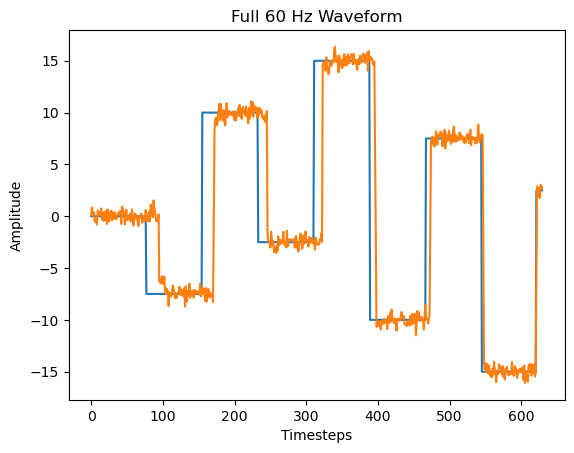

In [55]:
full_data
plt.plot(full_data['timesteps'],full_data['target'])
plt.plot(full_data['timesteps'],full_data['patient'])
plt.xlabel("Timesteps")
plt.ylabel("Amplitude")
plt.title("Full 60 Hz Waveform")

Text(0.5, 1.0, '60 Hz Hypermetria Waveform')

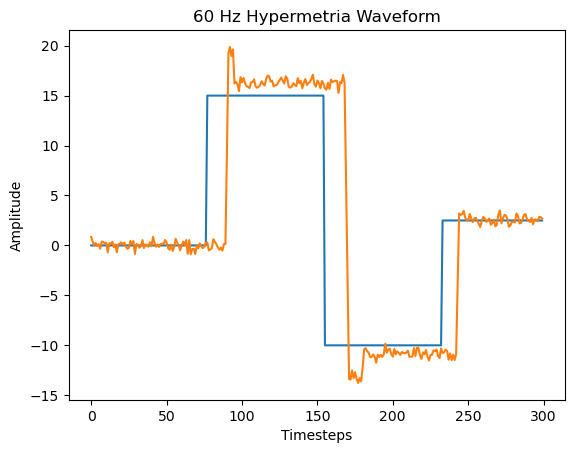

In [76]:
first_five_sec
plt.plot(first_five_sec['timesteps'],first_five_sec['target'])
plt.plot(first_five_sec['timesteps'],first_five_sec['patient'])
plt.xlabel("Timesteps")
plt.ylabel("Amplitude")
plt.title("60 Hz Hypermetria Waveform")